# Setup

**Information about the different models which might be useful when writing the paper**
C-RADIOv2 models are available in multiple sizes: Base (90M parameters). Huge (653M parameters). C-RADIOv2 was trained for 1M steps (400k more steps than v1), using inverse frequency sampling for data balancing, and PHI Standardization for teacher distribution balancing. 

Model Architecture
Architecture Type: Neural Network
Network Architecture: Vision Transformer

c-radio-h	ViT-H/16-CPE https://github.com/NVlabs/RADIO

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
import os
from pathlib import Path

In [9]:
PATH = "../results/results_exp_a_500_sharding_batch4_workers8_dataparallel_memory320000.csv"
MEMORY = 320000
ORIGINAL_DF = pd.read_csv(PATH)
DF = ORIGINAL_DF.copy()

In [10]:
MODELS = {
    "clip-vit-base-patch16": "CLIP",
    "dino_vitb16": "DINO",
    "dinov2_vitb14": "DINOv2",
    "dinov3-vitb16-pretrain-lvd1689m": "DINOv3",
    "C-RADIOv2-B": "C-RADIOv2",
    "siglip2-base-patch16-512": "SigLIP2",
    "tips-b14": "TIPS",
    # "vggt-1b": "VGGT",
}
PREFIXES = {
    "clip-vit-base-patch16": "clip",
    "dino_vitb16": "dino",
    "dinov2_vitb14": "dinov2",
    "dinov3-vitb16-pretrain-lvd1689m": "dinov3",
    "C-RADIOv2-B": "radio",
    "siglip2-base-patch16-512": "siglip2",
    "tips-b14":"tips",
    # "vggt-1b": "vggt",
}
COLORS = {
    "clip-vit-base-patch16": "#1f77b4",
    "dino_vitb16": "#ff7f0e",
    "dinov2_vitb14": "#2ca02c",
    "dinov3-vitb16-pretrain-lvd1689m": "#17becf",
    "C-RADIOv2-B": "#d62728",
    "siglip2-base-patch16-512": "#9467bd",
    "tips-b14": "#8c564b",
    # "vggt-1b": "#e377c2",
}
TRAIN_BINS_DIFFICULTY = {
    "0_30_60_90": "easy",
    "0_45_90": "medium",
    "0_90": "hard",
    "0": "extreme"
}
XTICKS = [0, 15, 30, 45, 60, 75, 90]
CLASS_TO_INDEX = {
    0: 0,
    7: 1,
    8: 2,
    19: 3,
    46: 4,
    57: 5,
    60: 6,
    70: 7,
    99: 8,
    100: 9,
    113: 10,
    125: 11,
    126: 12,
    152: 13,
    166: 14,
    196: 15,
}
CLASS_TO_NAME = {
    0: "background",
    7: "stove",
    8: "sofa",
    19: "microwave",
    46: "bed",
    57: "toy cat",
    60: "toy cow",
    70: "toy dragon",
    99: "coat rack",
    100: "guitar stand",
    113: "ceiling lamp",
    125: "toilet",
    126: "sink",
    152: "strings",
    166: "broccoli",
    196: "durian"
}


# Experiment A

In [11]:
DF.head()

job_id        model  train_bins  val_bin  jac_mean  jac_std   jac0  \
0  12071717  C-RADIOv2-B  0_30_60_90        0     0.623    0.151  0.961   
1  12071717  C-RADIOv2-B  0_30_60_90       15     0.605    0.161  0.960   
2  12071717  C-RADIOv2-B  0_30_60_90       30     0.635    0.147  0.963   
3  12071717  C-RADIOv2-B  0_30_60_90       45     0.620    0.154  0.962   
4  12071717  C-RADIOv2-B  0_30_60_90       60     0.637    0.140  0.964   

    jac1   jac2   jac3  ...  jac10  jac11  jac12  jac13  jac14  jac15  \
0  0.598  0.621  0.592  ...  0.646  0.851  0.454  0.627  0.715  0.841   
1  0.596  0.610  0.545  ...  0.631  0.841  0.399  0.643  0.698  0.837   
2  0.635  0.644  0.573  ...  0.648  0.848  0.459  0.691  0.698  0.843   
3  0.640  0.609  0.549  ...  0.652  0.832  0.459  0.693  0.692  0.845   
4  0.645  0.636  0.542  ...  0.651  0.815  0.479  0.696  0.692  0.845   

   d_model  batch_size  input_size  patch_size  
0      768           4         512          16  
1      768           4         512          16  
2      768           4         512          16  
3      768           4         512          16  
4      768           4         512          16  

[5 rows x 26 columns]

In [12]:
DF_A = DF.copy()

def plot_exp_a(classes: None | list[int], include_bg: bool, extratitle: str, save_path: str | None = None):
    """
    Plot experiment A result as grouped bar histograms per class and model.
    """
    assert type(classes) in [list, type(None)], "classes must be a list or None"

    if classes is None:
        classes = list(CLASS_TO_INDEX.keys())
    else:
        assert all(c in CLASS_TO_INDEX for c in classes), "classes must be a subset of CLASS_TO_INDEX keys"

    if not include_bg:
        classes = [c for c in classes if c != 0]

    class_indices = [CLASS_TO_INDEX[c] for c in classes]

    fig, axes = plt.subplots(2, 2, figsize=(14, 8), dpi=200)
    axes = axes.flatten()

    bar_width = 0.1
    for i, (train_bins, difficulty) in enumerate(TRAIN_BINS_DIFFICULTY.items()):
        ax = axes[i]
        train_bins_set = set(map(int, train_bins.split("_")))  # ToDo: ?
        bin_vals = sorted(set(DF_A["val_bin"]))

        x_pos = np.arange(len(bin_vals))  # One group per val_bin
        total_models = len(MODELS)

        for model_idx, (model, model_label) in enumerate(MODELS.items()):
            df = DF_A[(DF_A["model"] == model) & (DF_A["train_bins"] == train_bins)].sort_values("val_bin")
            if df.empty:
                print(f"No data for model {model} with train_bins {train_bins} and classes {classes}")
                continue

            # Offset x for grouped bars
            offset = (model_idx - total_models / 2) * bar_width + bar_width / 2
            x_offset = x_pos + offset

            means = df[[f"jac{c}" for c in class_indices]].mean(axis=1).values

            if i == 0:
                means[0] = 0
                means[2] = 0
                means[4] = 0
                means[6] = 0
            elif i == 1:
                means[0] = 0
                means[3] = 0
                means[6] = 0
            elif i == 2:
                means[0] = 0
                means[6] = 0
            elif i == 3:
                means[0] = 0

            ax.bar(x_offset, means, width=bar_width, label=model_label,
                   color=COLORS[model], capsize=4, zorder=2)

            means = df[[f"jac{c}" for c in class_indices]].mean(axis=1).values
            if i == 0:
                means[1] = 0
                means[3] = 0
                means[5] = 0
            elif i == 1:
                means[1] = 0
                means[2] = 0
                means[4] = 0
                means[5] = 0
            elif i == 2:
                means[1] = 0
                means[2] = 0
                means[3] = 0
                means[4] = 0
                means[5] = 0
            elif i == 3:
                means[6] = 0
                means[1] = 0
                means[2] = 0
                means[3] = 0
                means[4] = 0
                means[5] = 0
            ax.scatter(x_offset, means, marker='.', color=COLORS[model], s=50, zorder=3)

        ax.set_xticks(x_pos)
        ax.set_xticklabels([str(b) for b in bin_vals])
        ax.set_ylim(0, 1)
        ax.set_title(f"({string.ascii_letters[i]}) Train bin(s): {', '.join(train_bins.split('_'))} ({difficulty})")
        ax.set_xlabel("Validation Bin")
        ax.set_ylabel("mIoU")
        ax.grid(True, axis='y', linestyle='--', linewidth=0.5)

    axes[0].legend(loc="lower left", bbox_to_anchor=(0, 0))
    plt.suptitle(f"Experiment A Results — {extratitle}", fontsize=25, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])


    # Save figure
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved figure to {save_path}")

    plt.show()
    plt.close()


## Plots

Saved figure to ../images/figures/All_Classes_No_BG.png


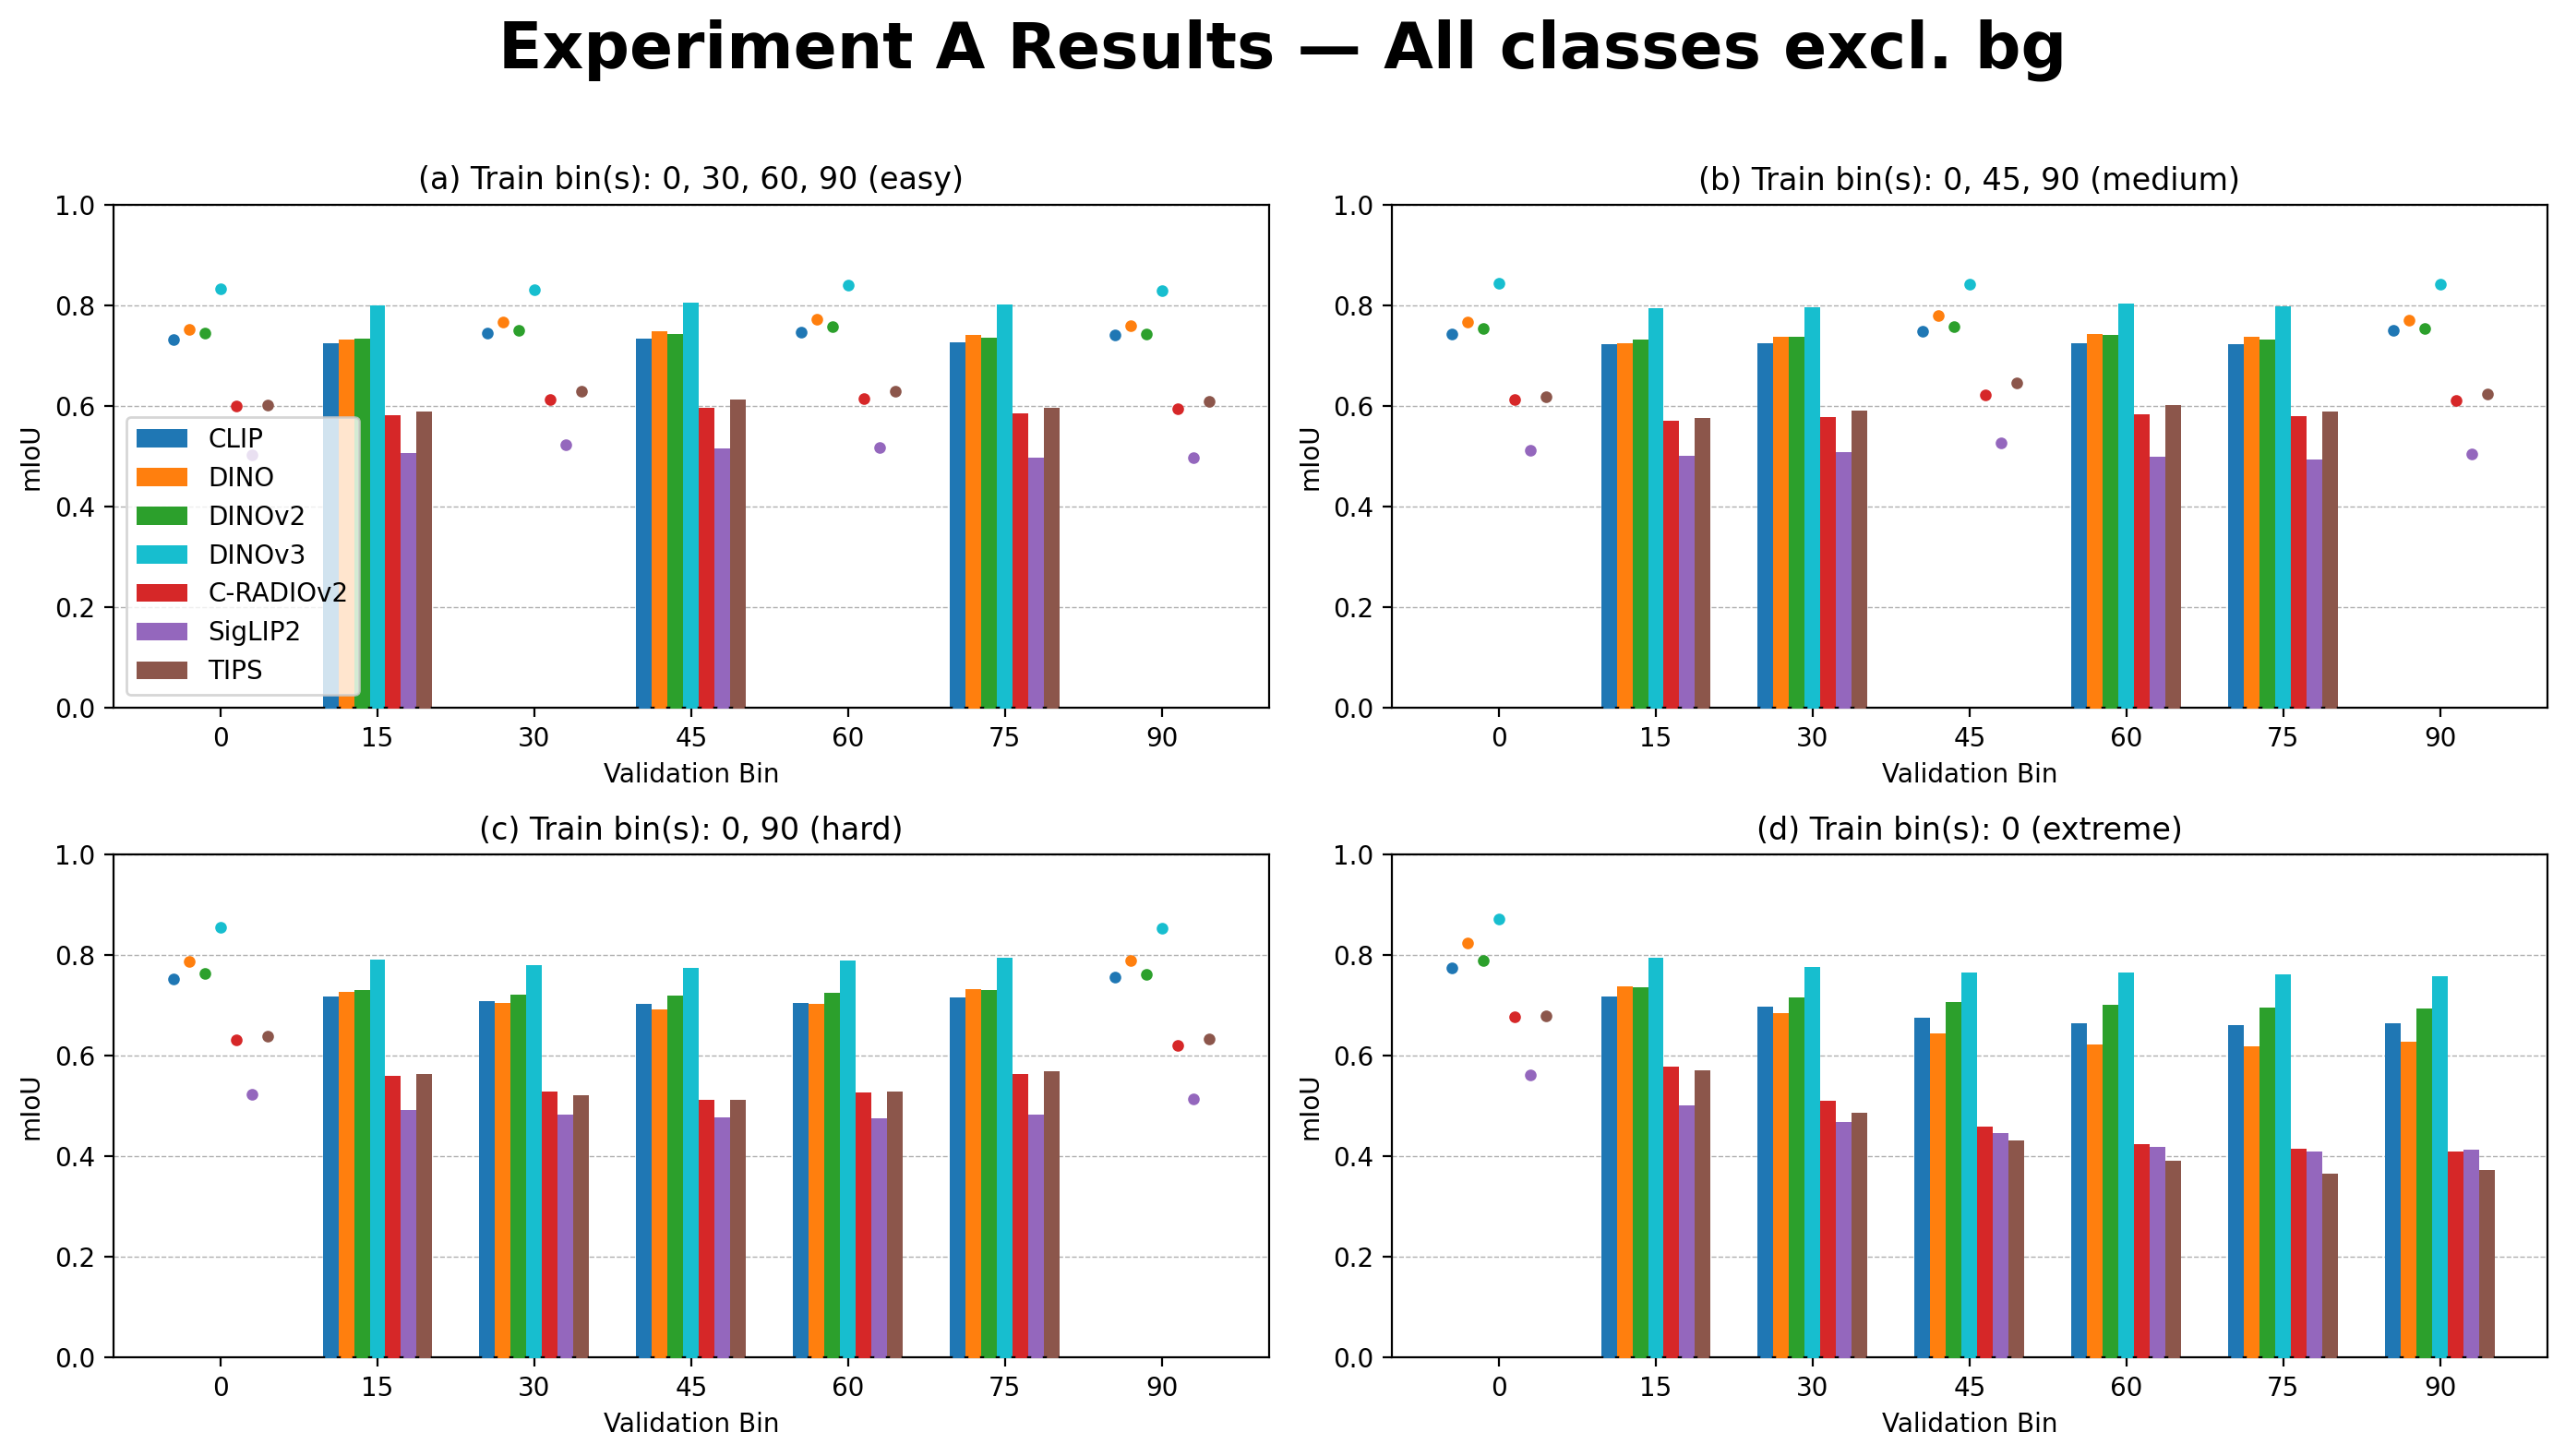

Saved figure to ../images/figures/All_Classes.png


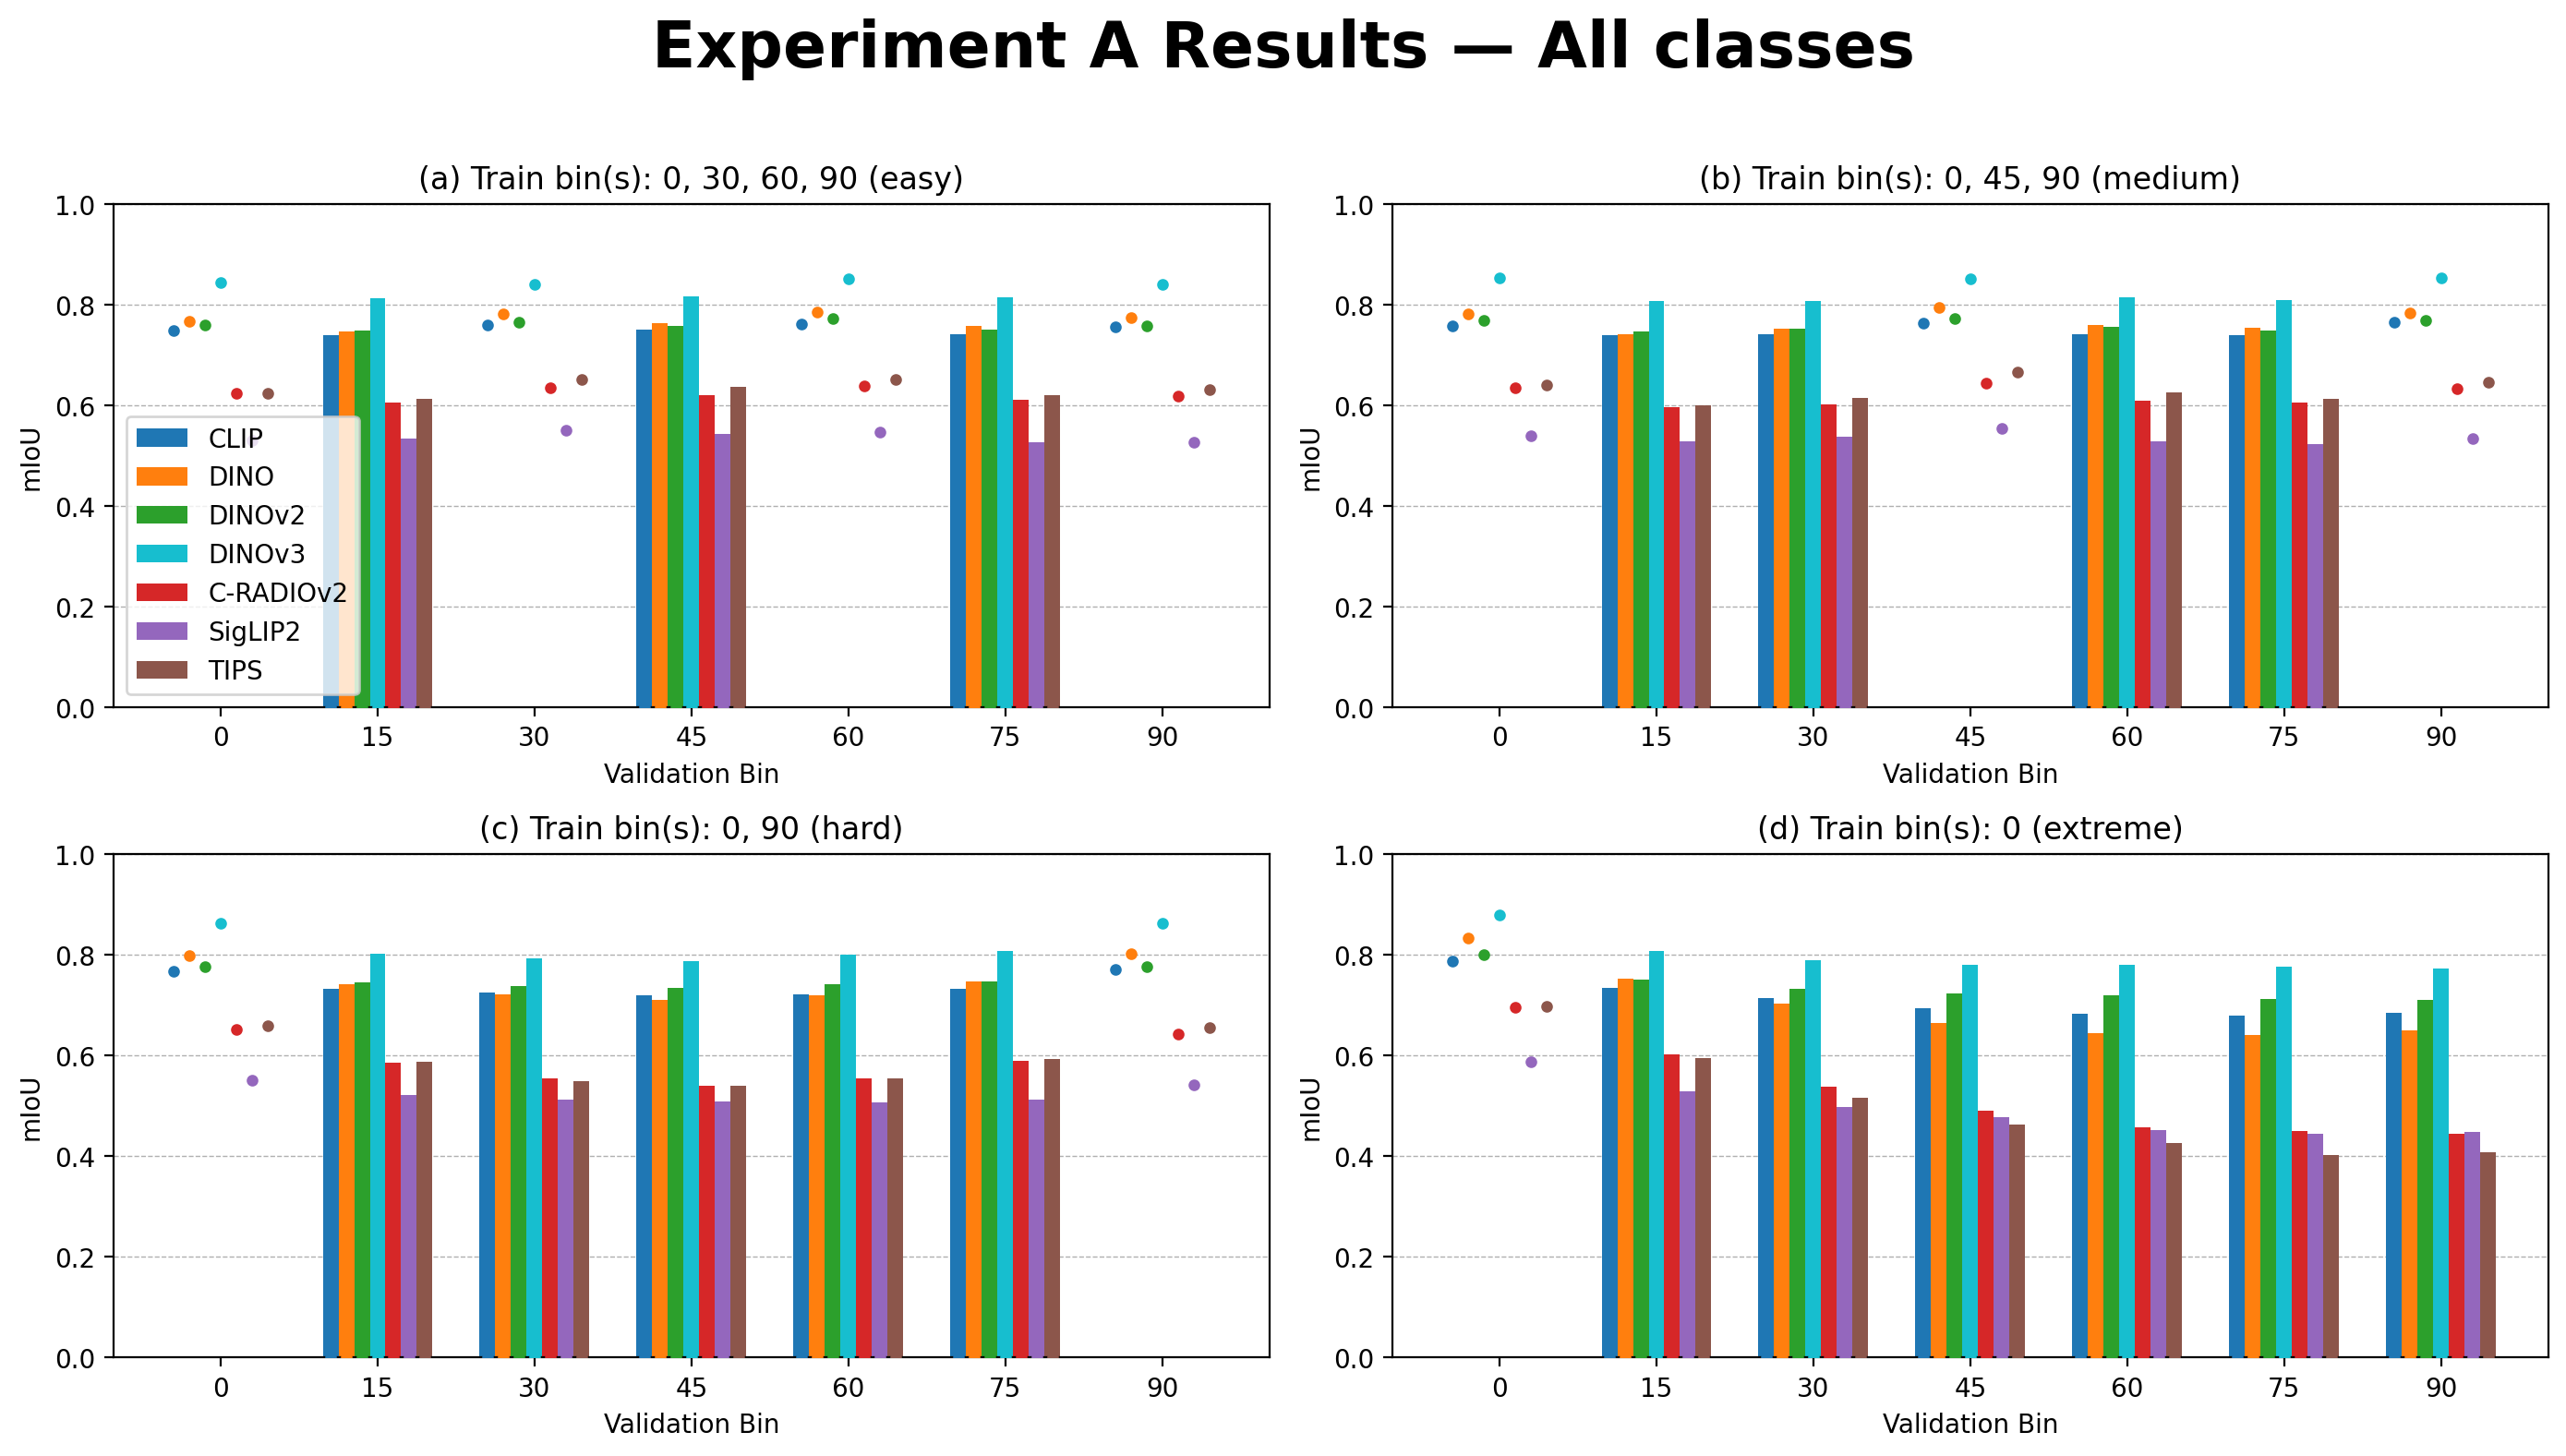

In [13]:
# Experiment A (Grouped Bar Histograms)
os.makedirs("../images/figures", exist_ok=True)

# Plot all classes
plot_exp_a(None, False, extratitle="All classes excl. bg", save_path="../images/figures/All_Classes_No_BG.png")
plot_exp_a(None, True, extratitle="All classes", save_path="../images/figures/All_Classes.png")

Saved figure to ../images/figures/0_background.png


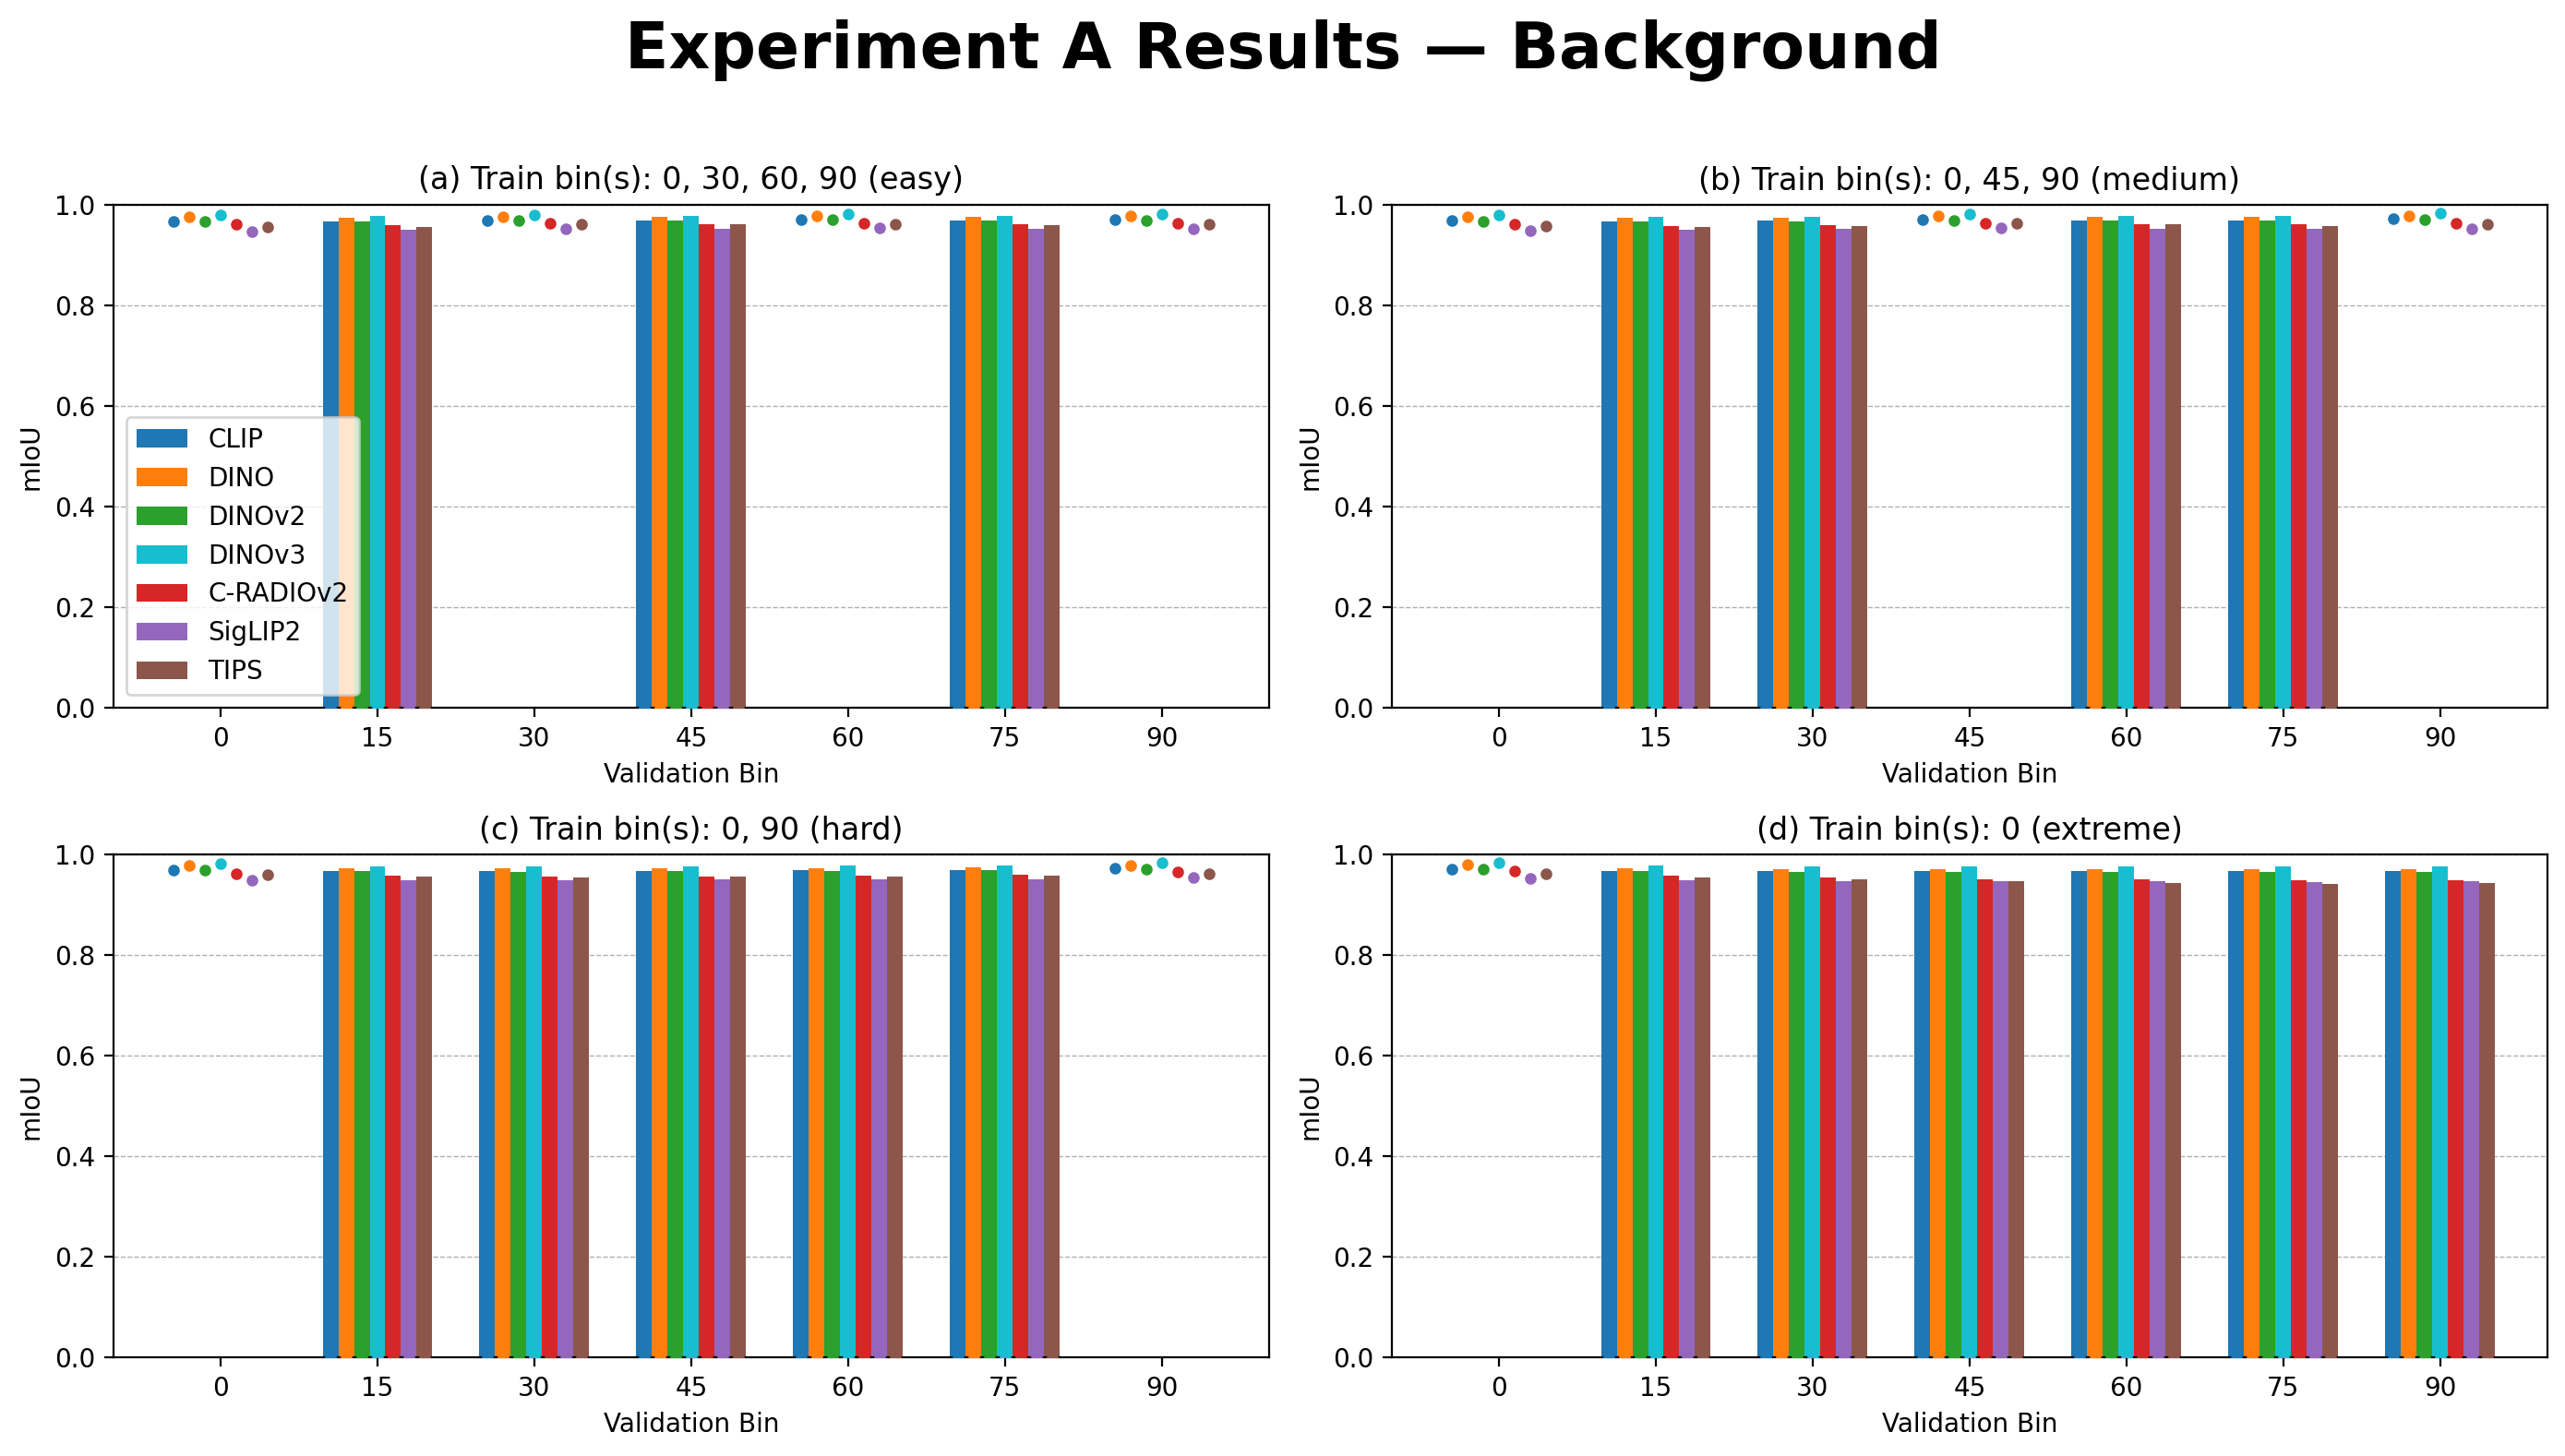

Saved figure to ../images/figures/1_stove.png


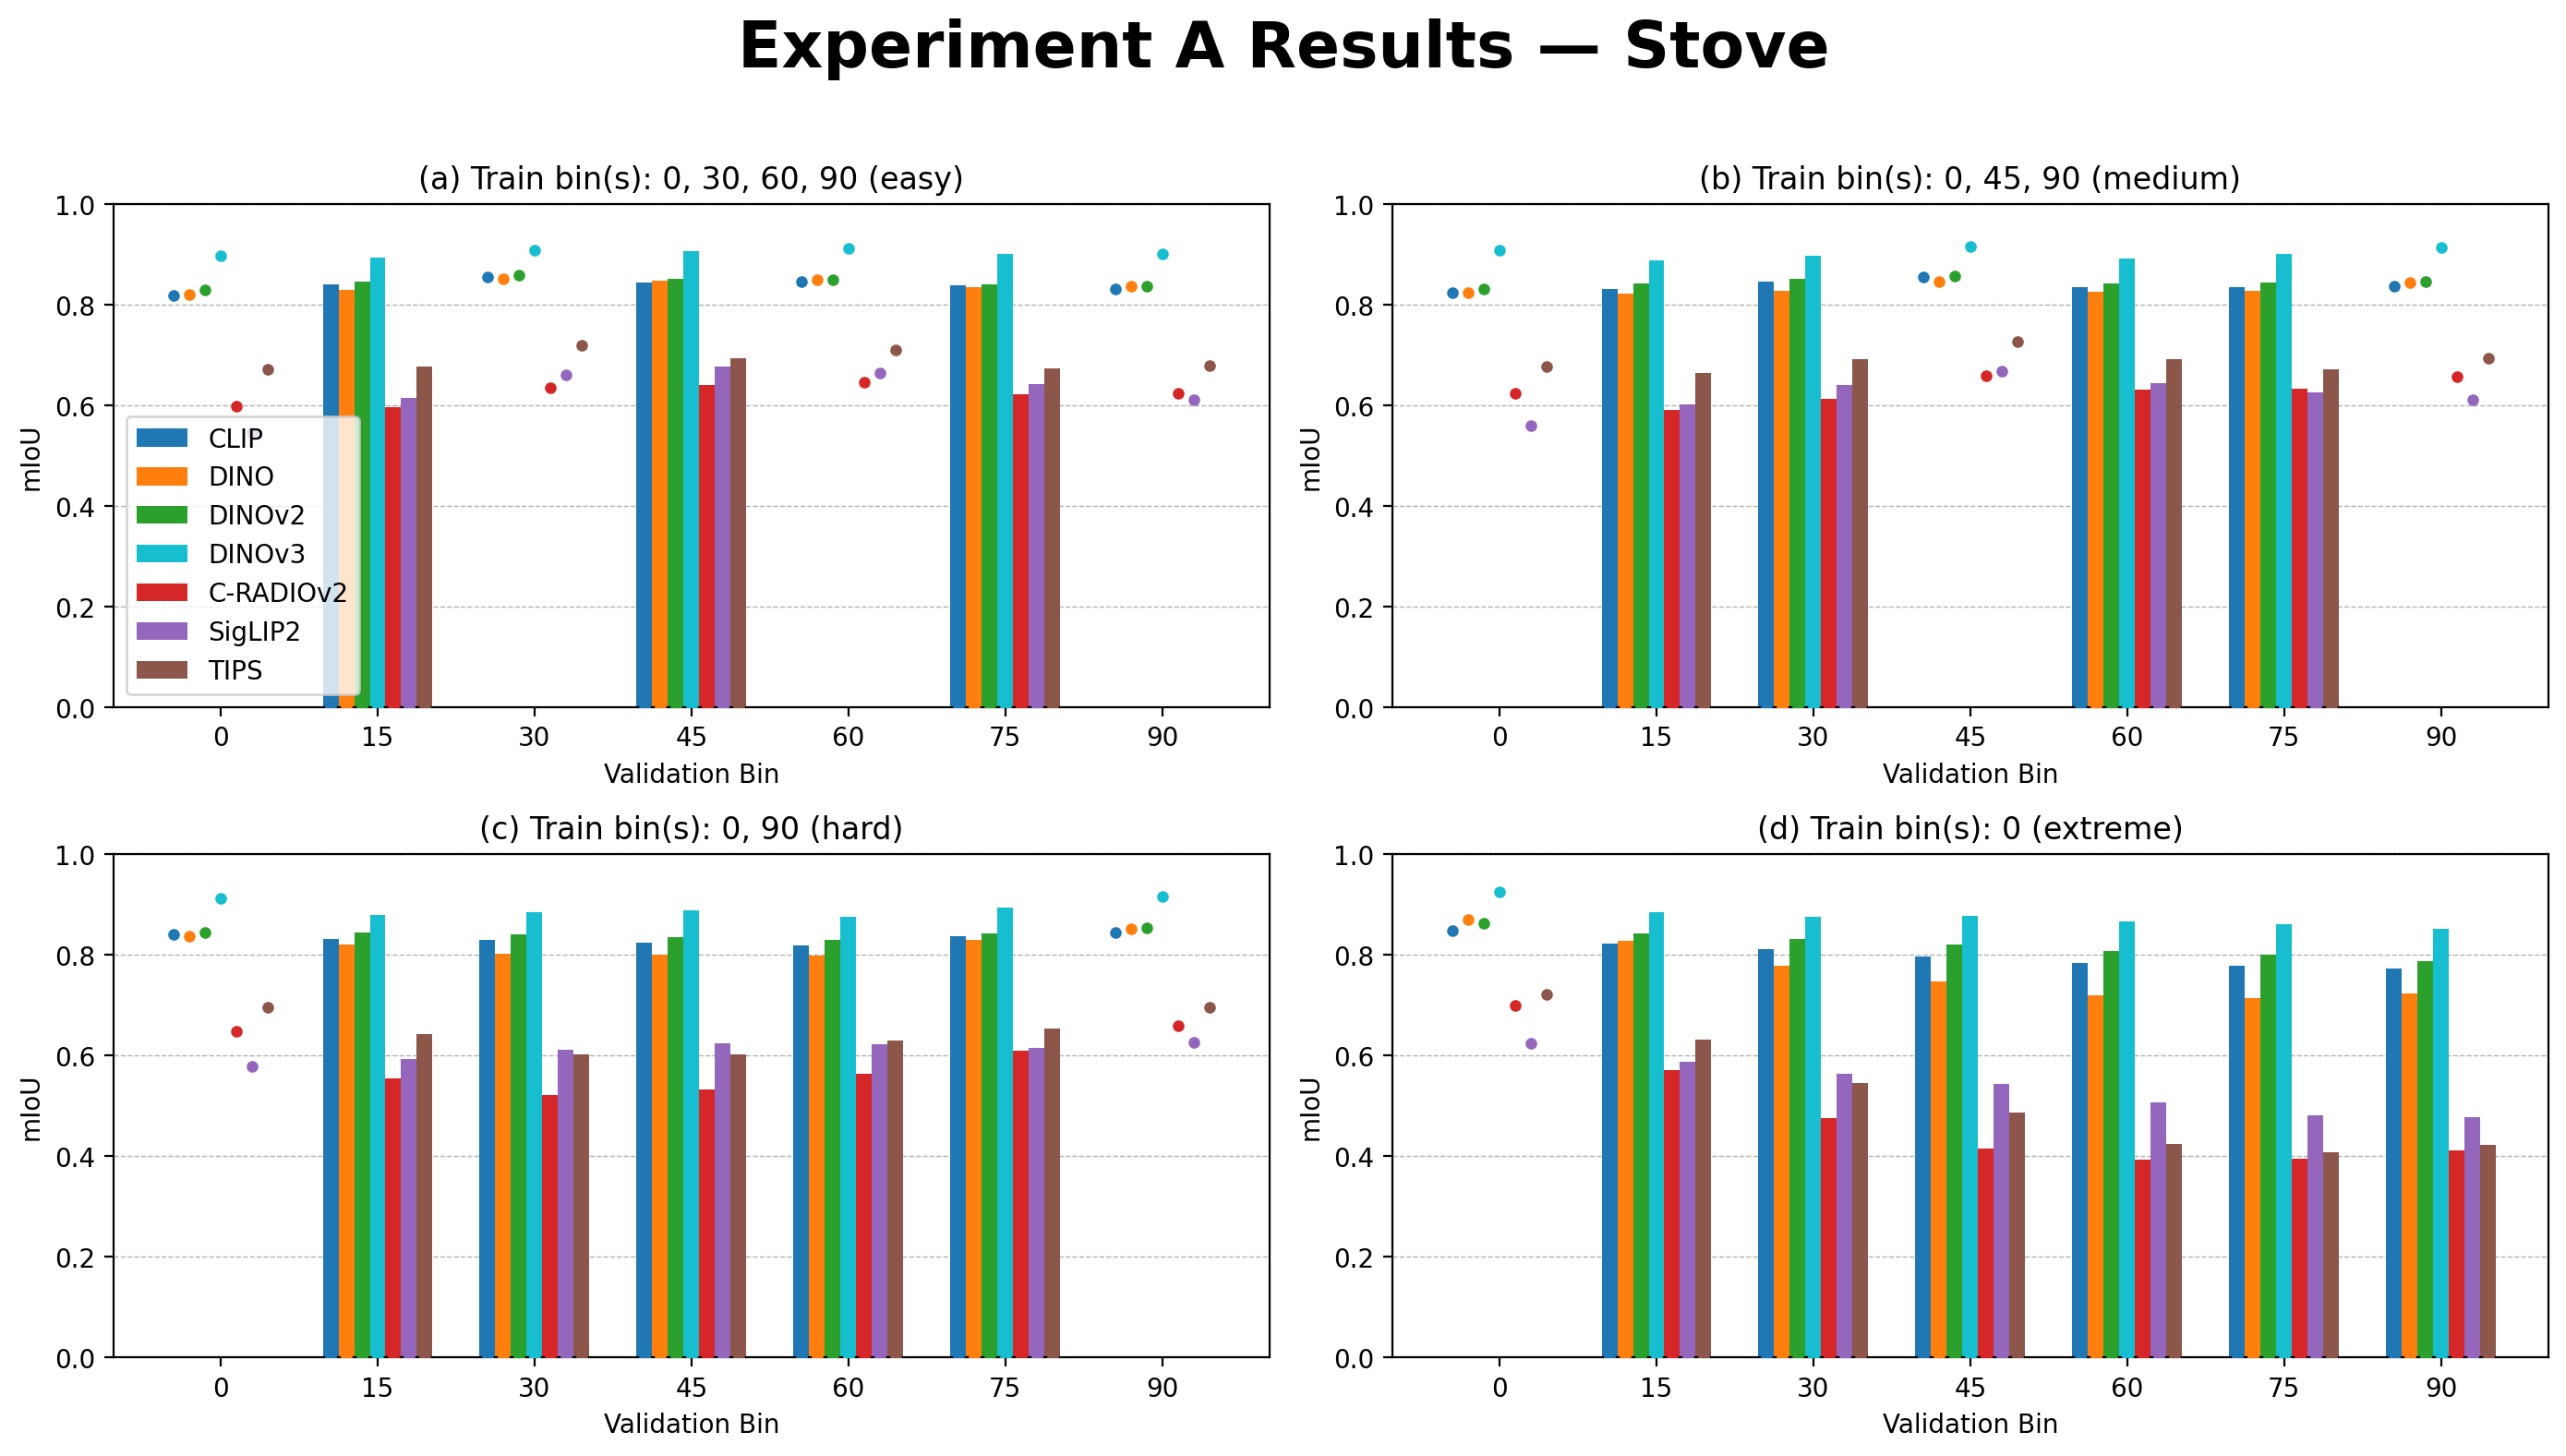

Saved figure to ../images/figures/2_sofa.png


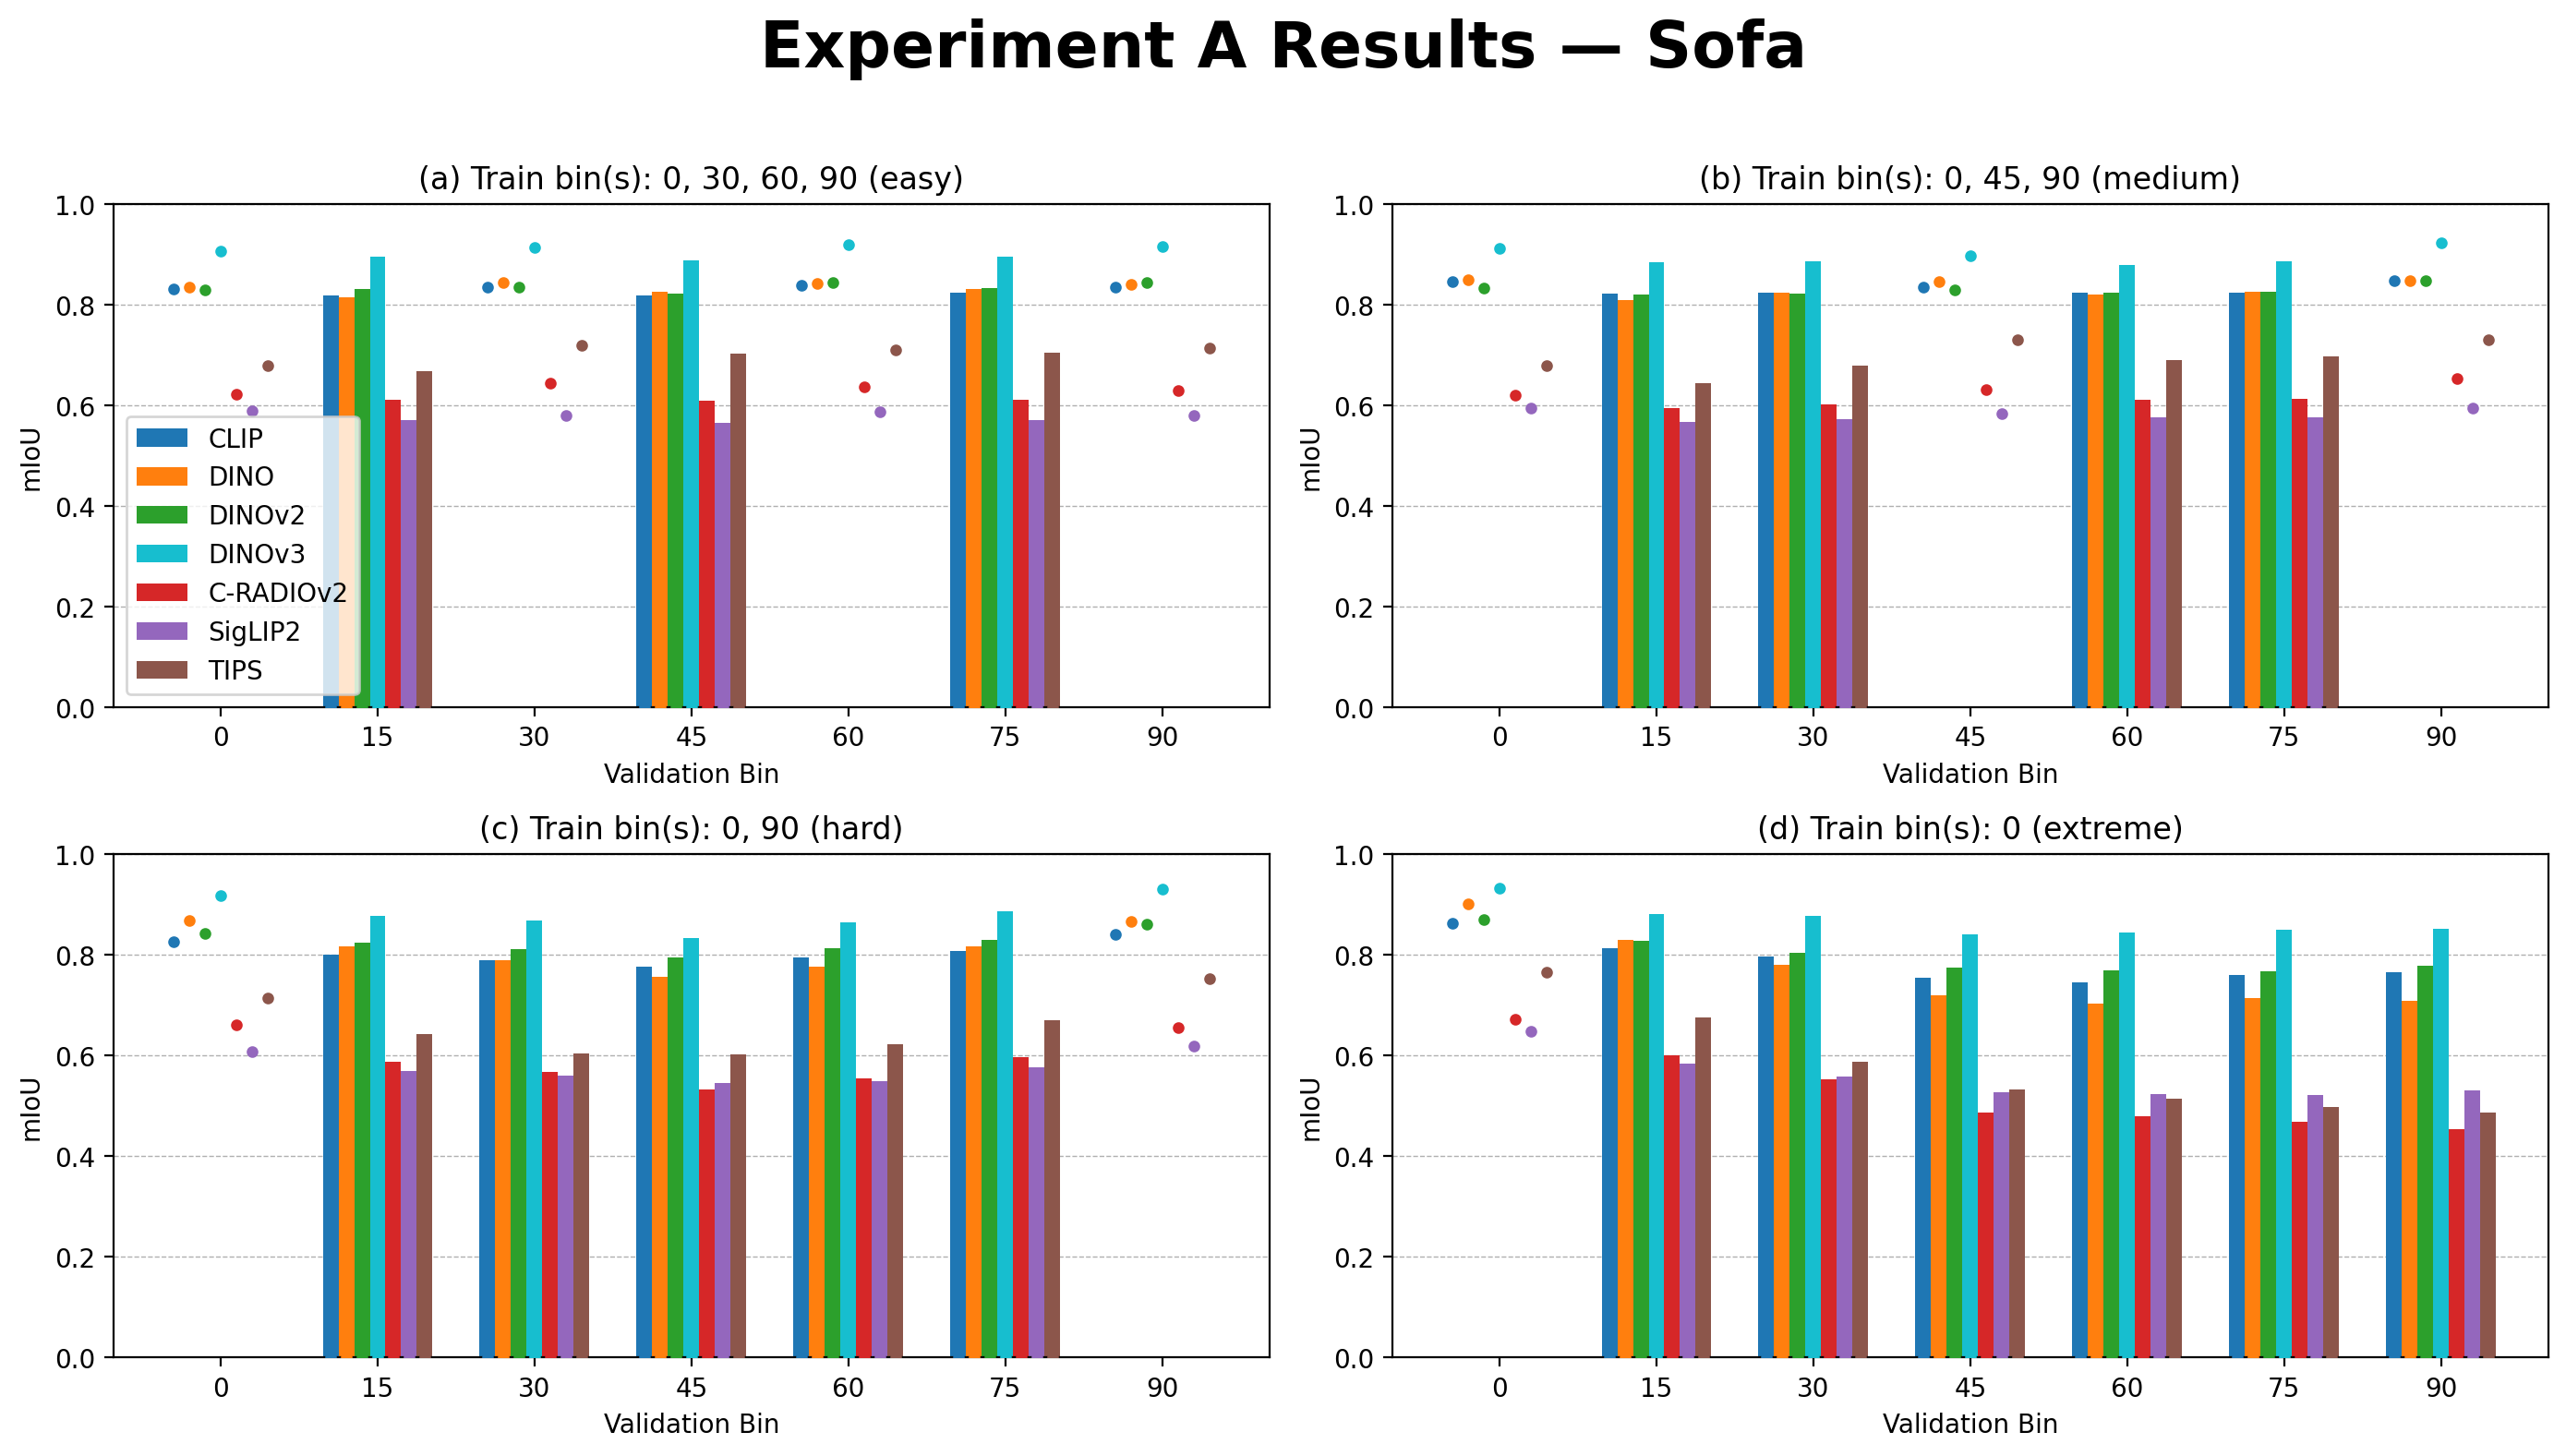

Saved figure to ../images/figures/3_microwave.png


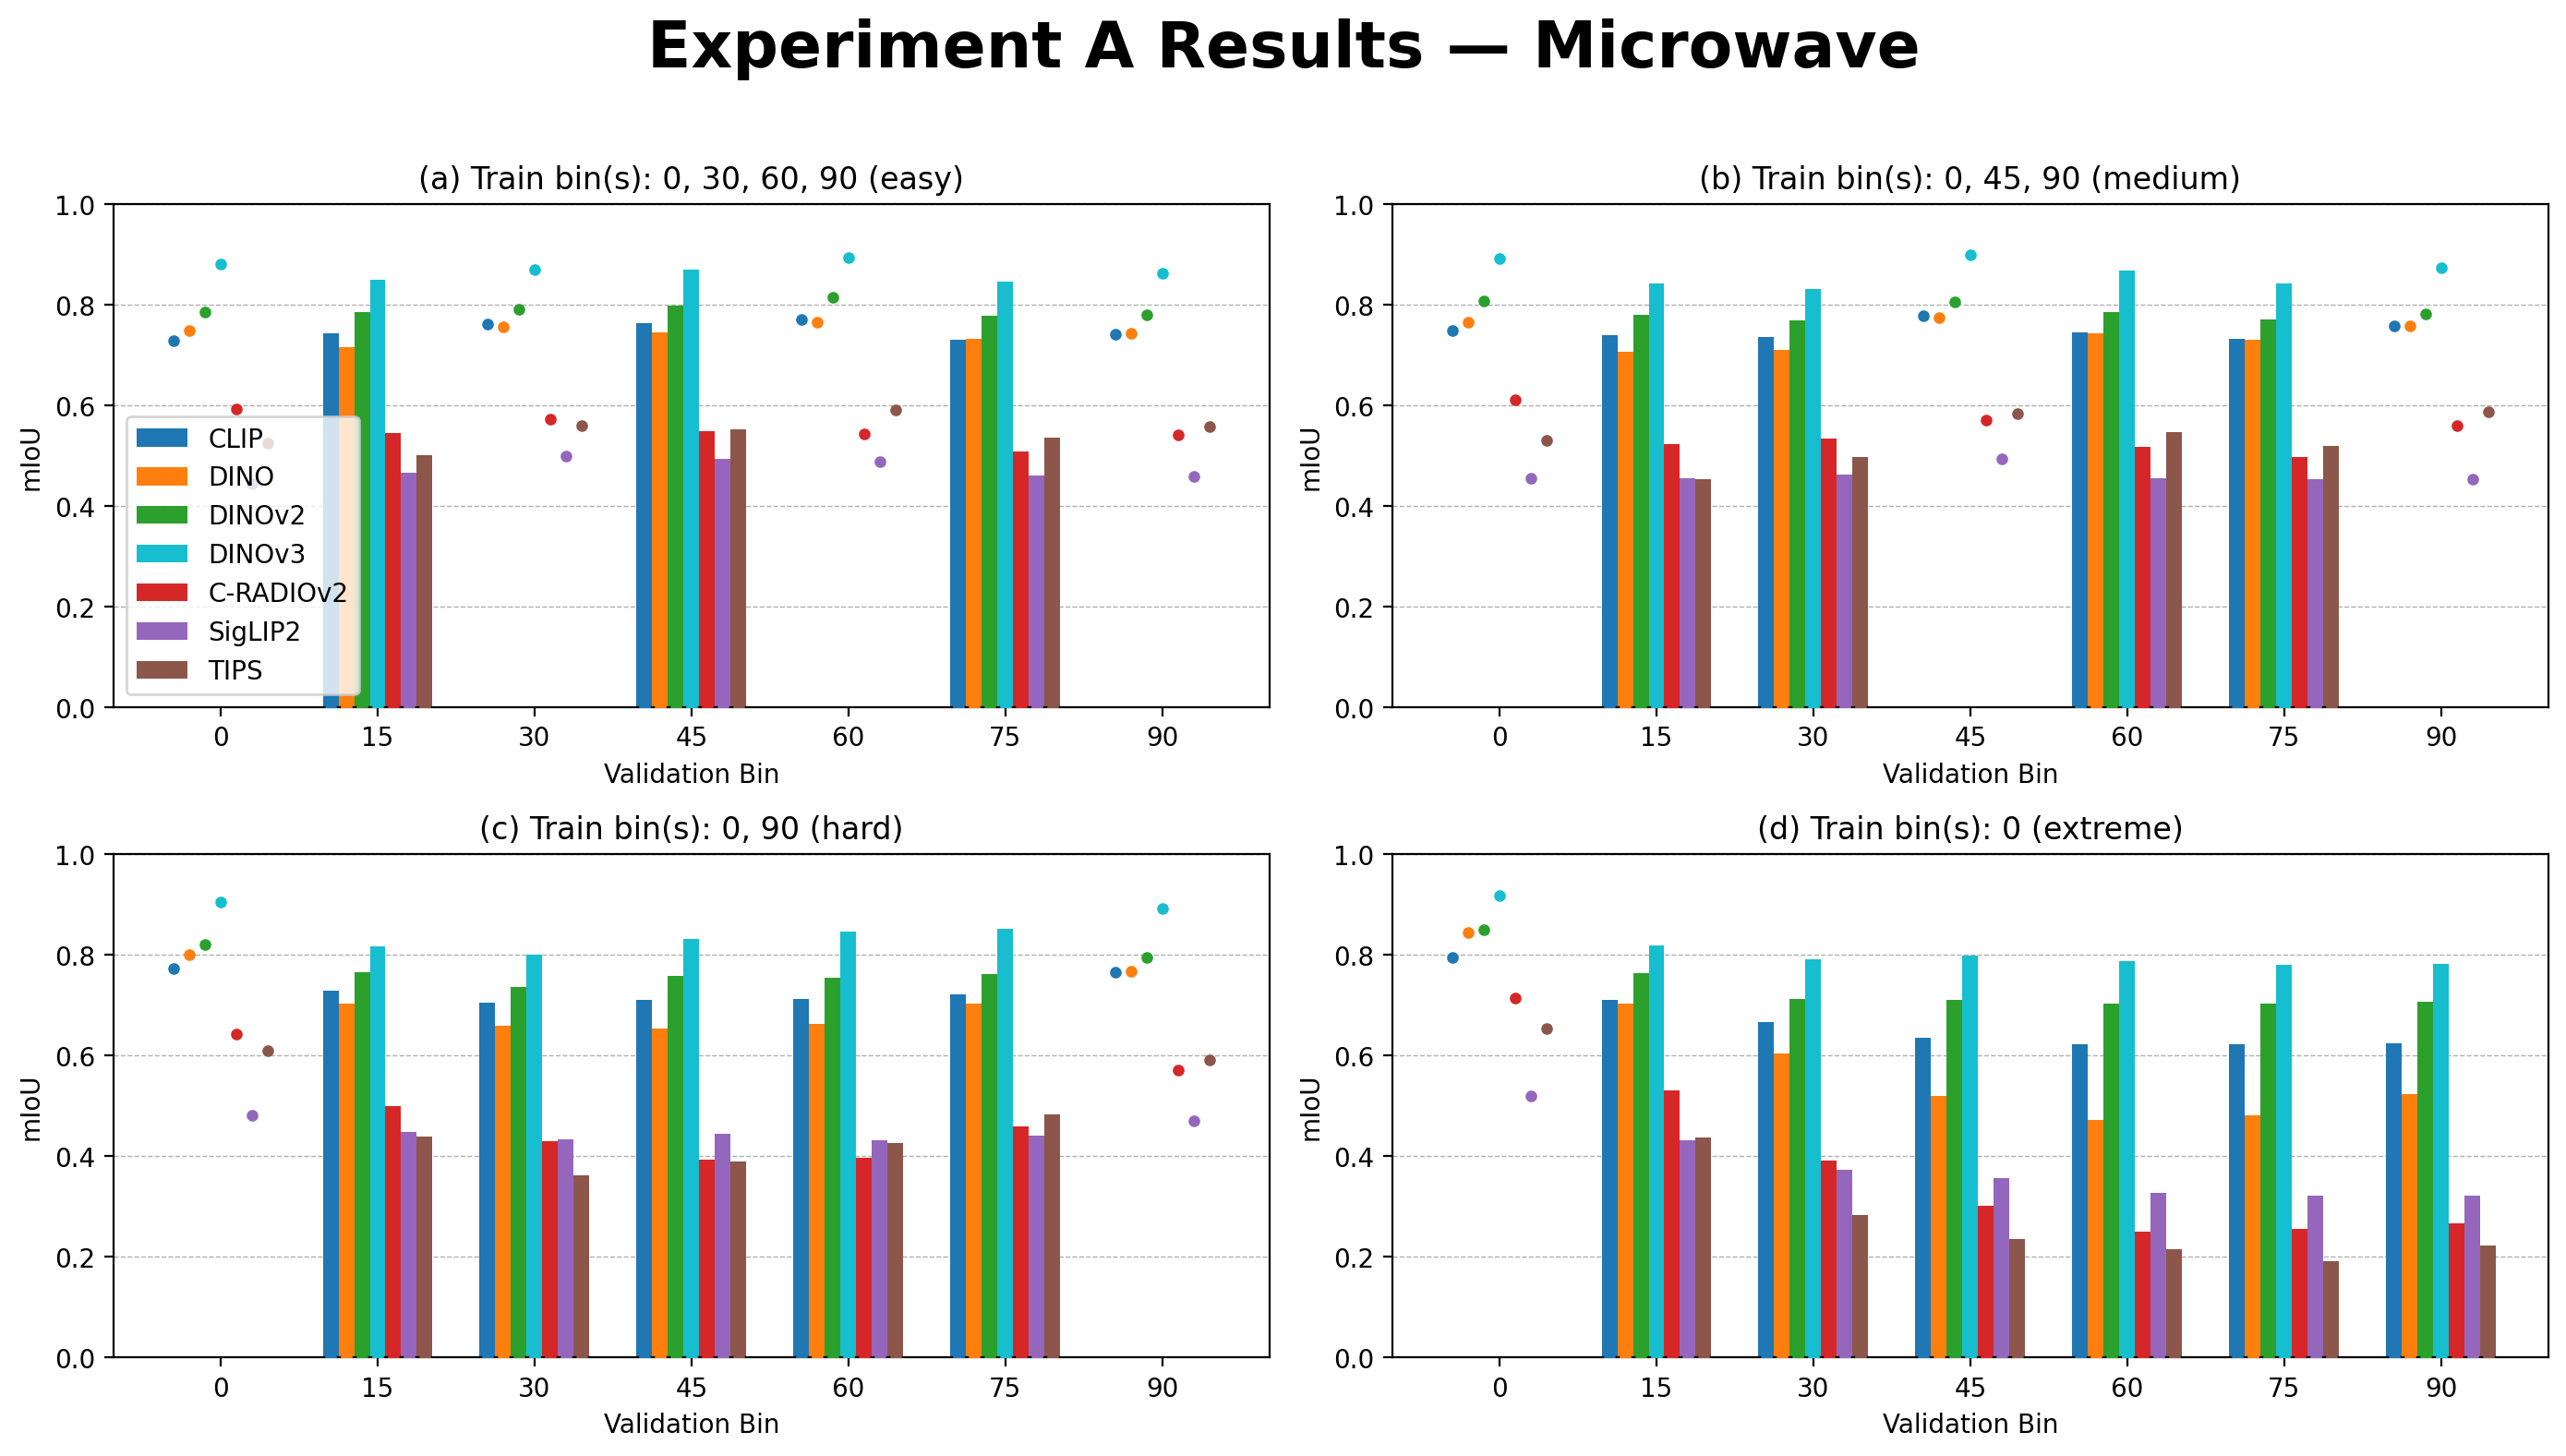

Saved figure to ../images/figures/4_bed.png


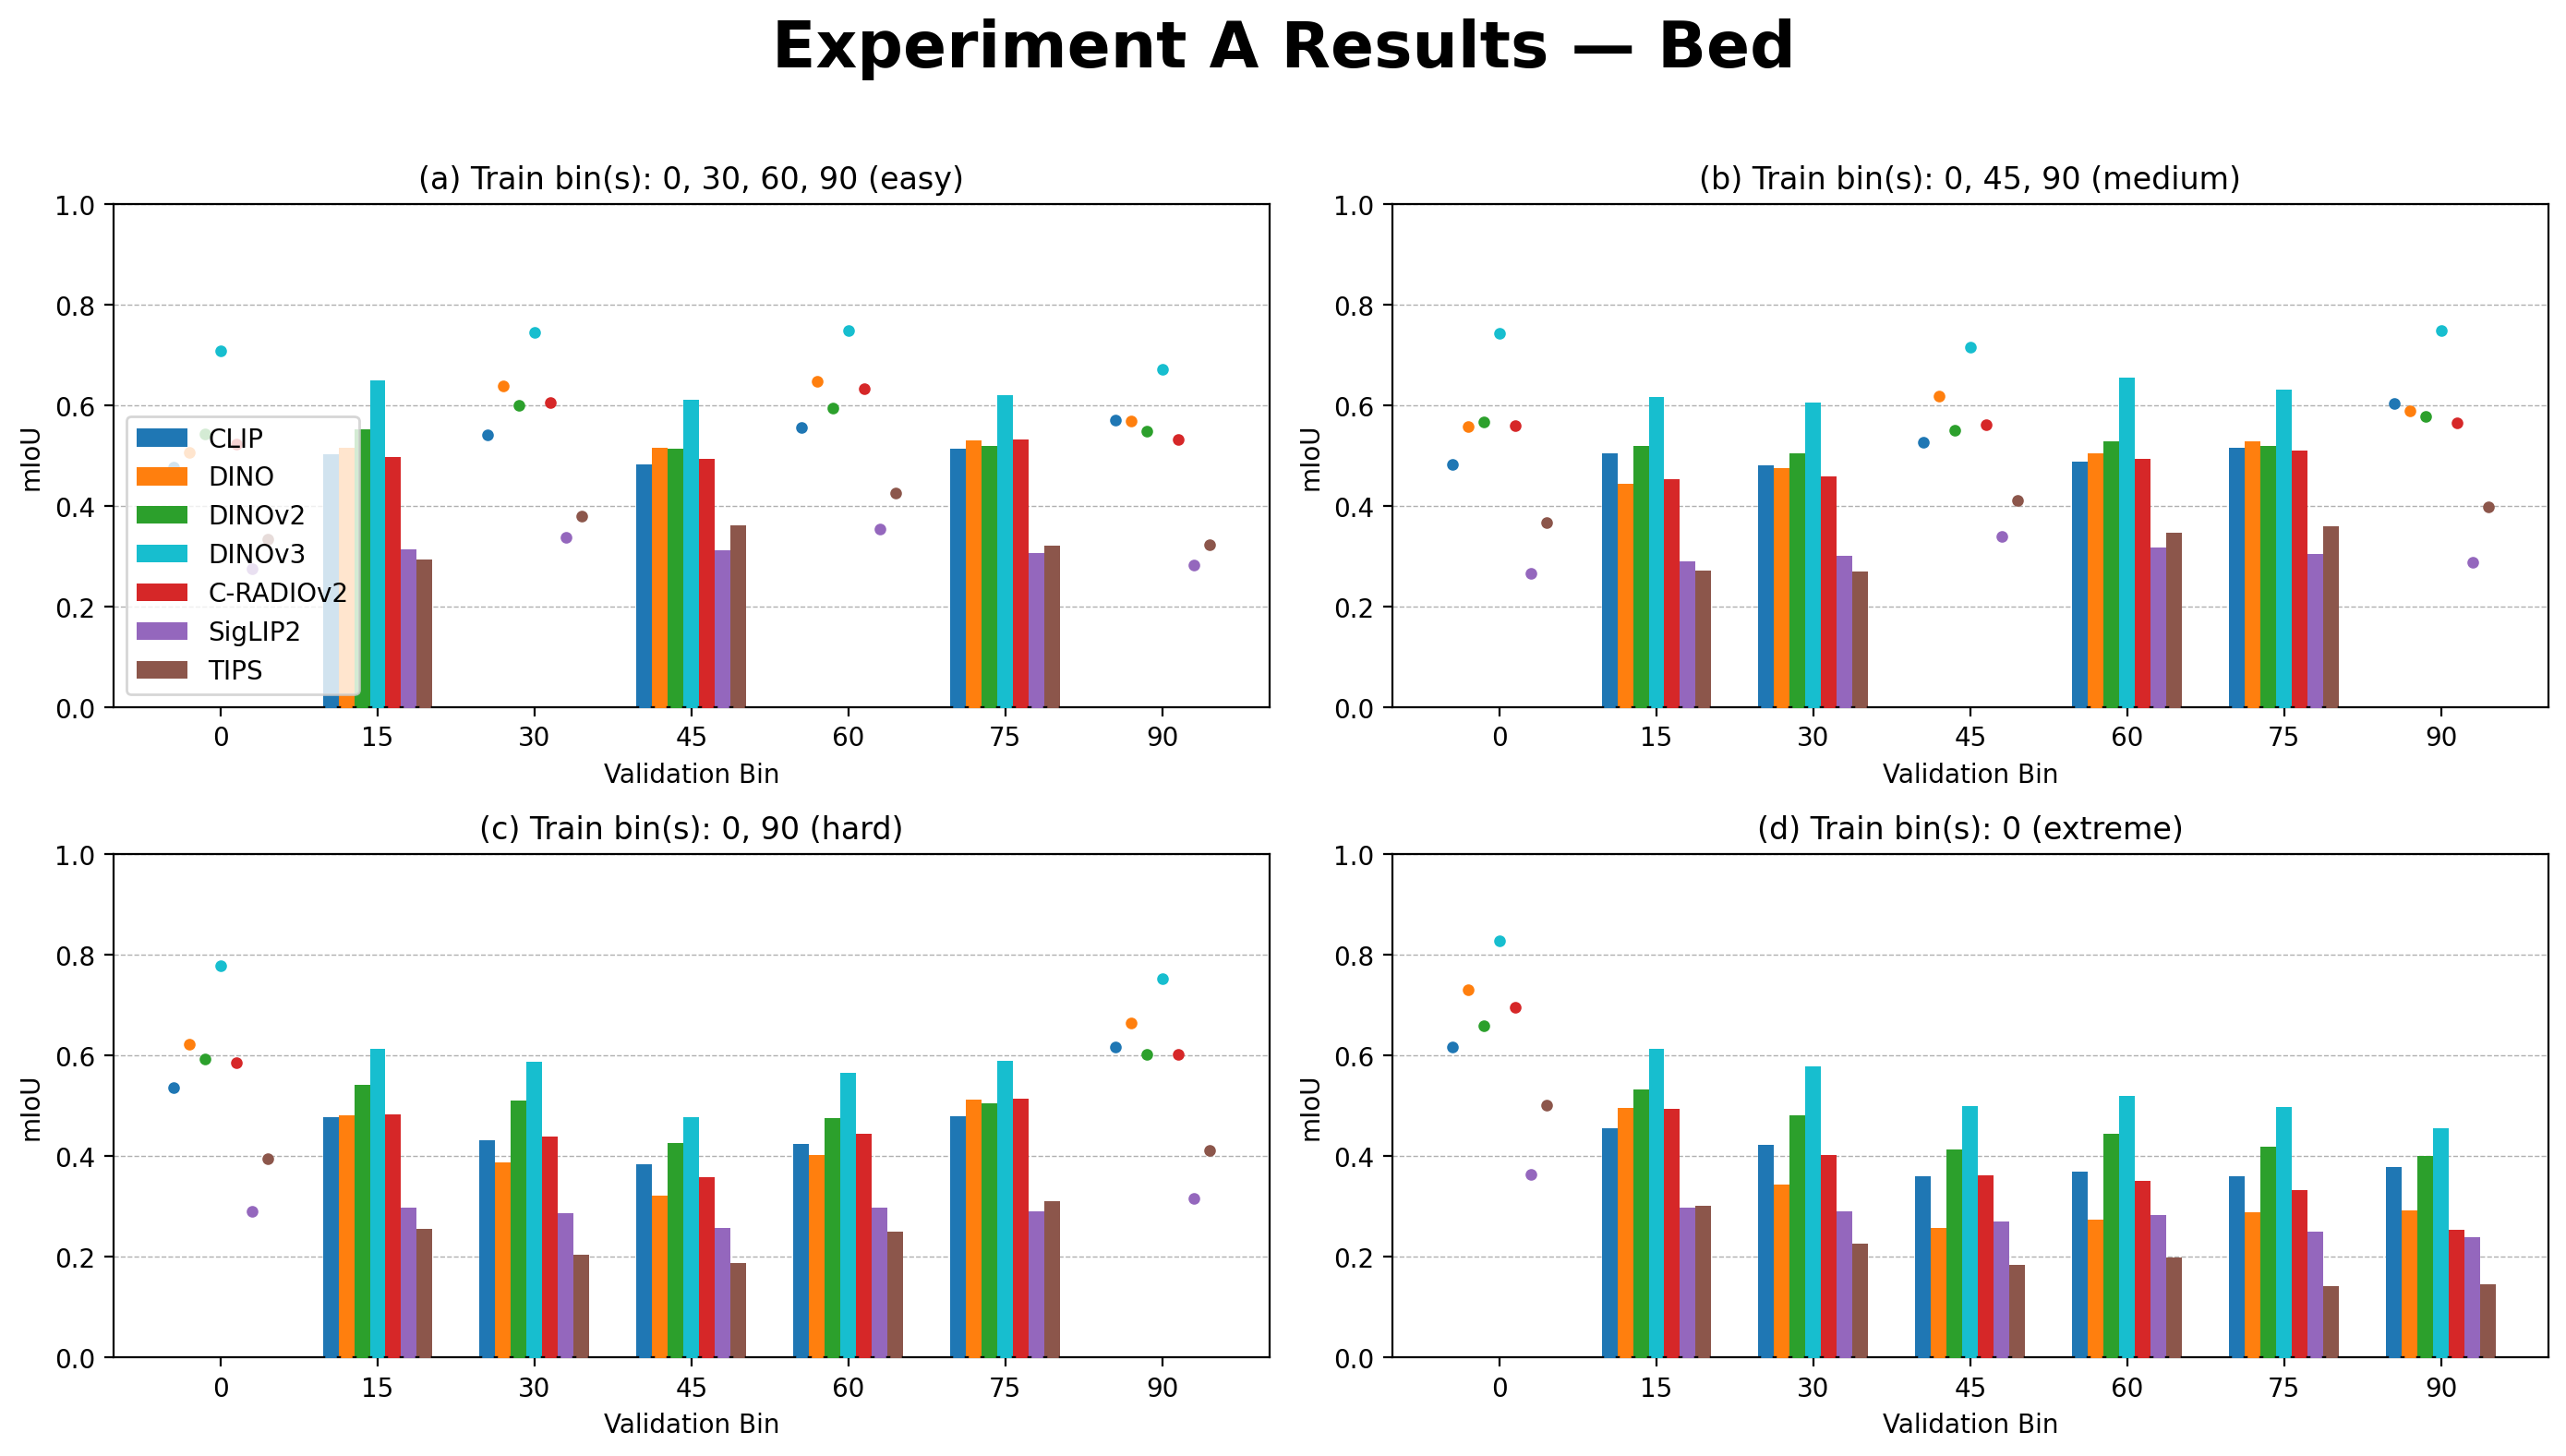

Saved figure to ../images/figures/5_toy_cat.png


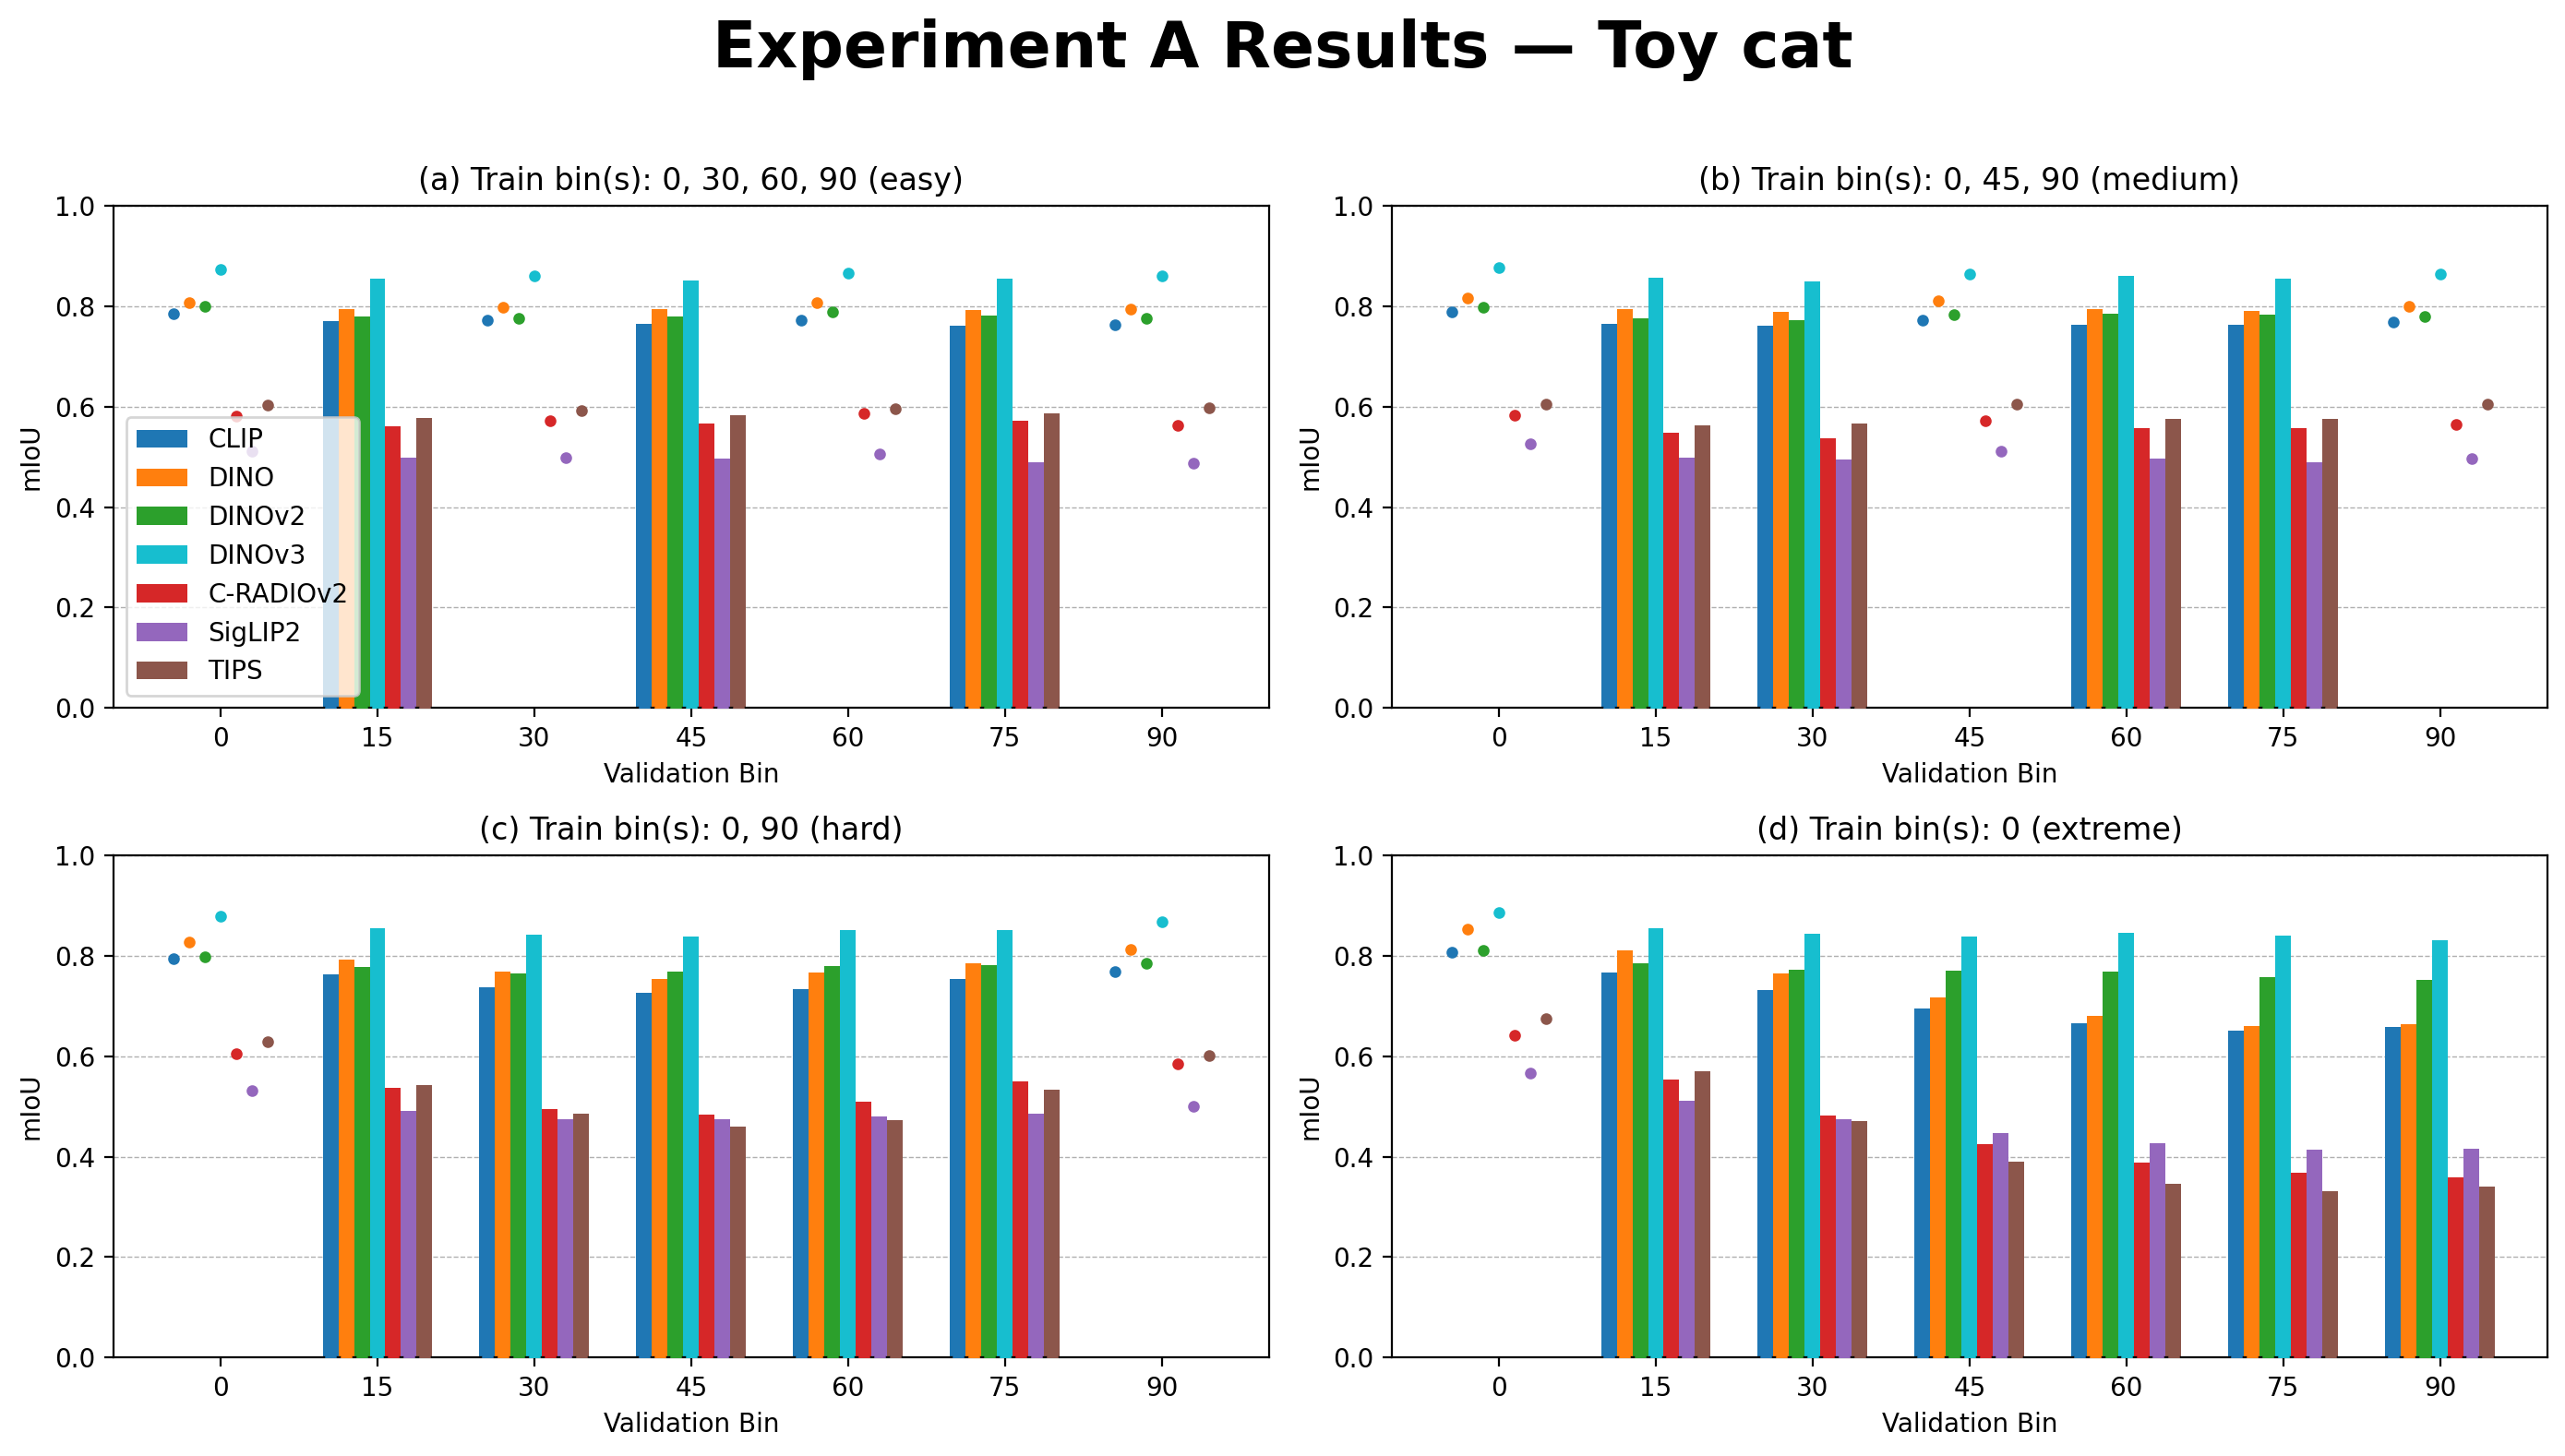

Saved figure to ../images/figures/6_toy_cow.png


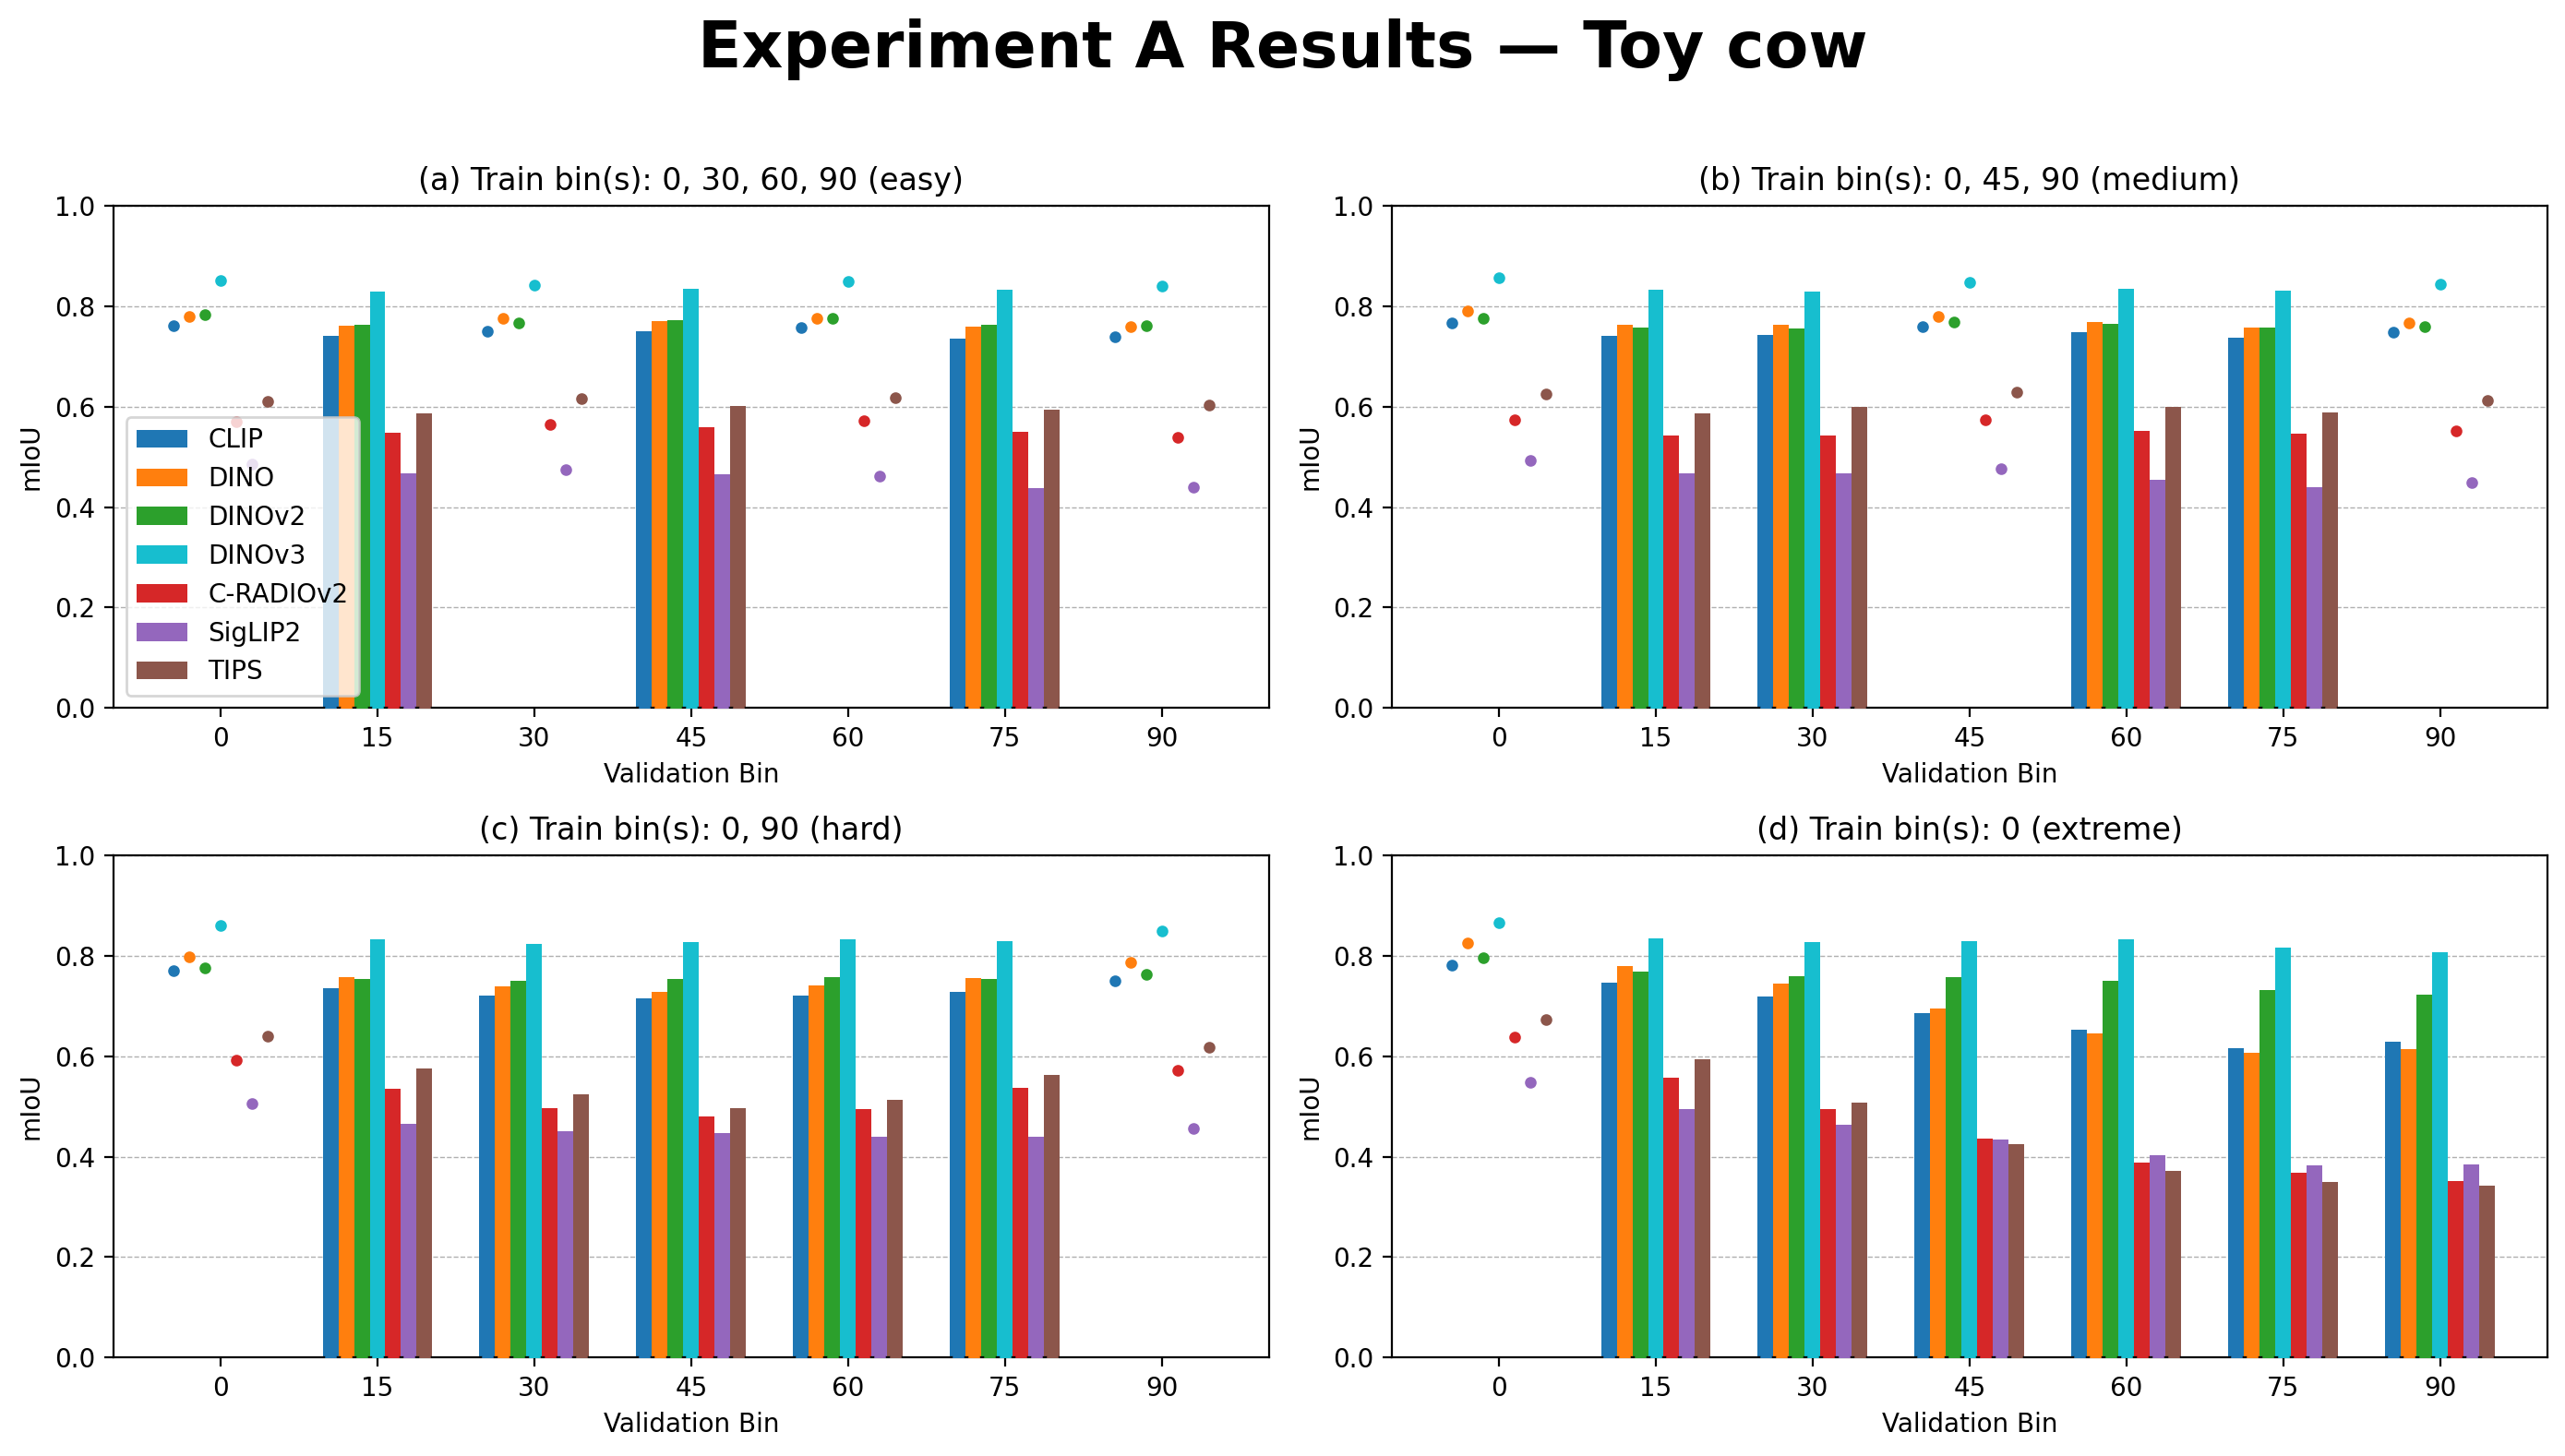

Saved figure to ../images/figures/7_toy_dragon.png


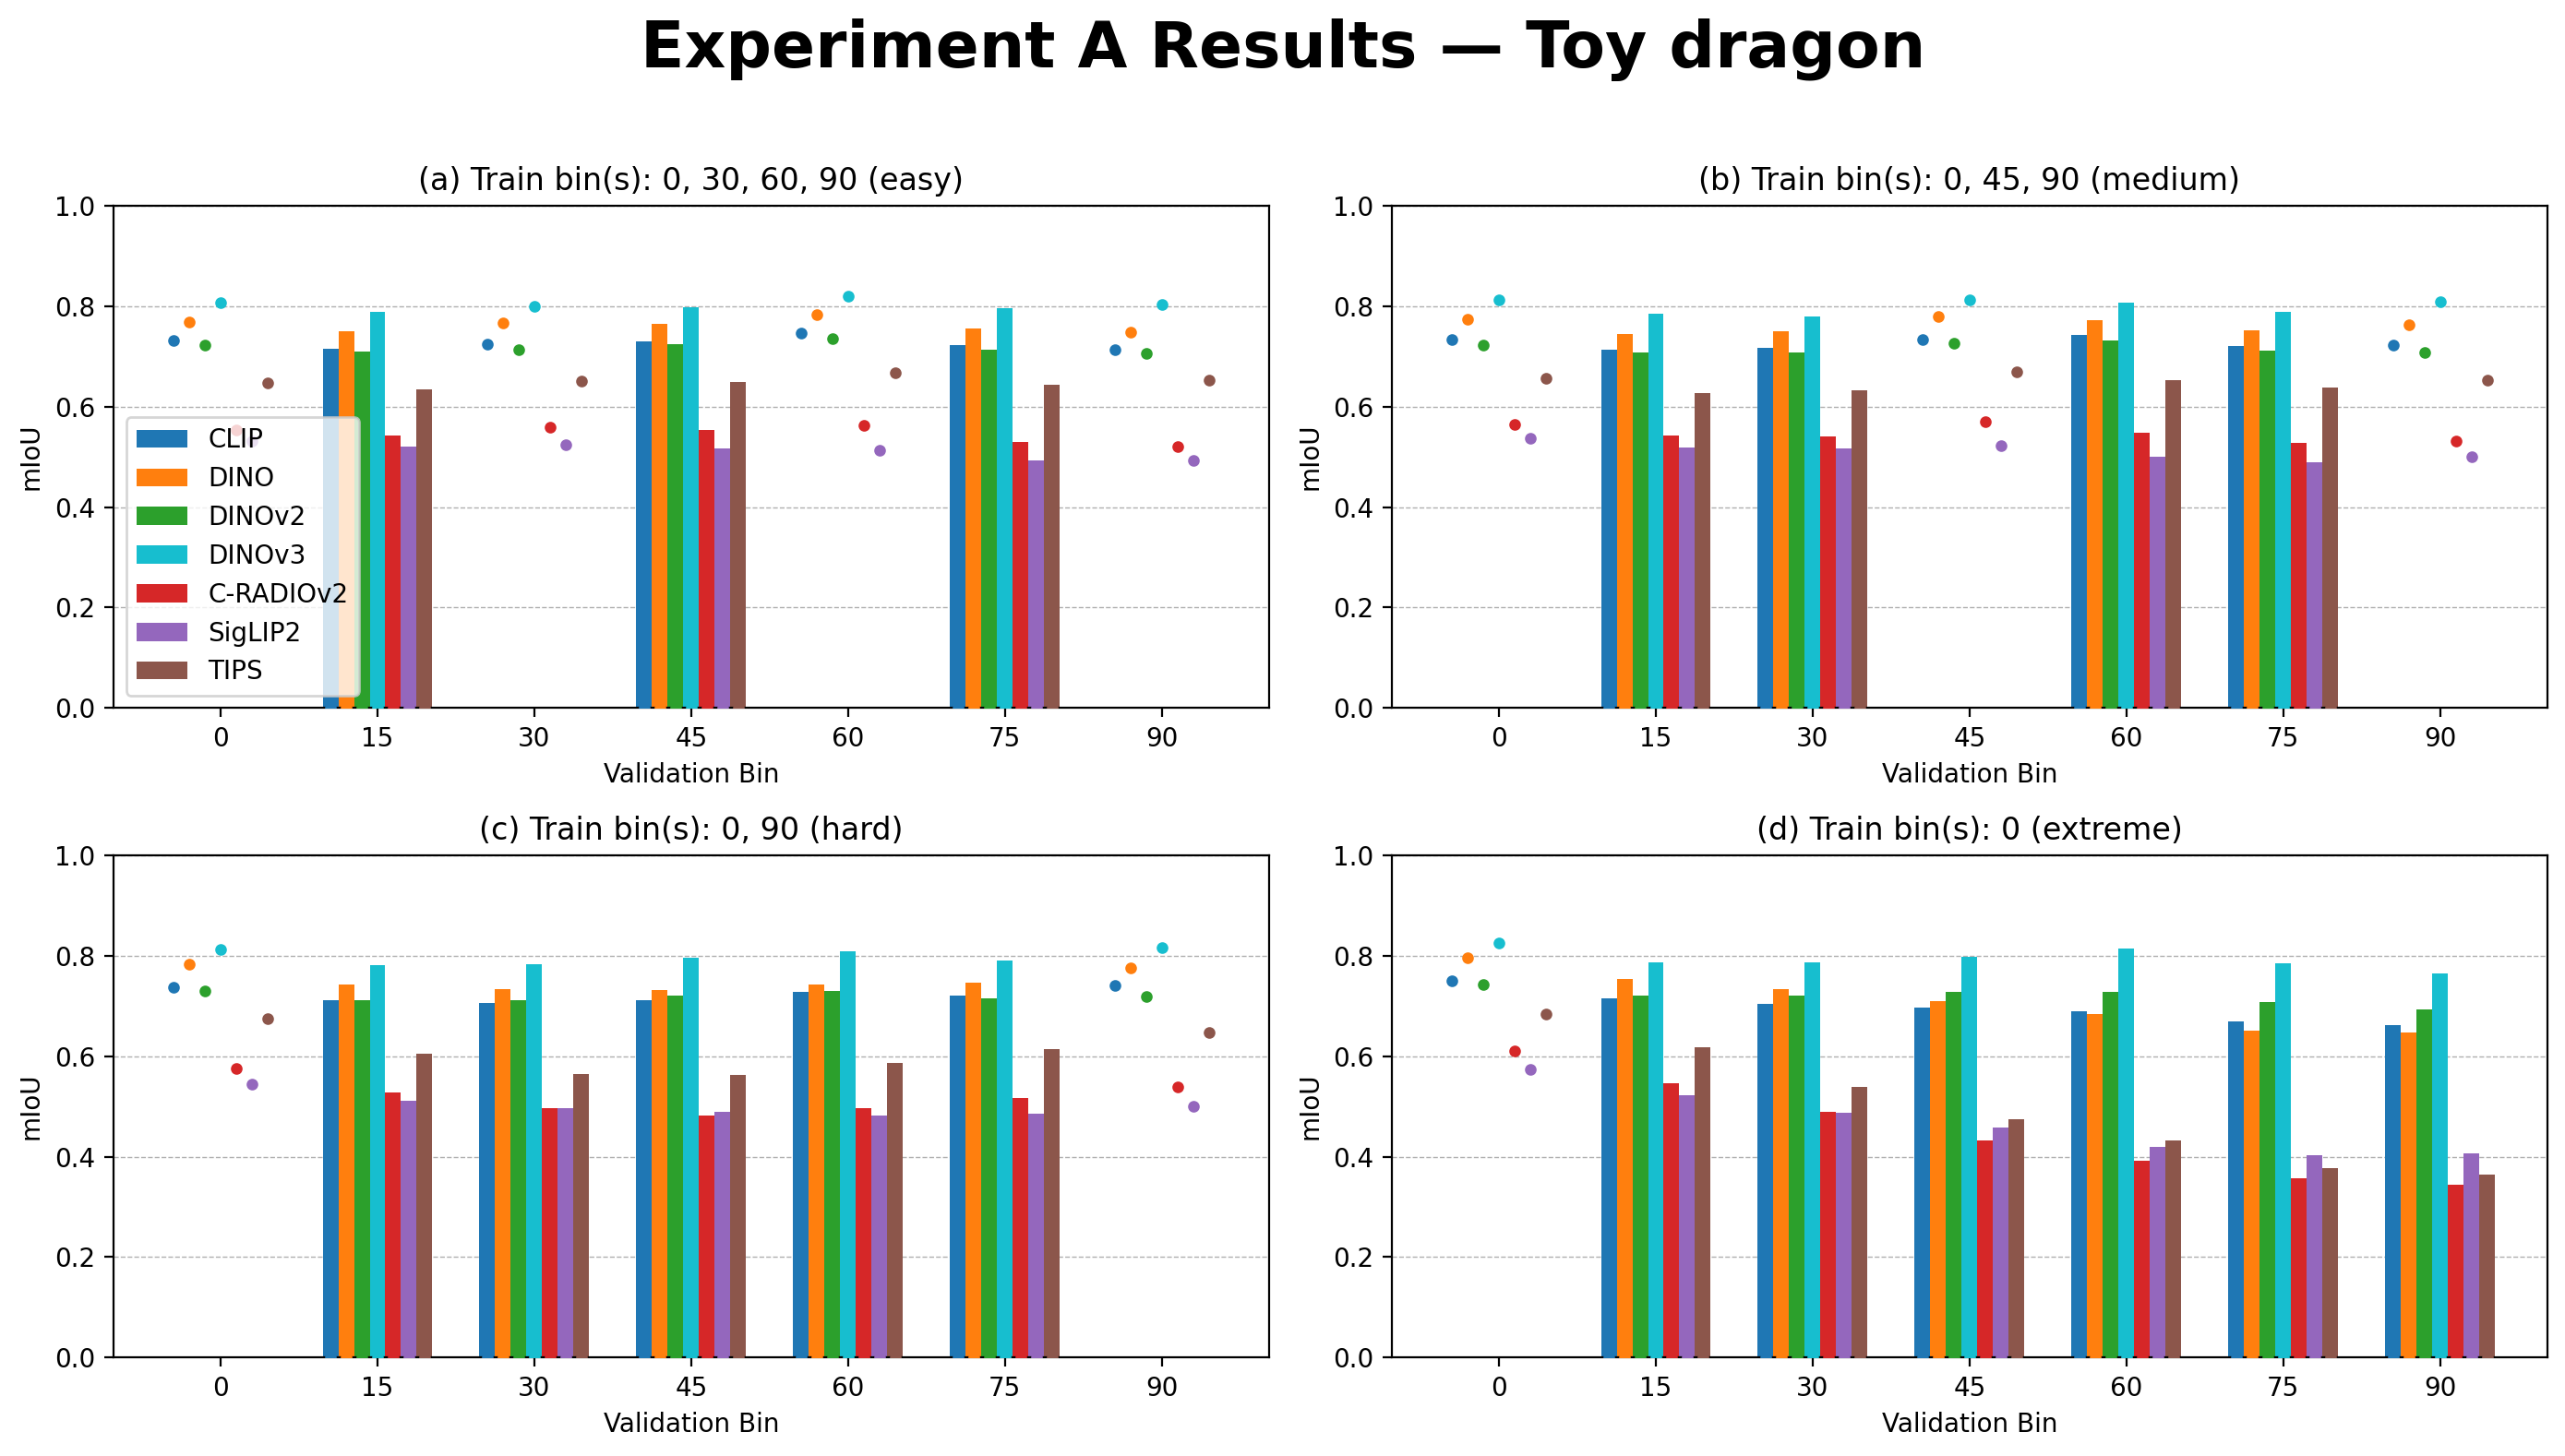

Saved figure to ../images/figures/8_coat_rack.png


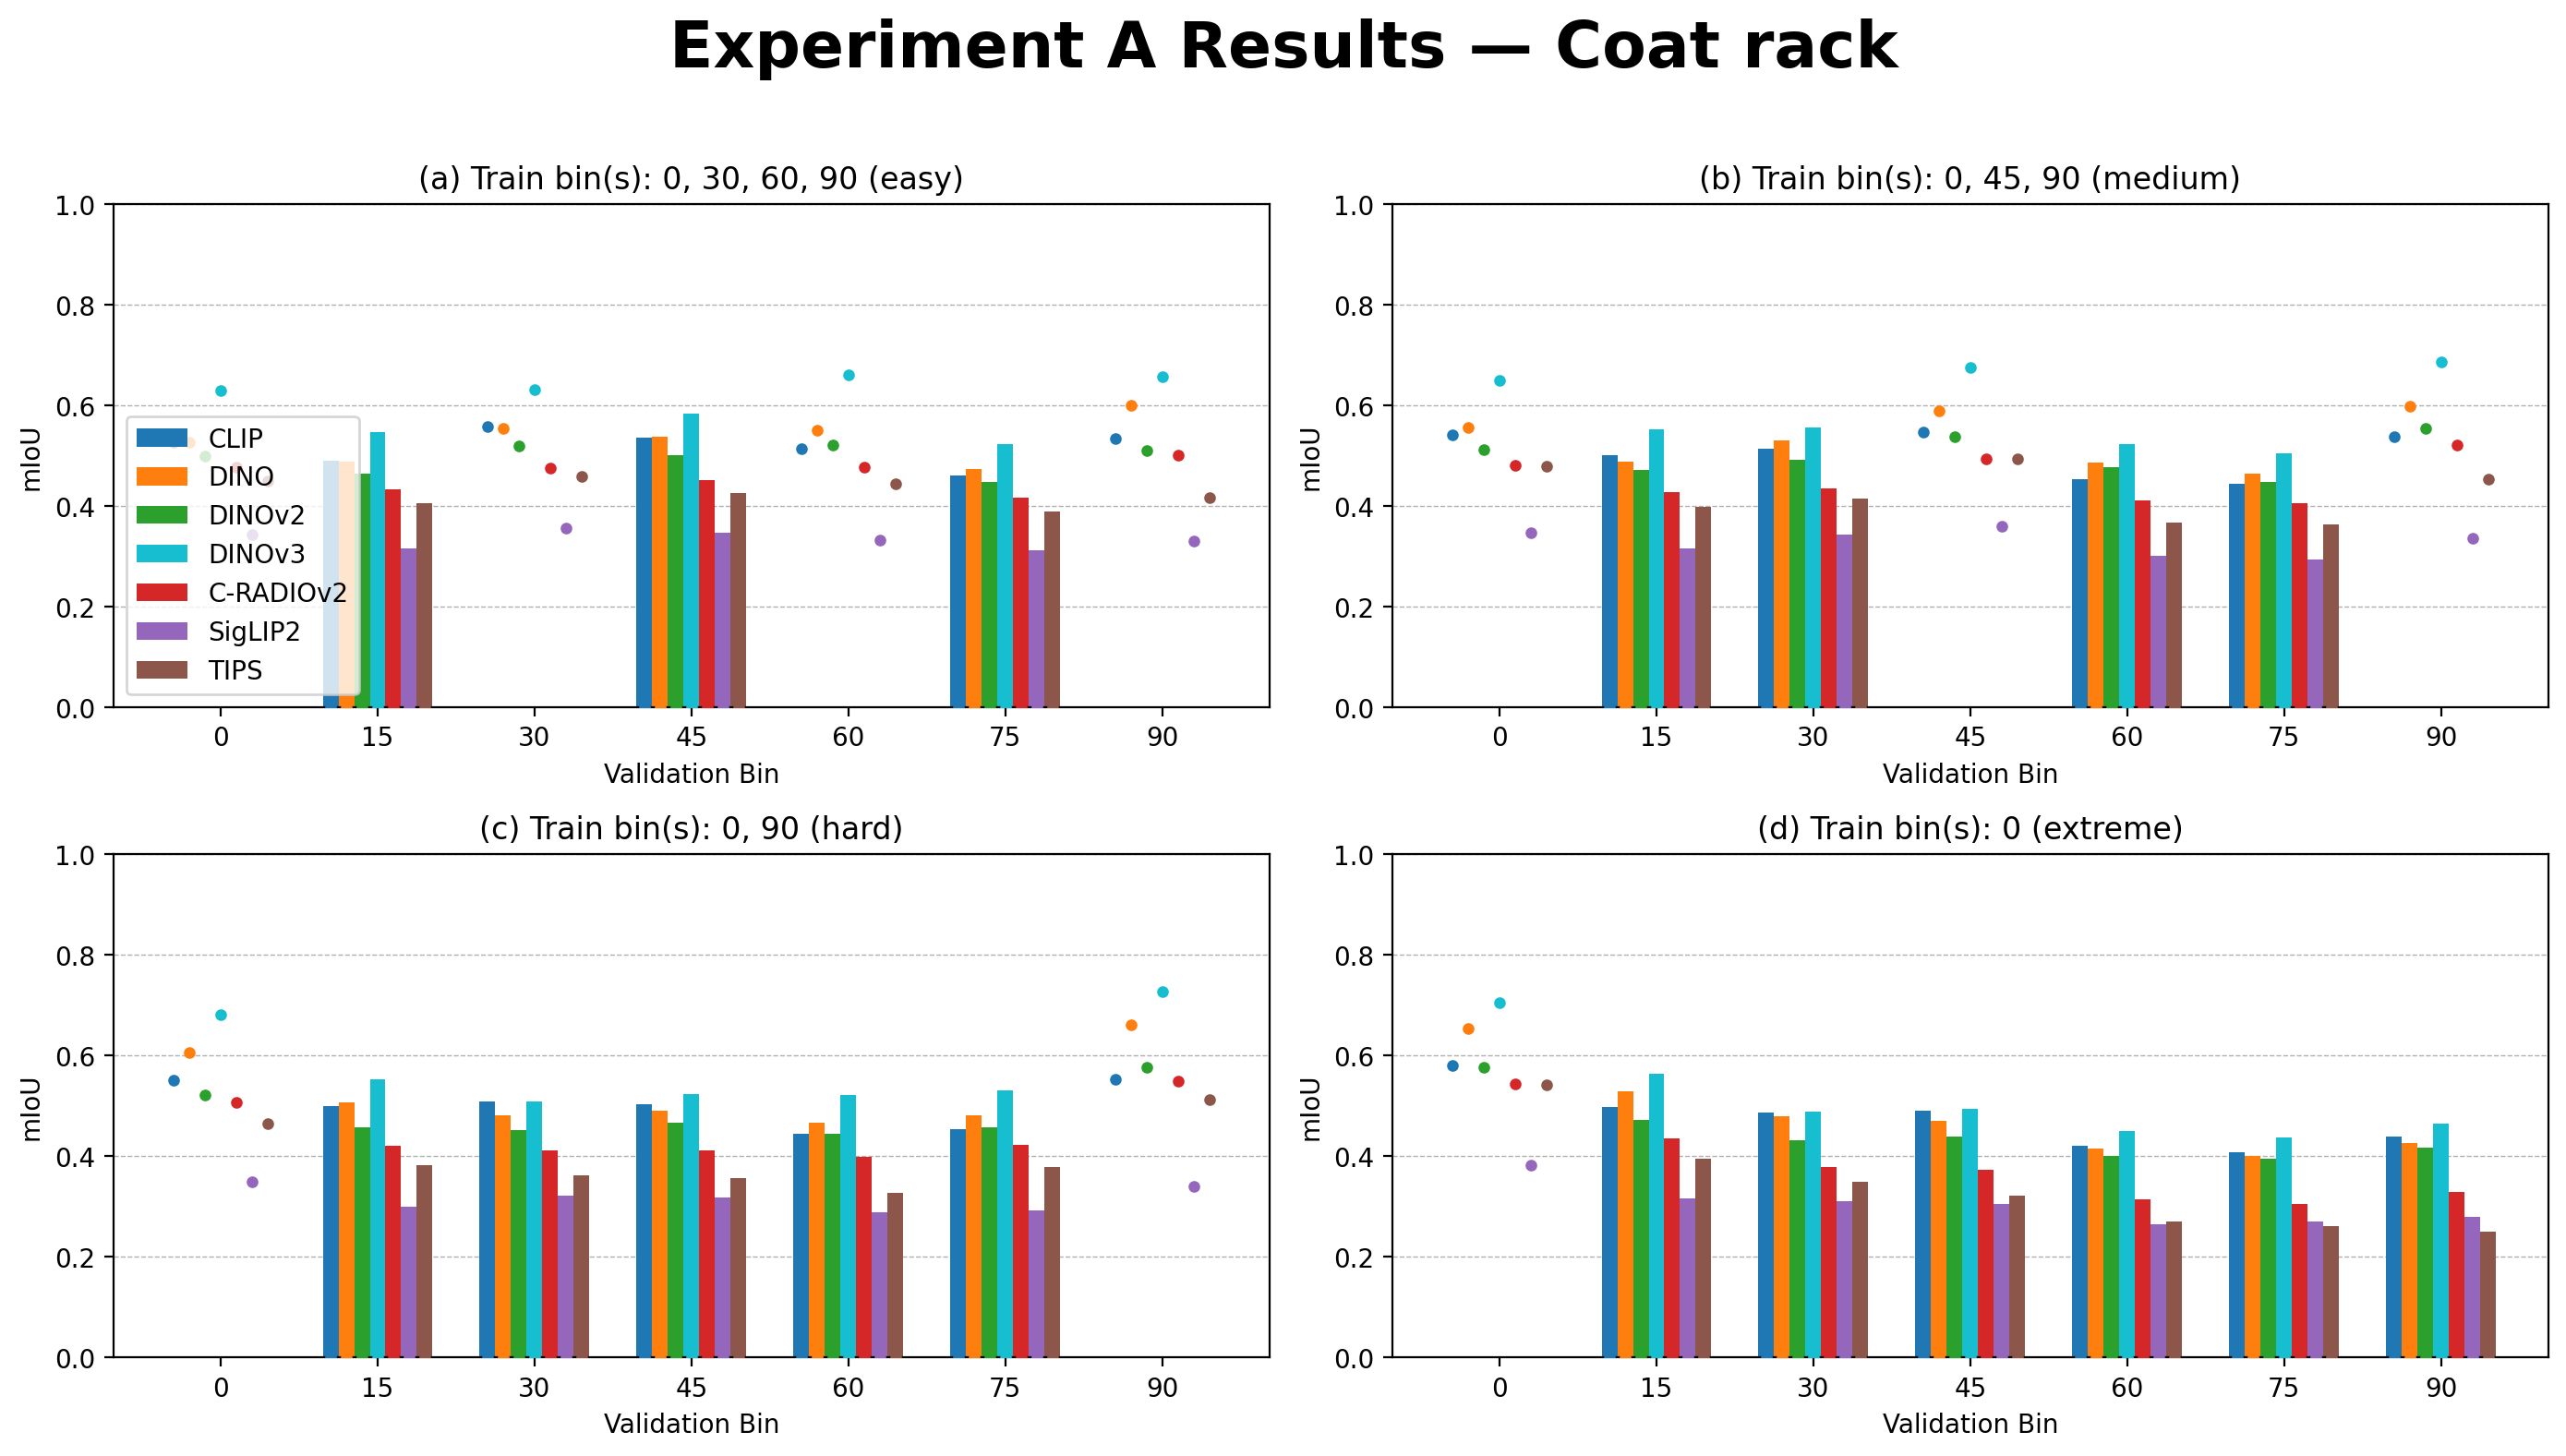

Saved figure to ../images/figures/9_guitar_stand.png


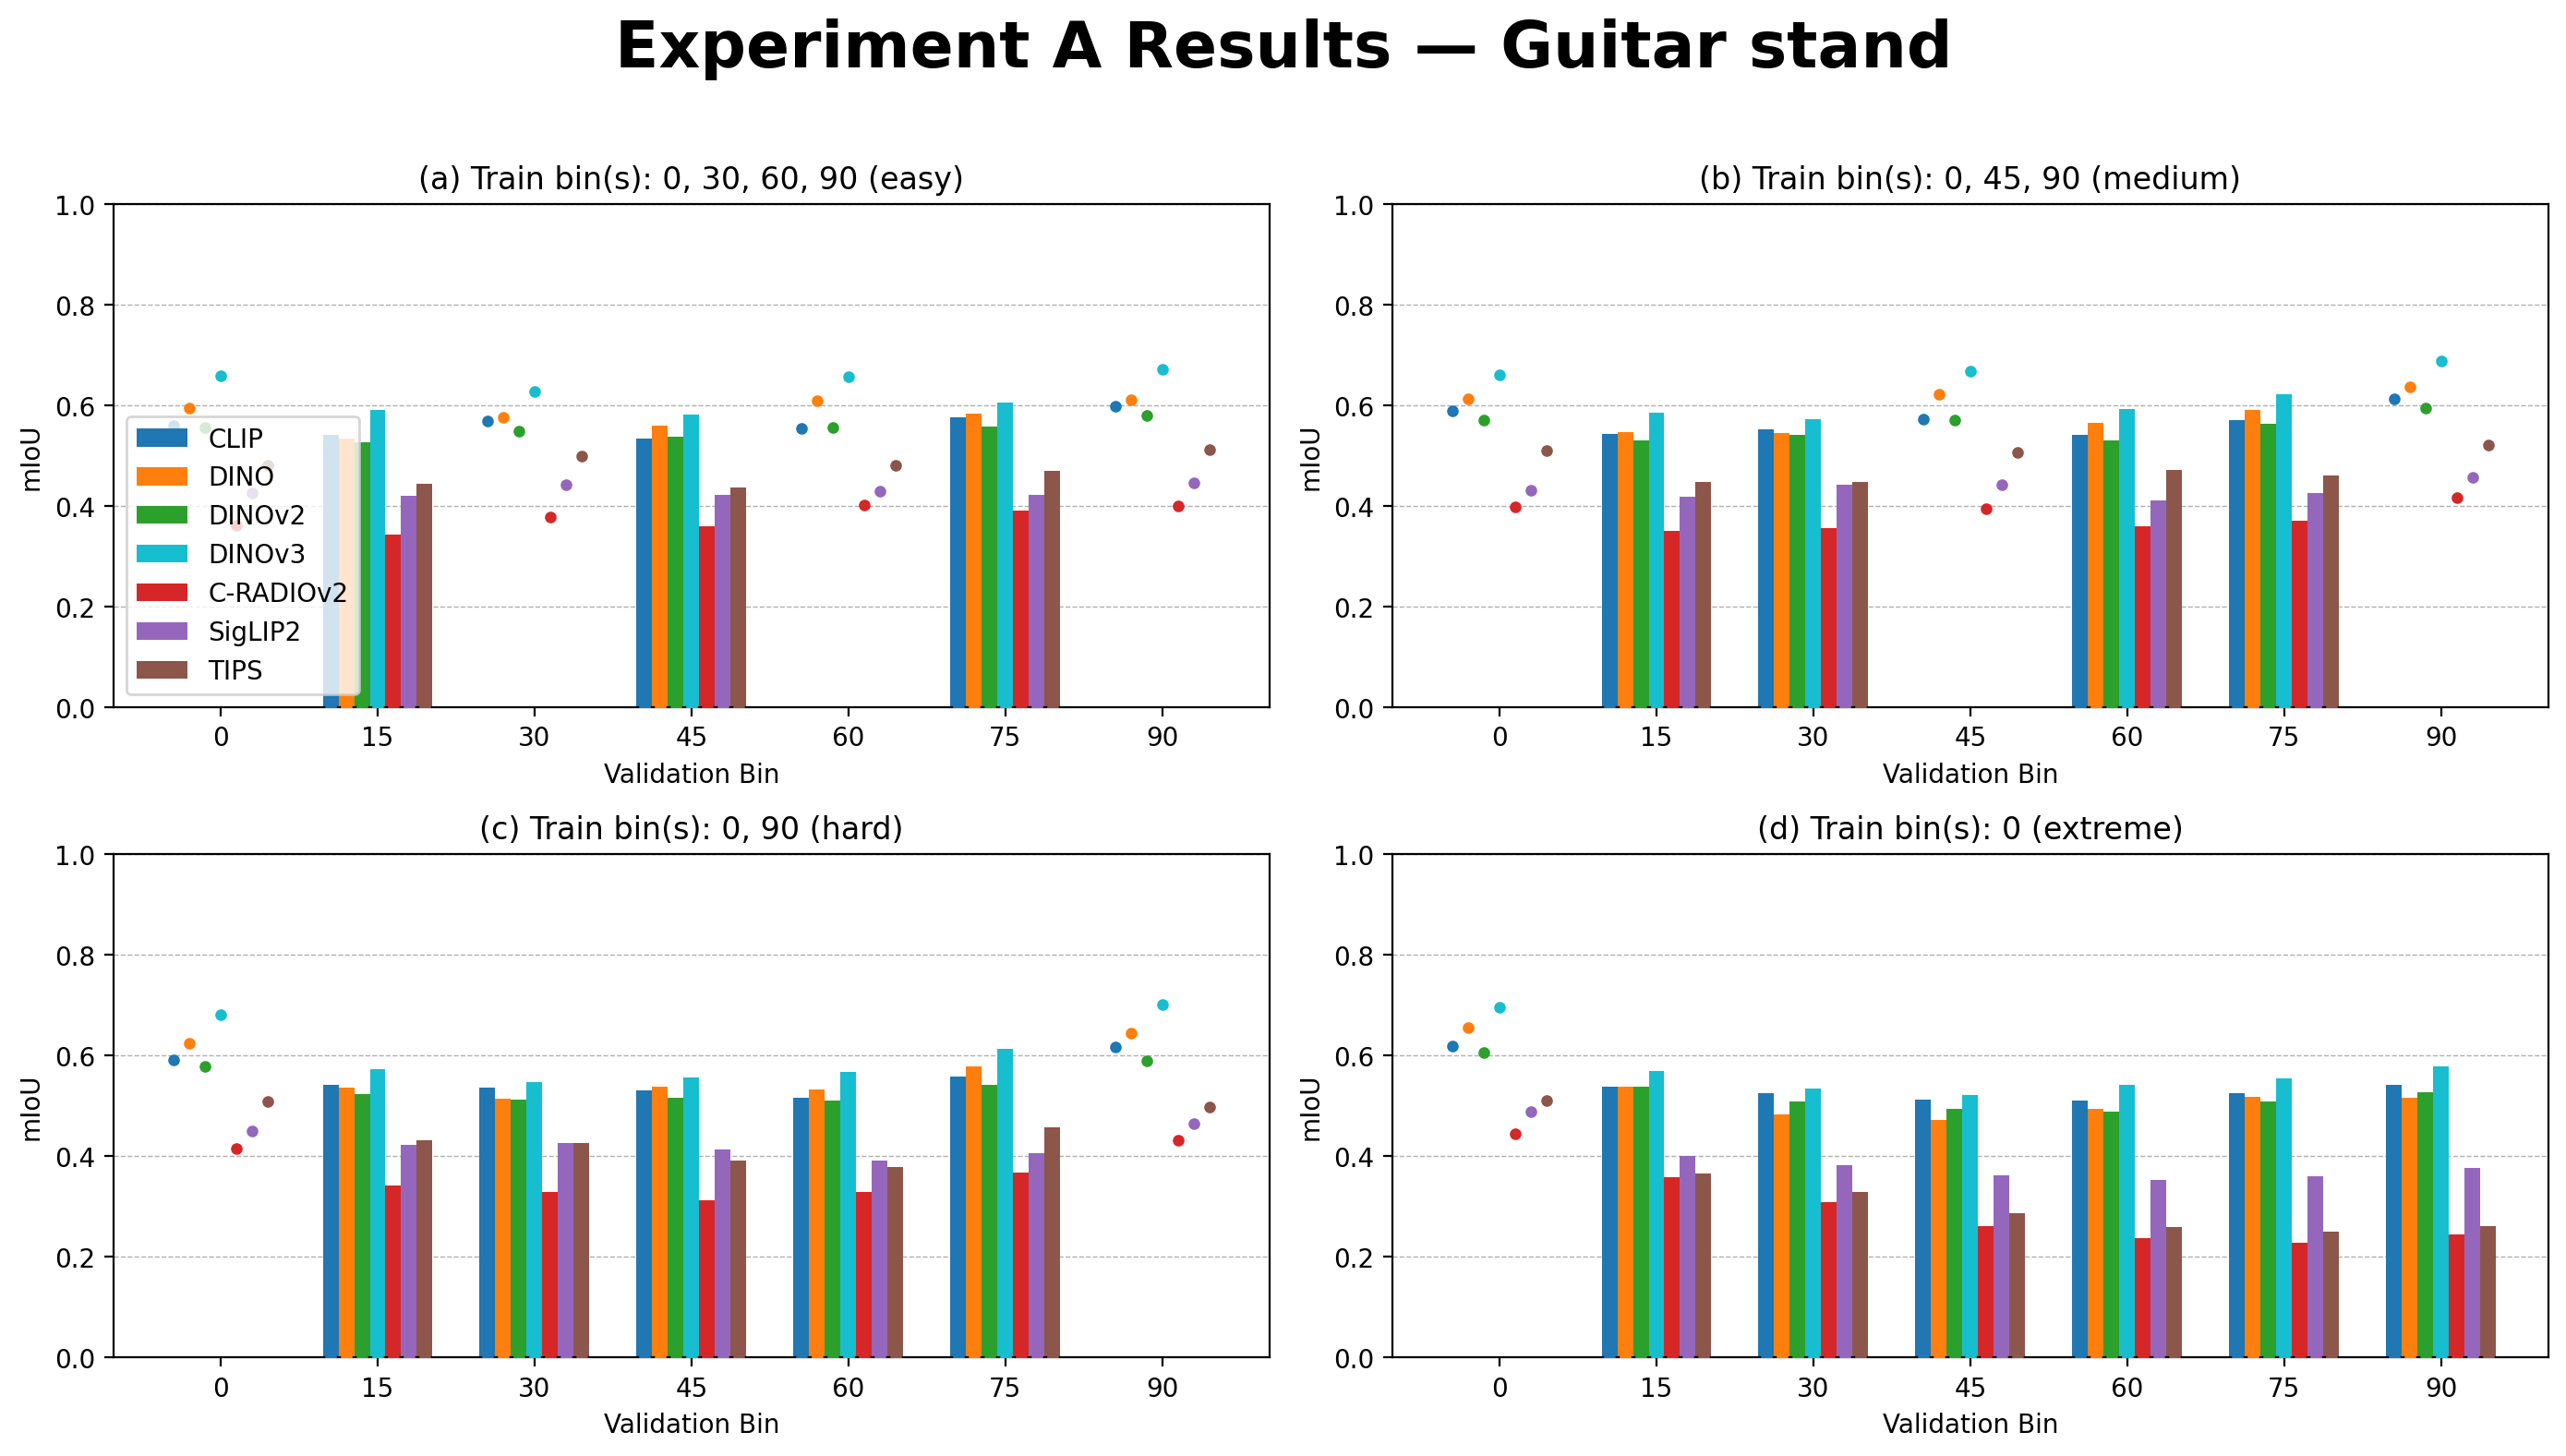

Saved figure to ../images/figures/10_ceiling_lamp.png


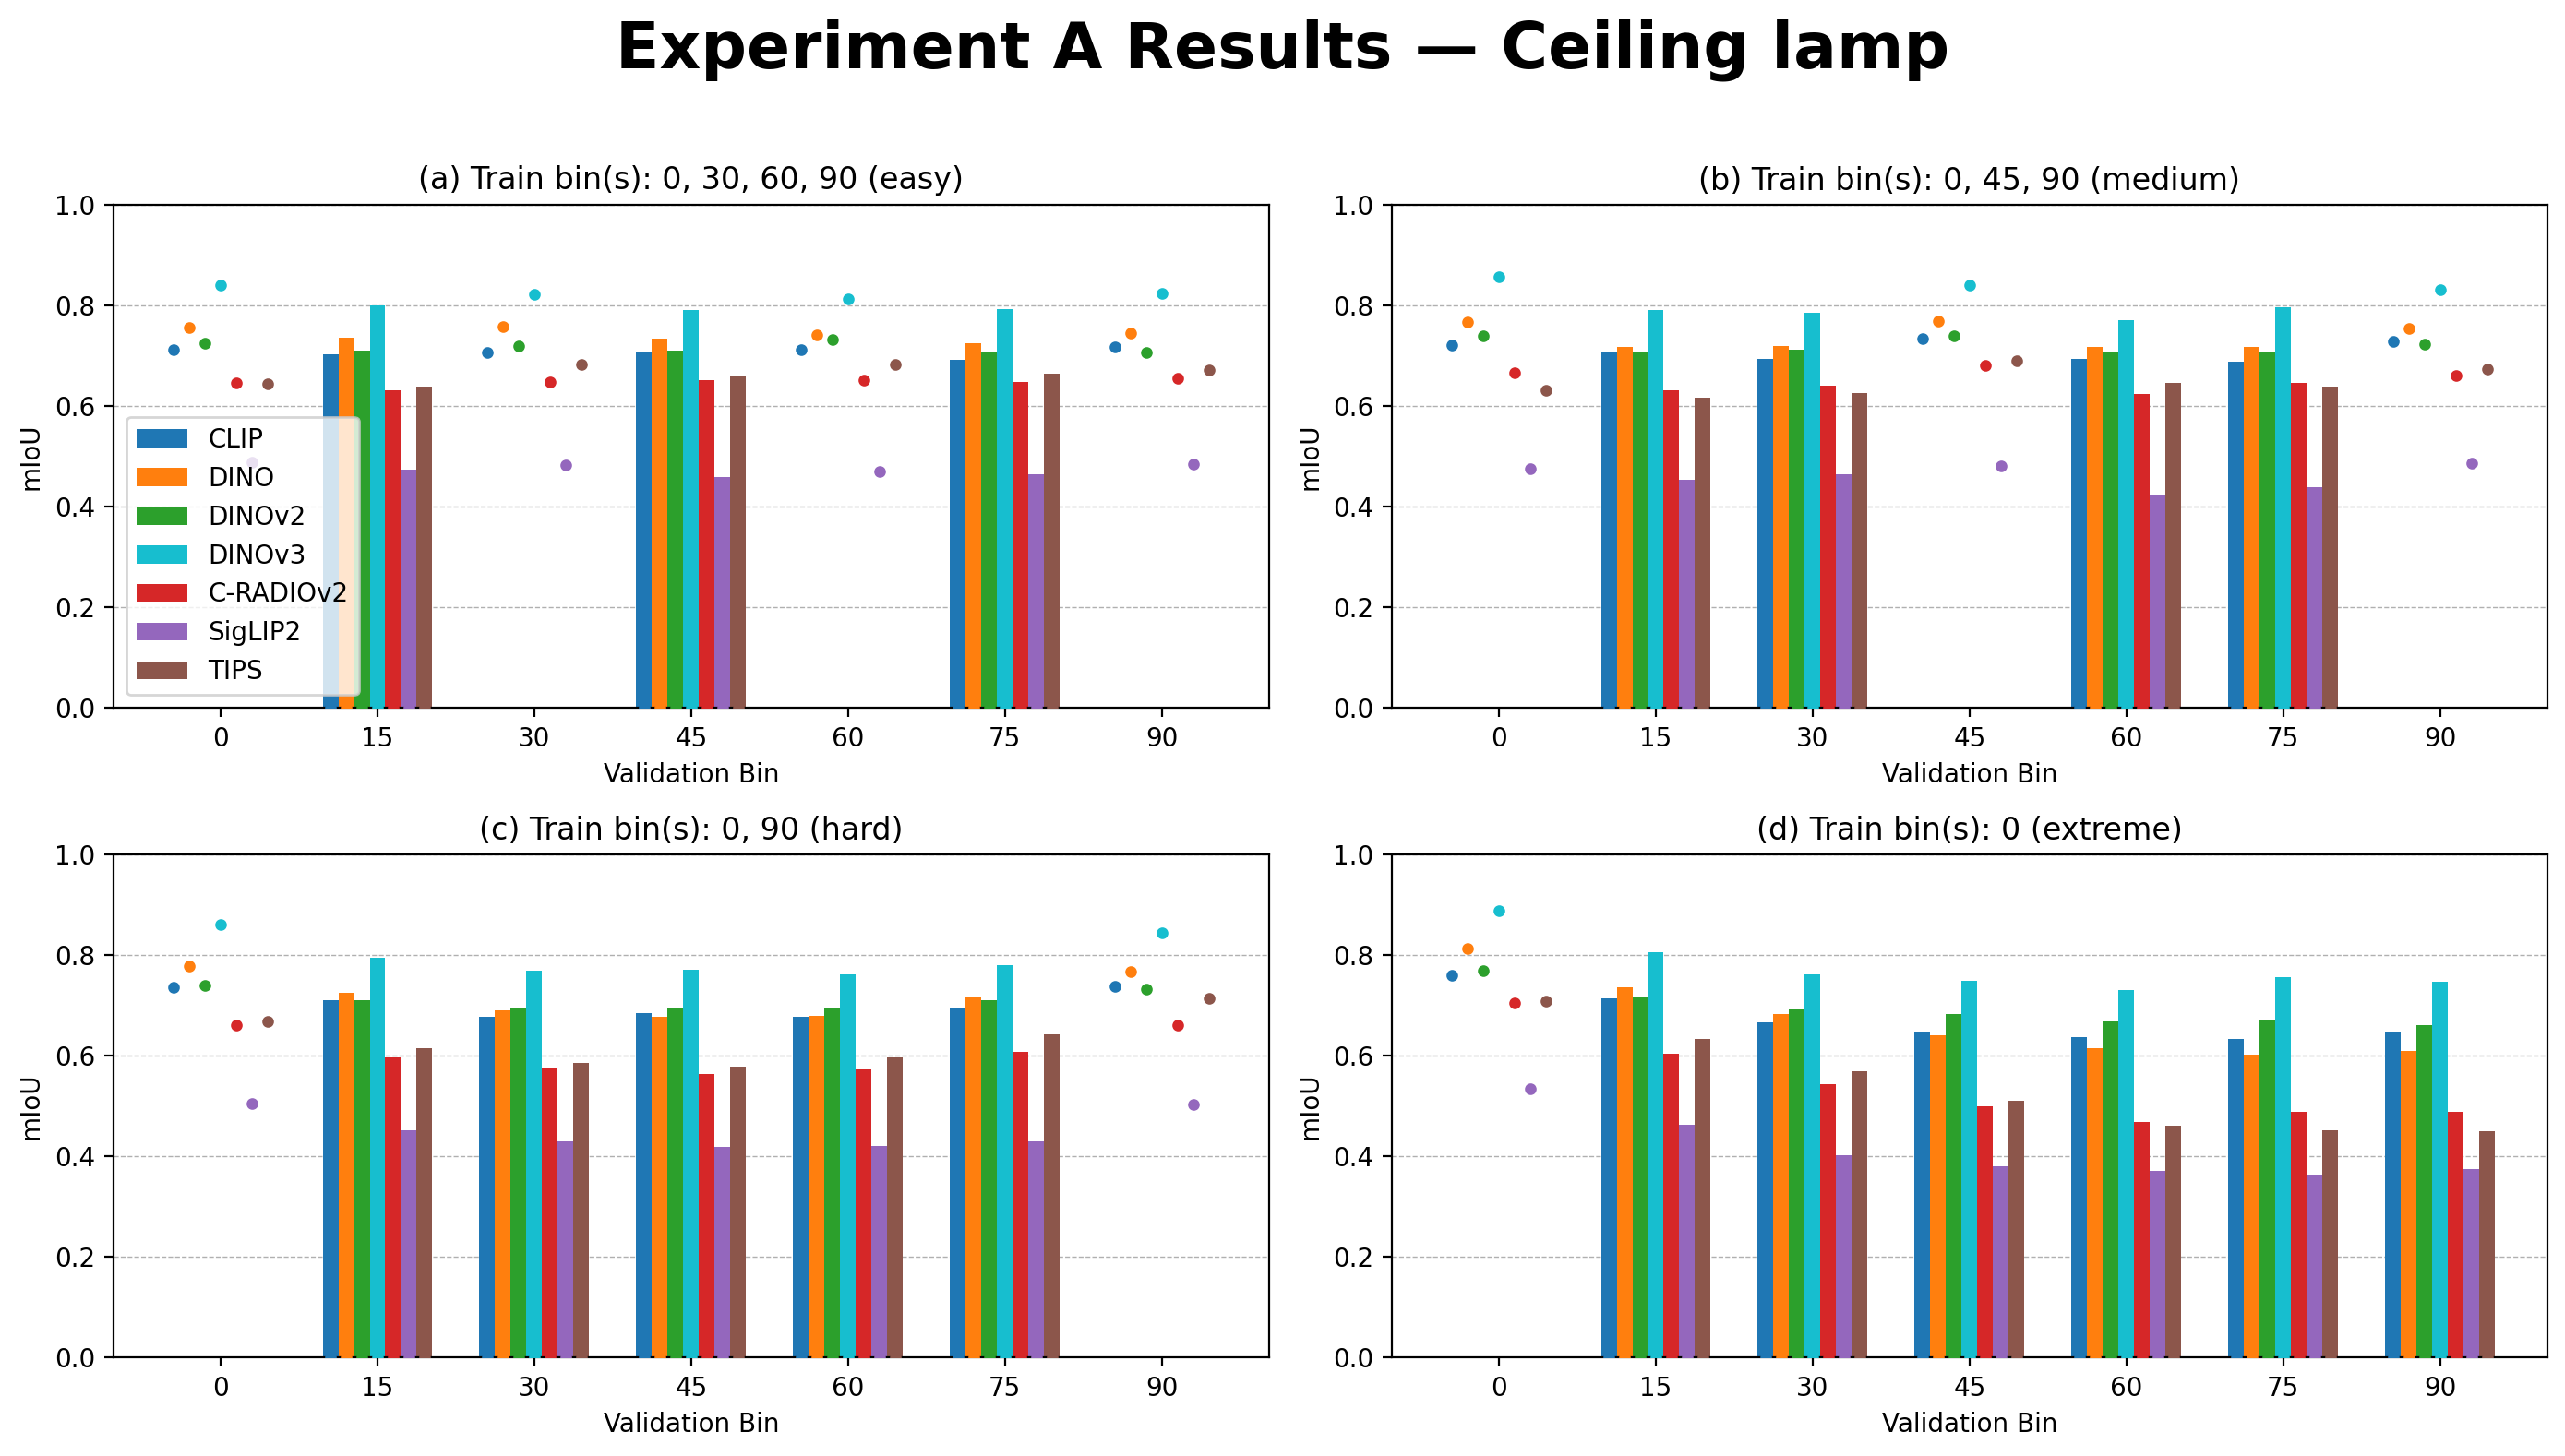

Saved figure to ../images/figures/11_toilet.png


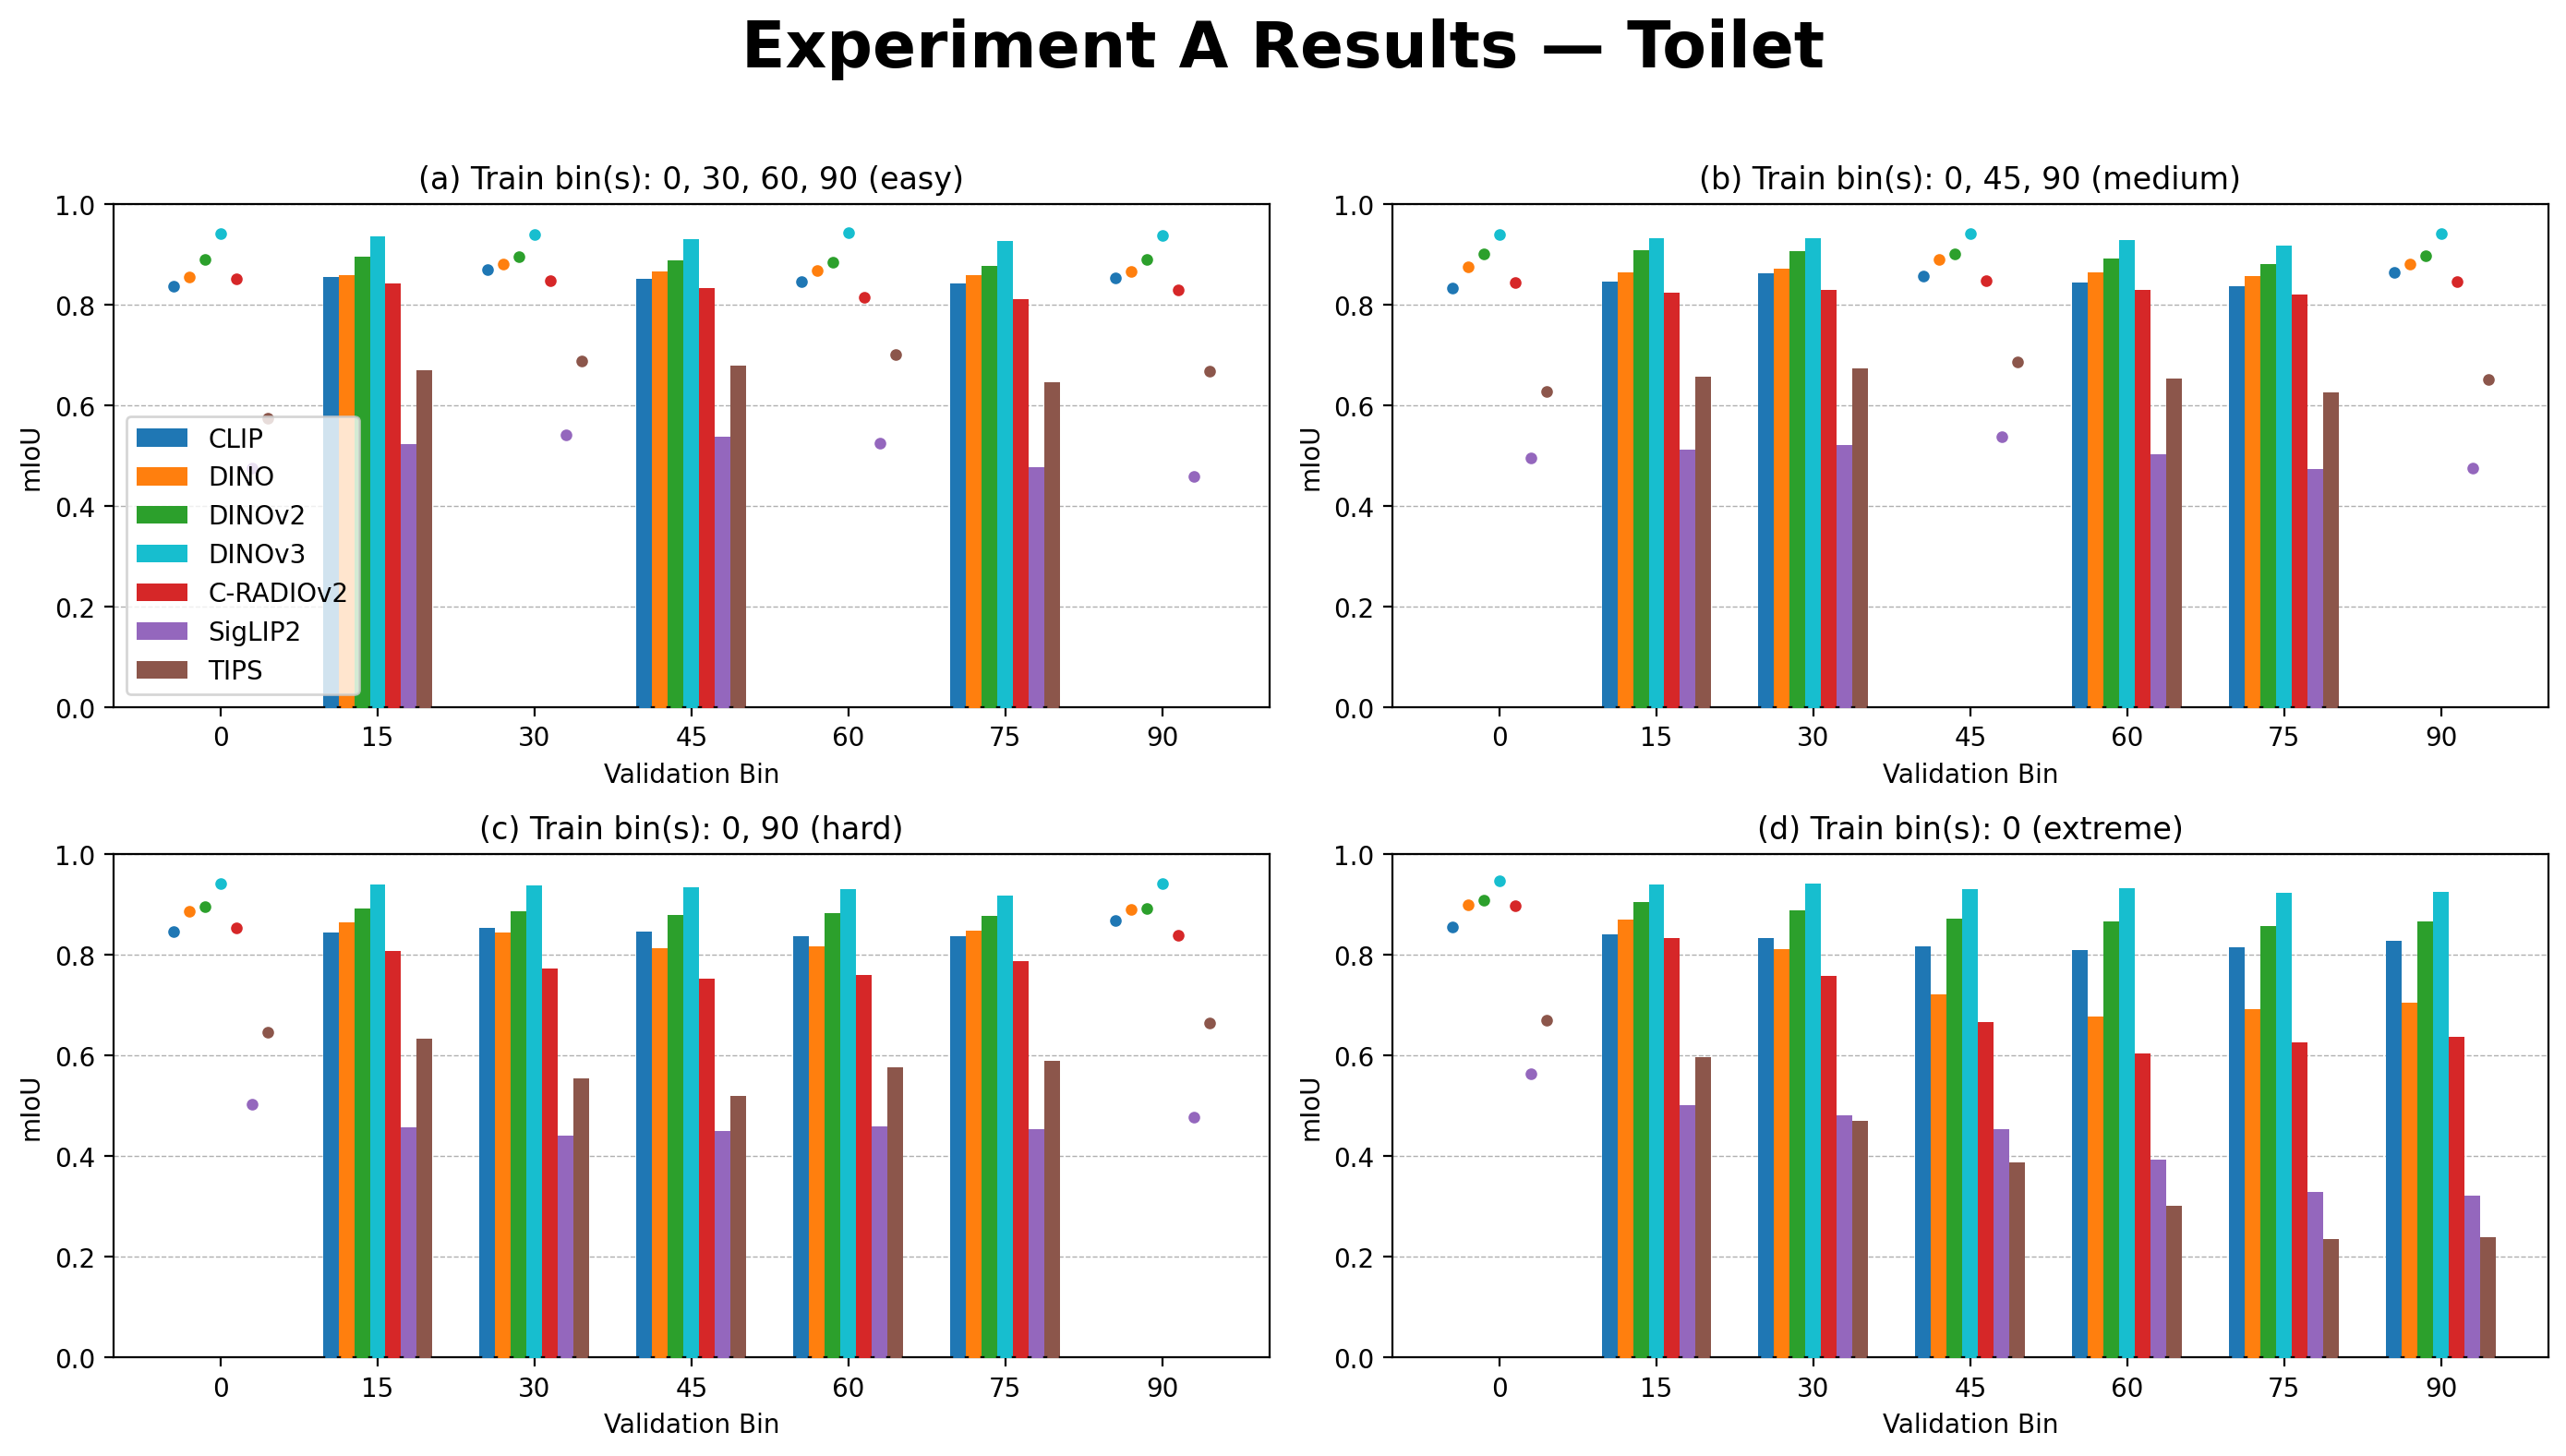

Saved figure to ../images/figures/12_sink.png


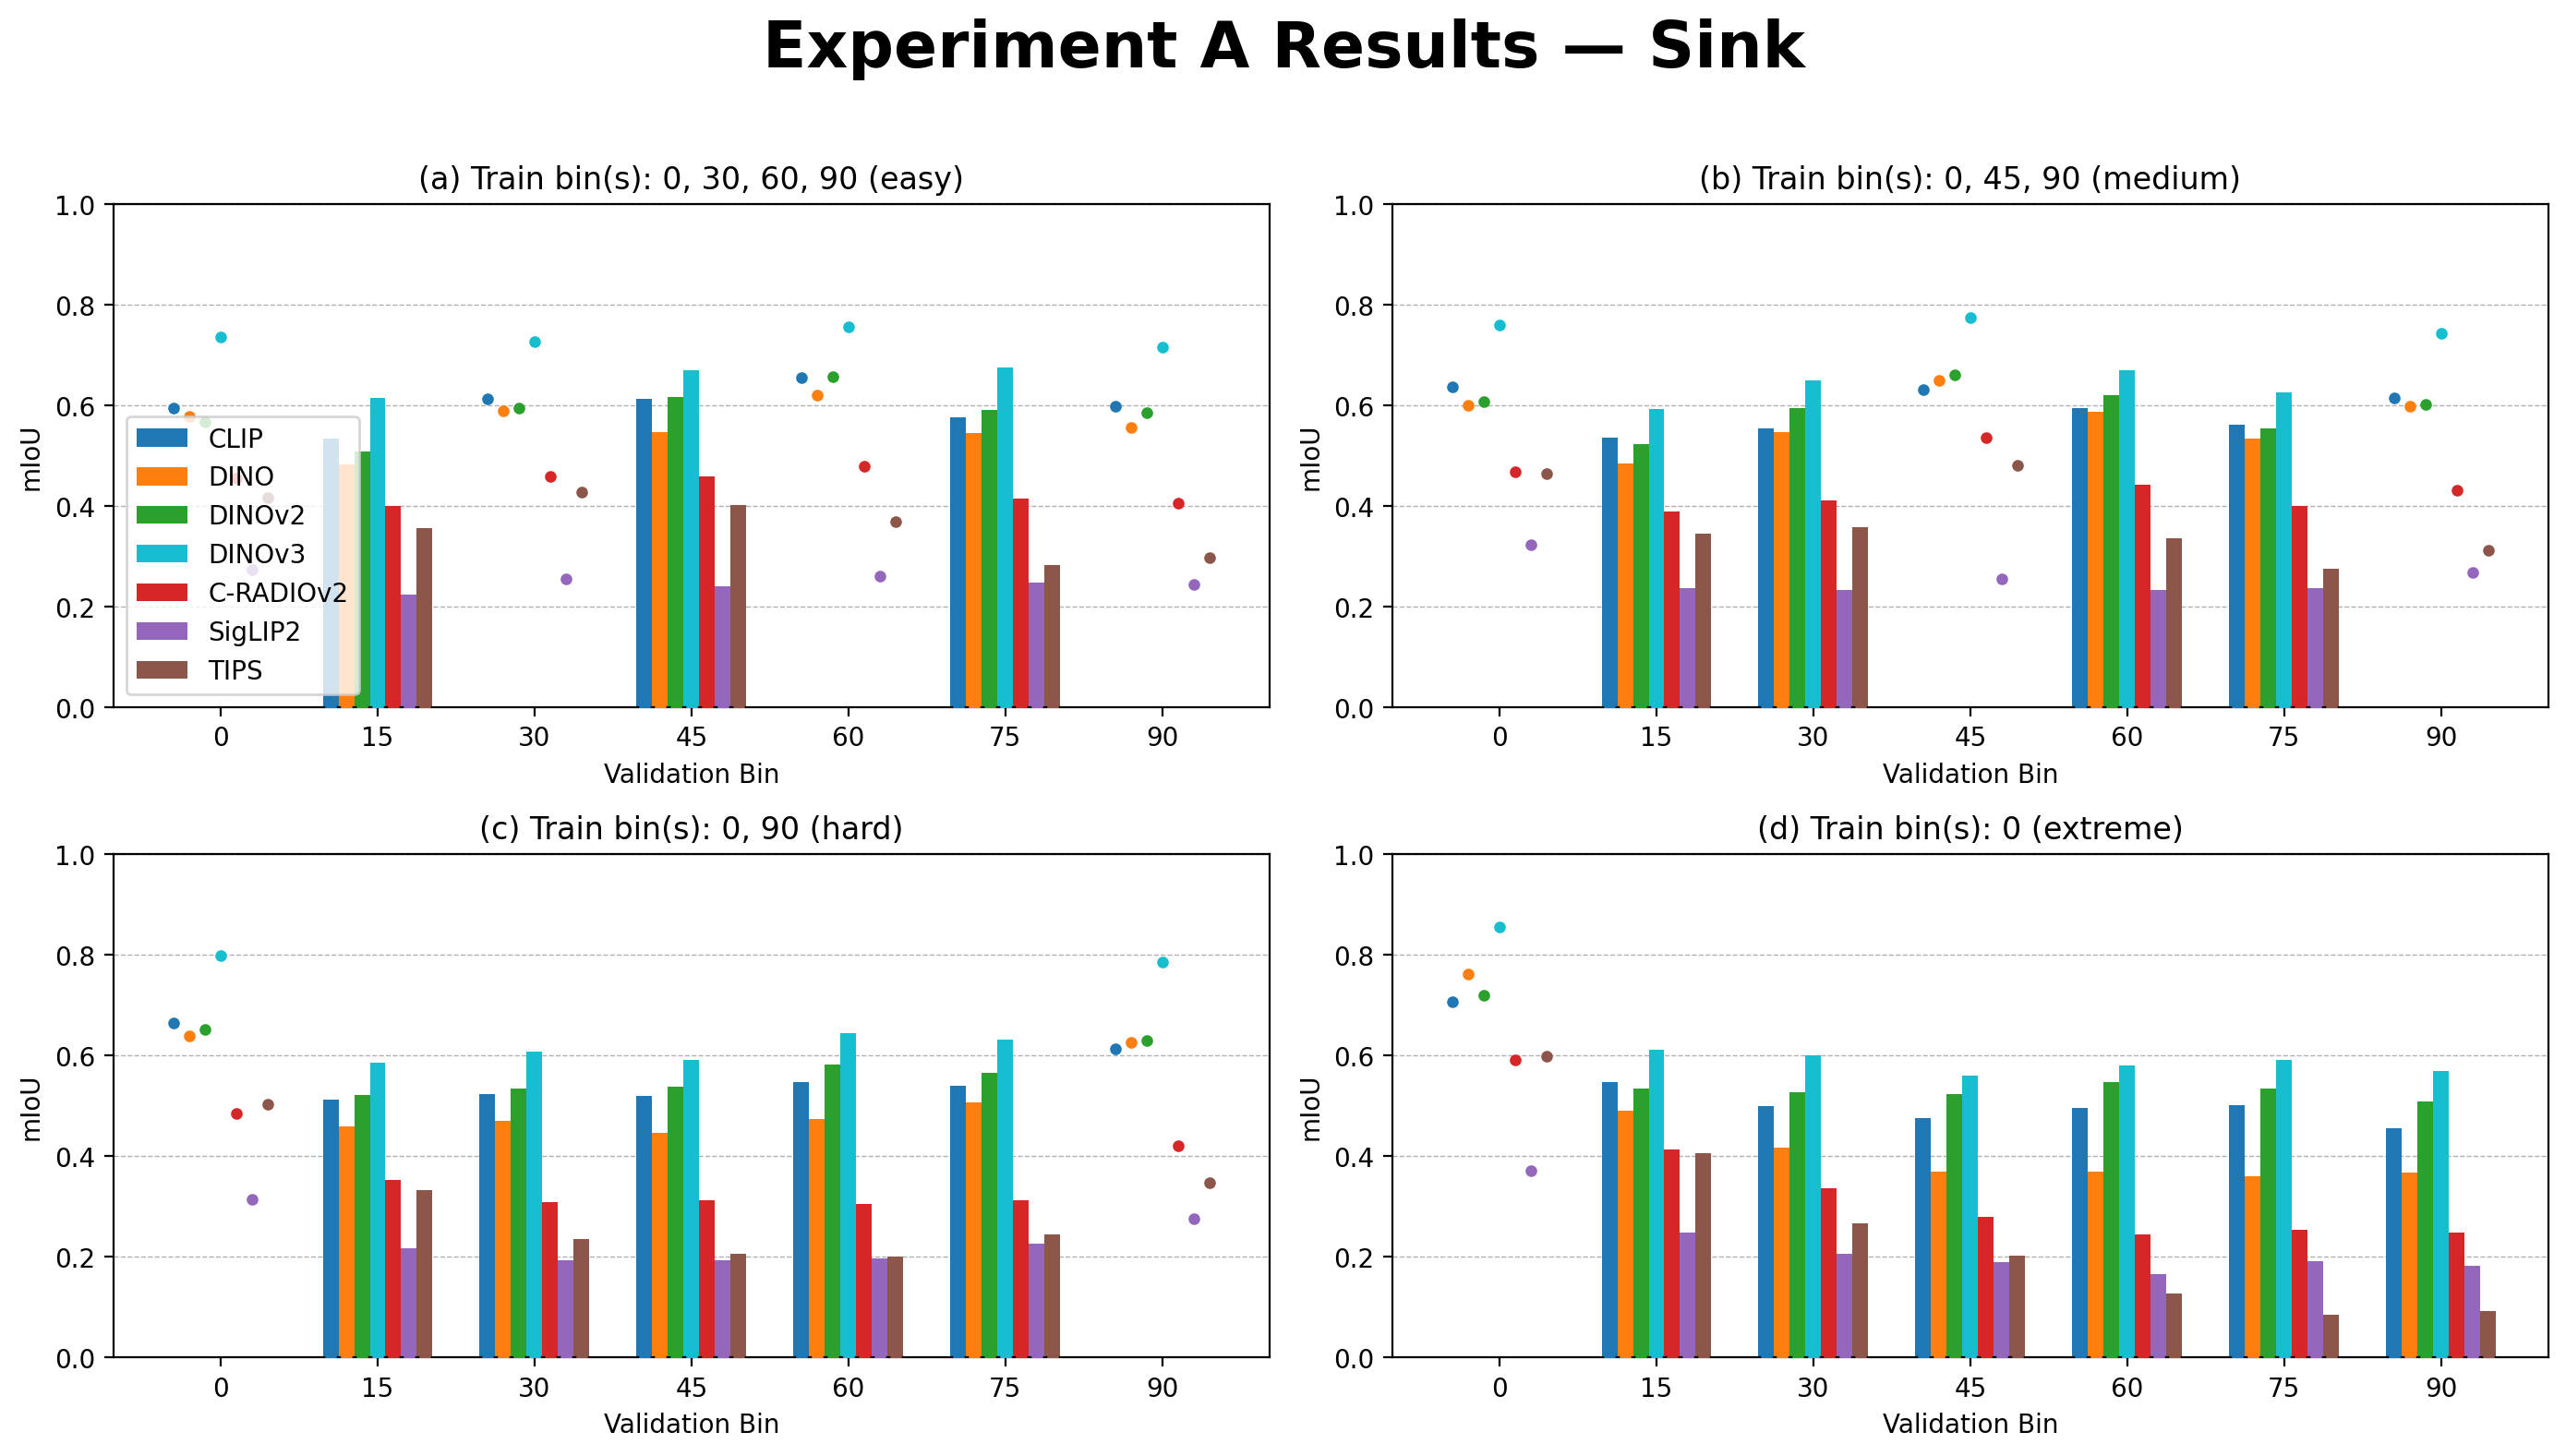

Saved figure to ../images/figures/13_strings.png


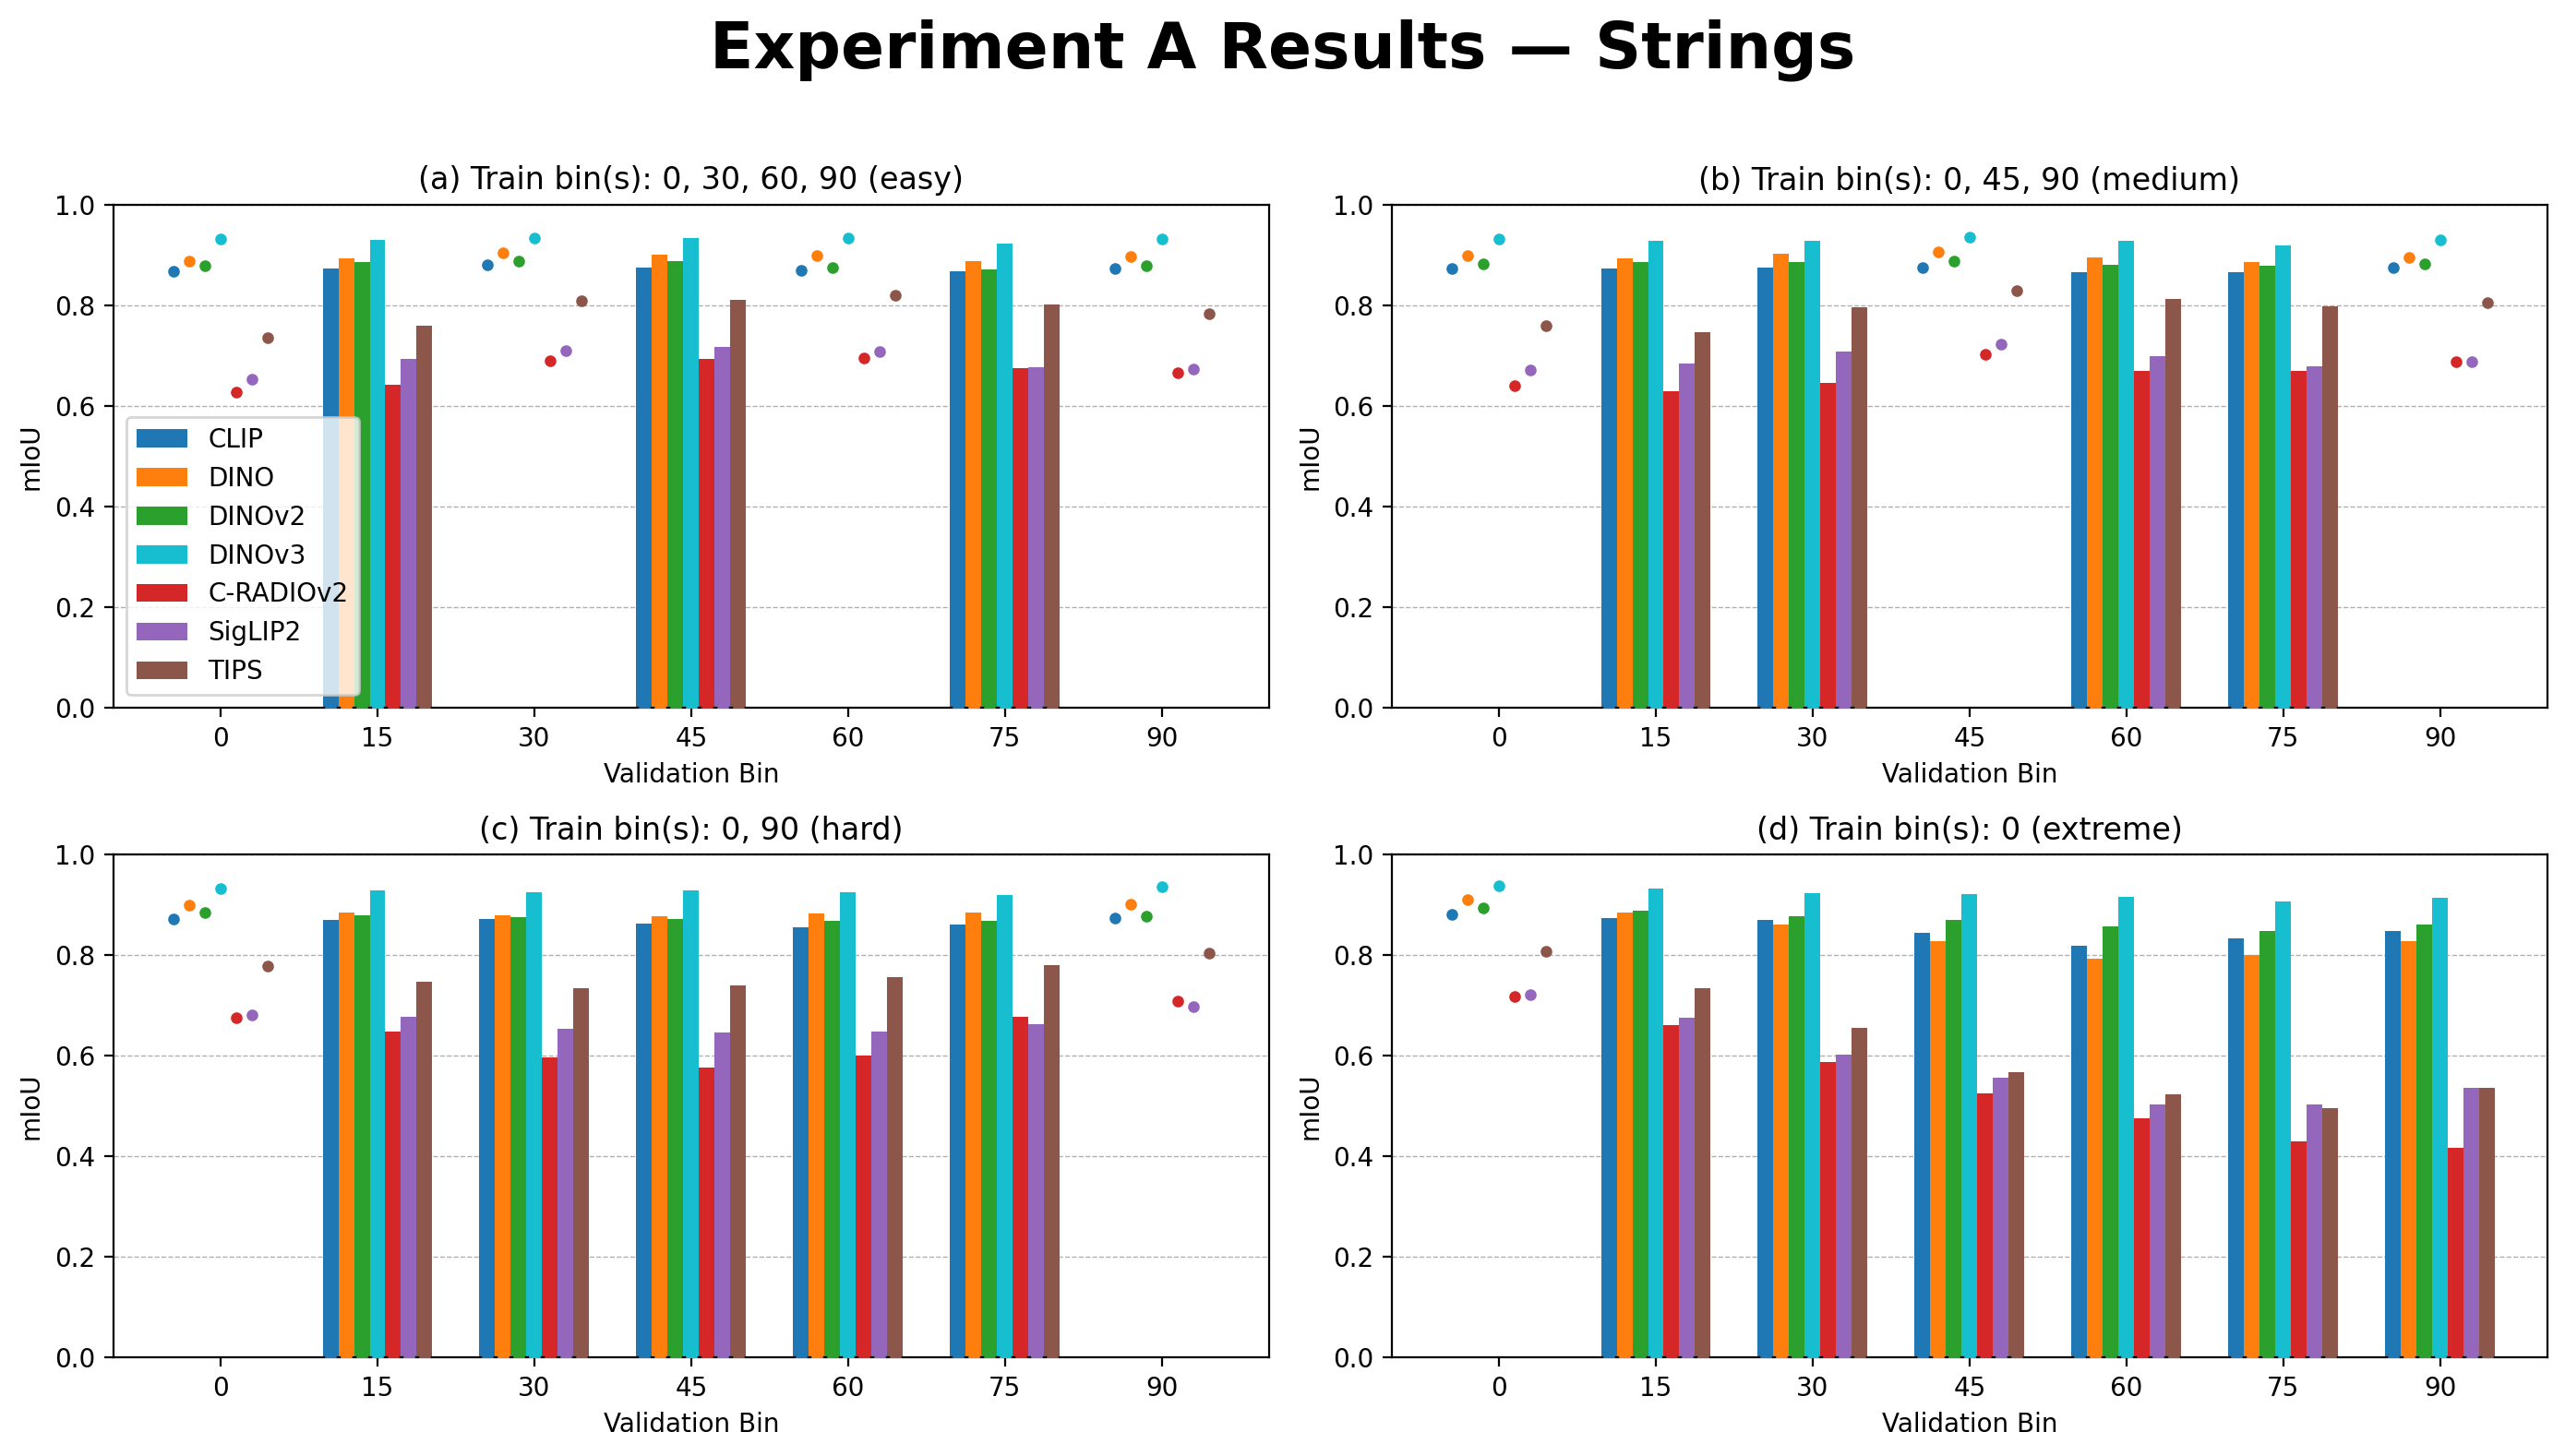

Saved figure to ../images/figures/14_broccoli.png


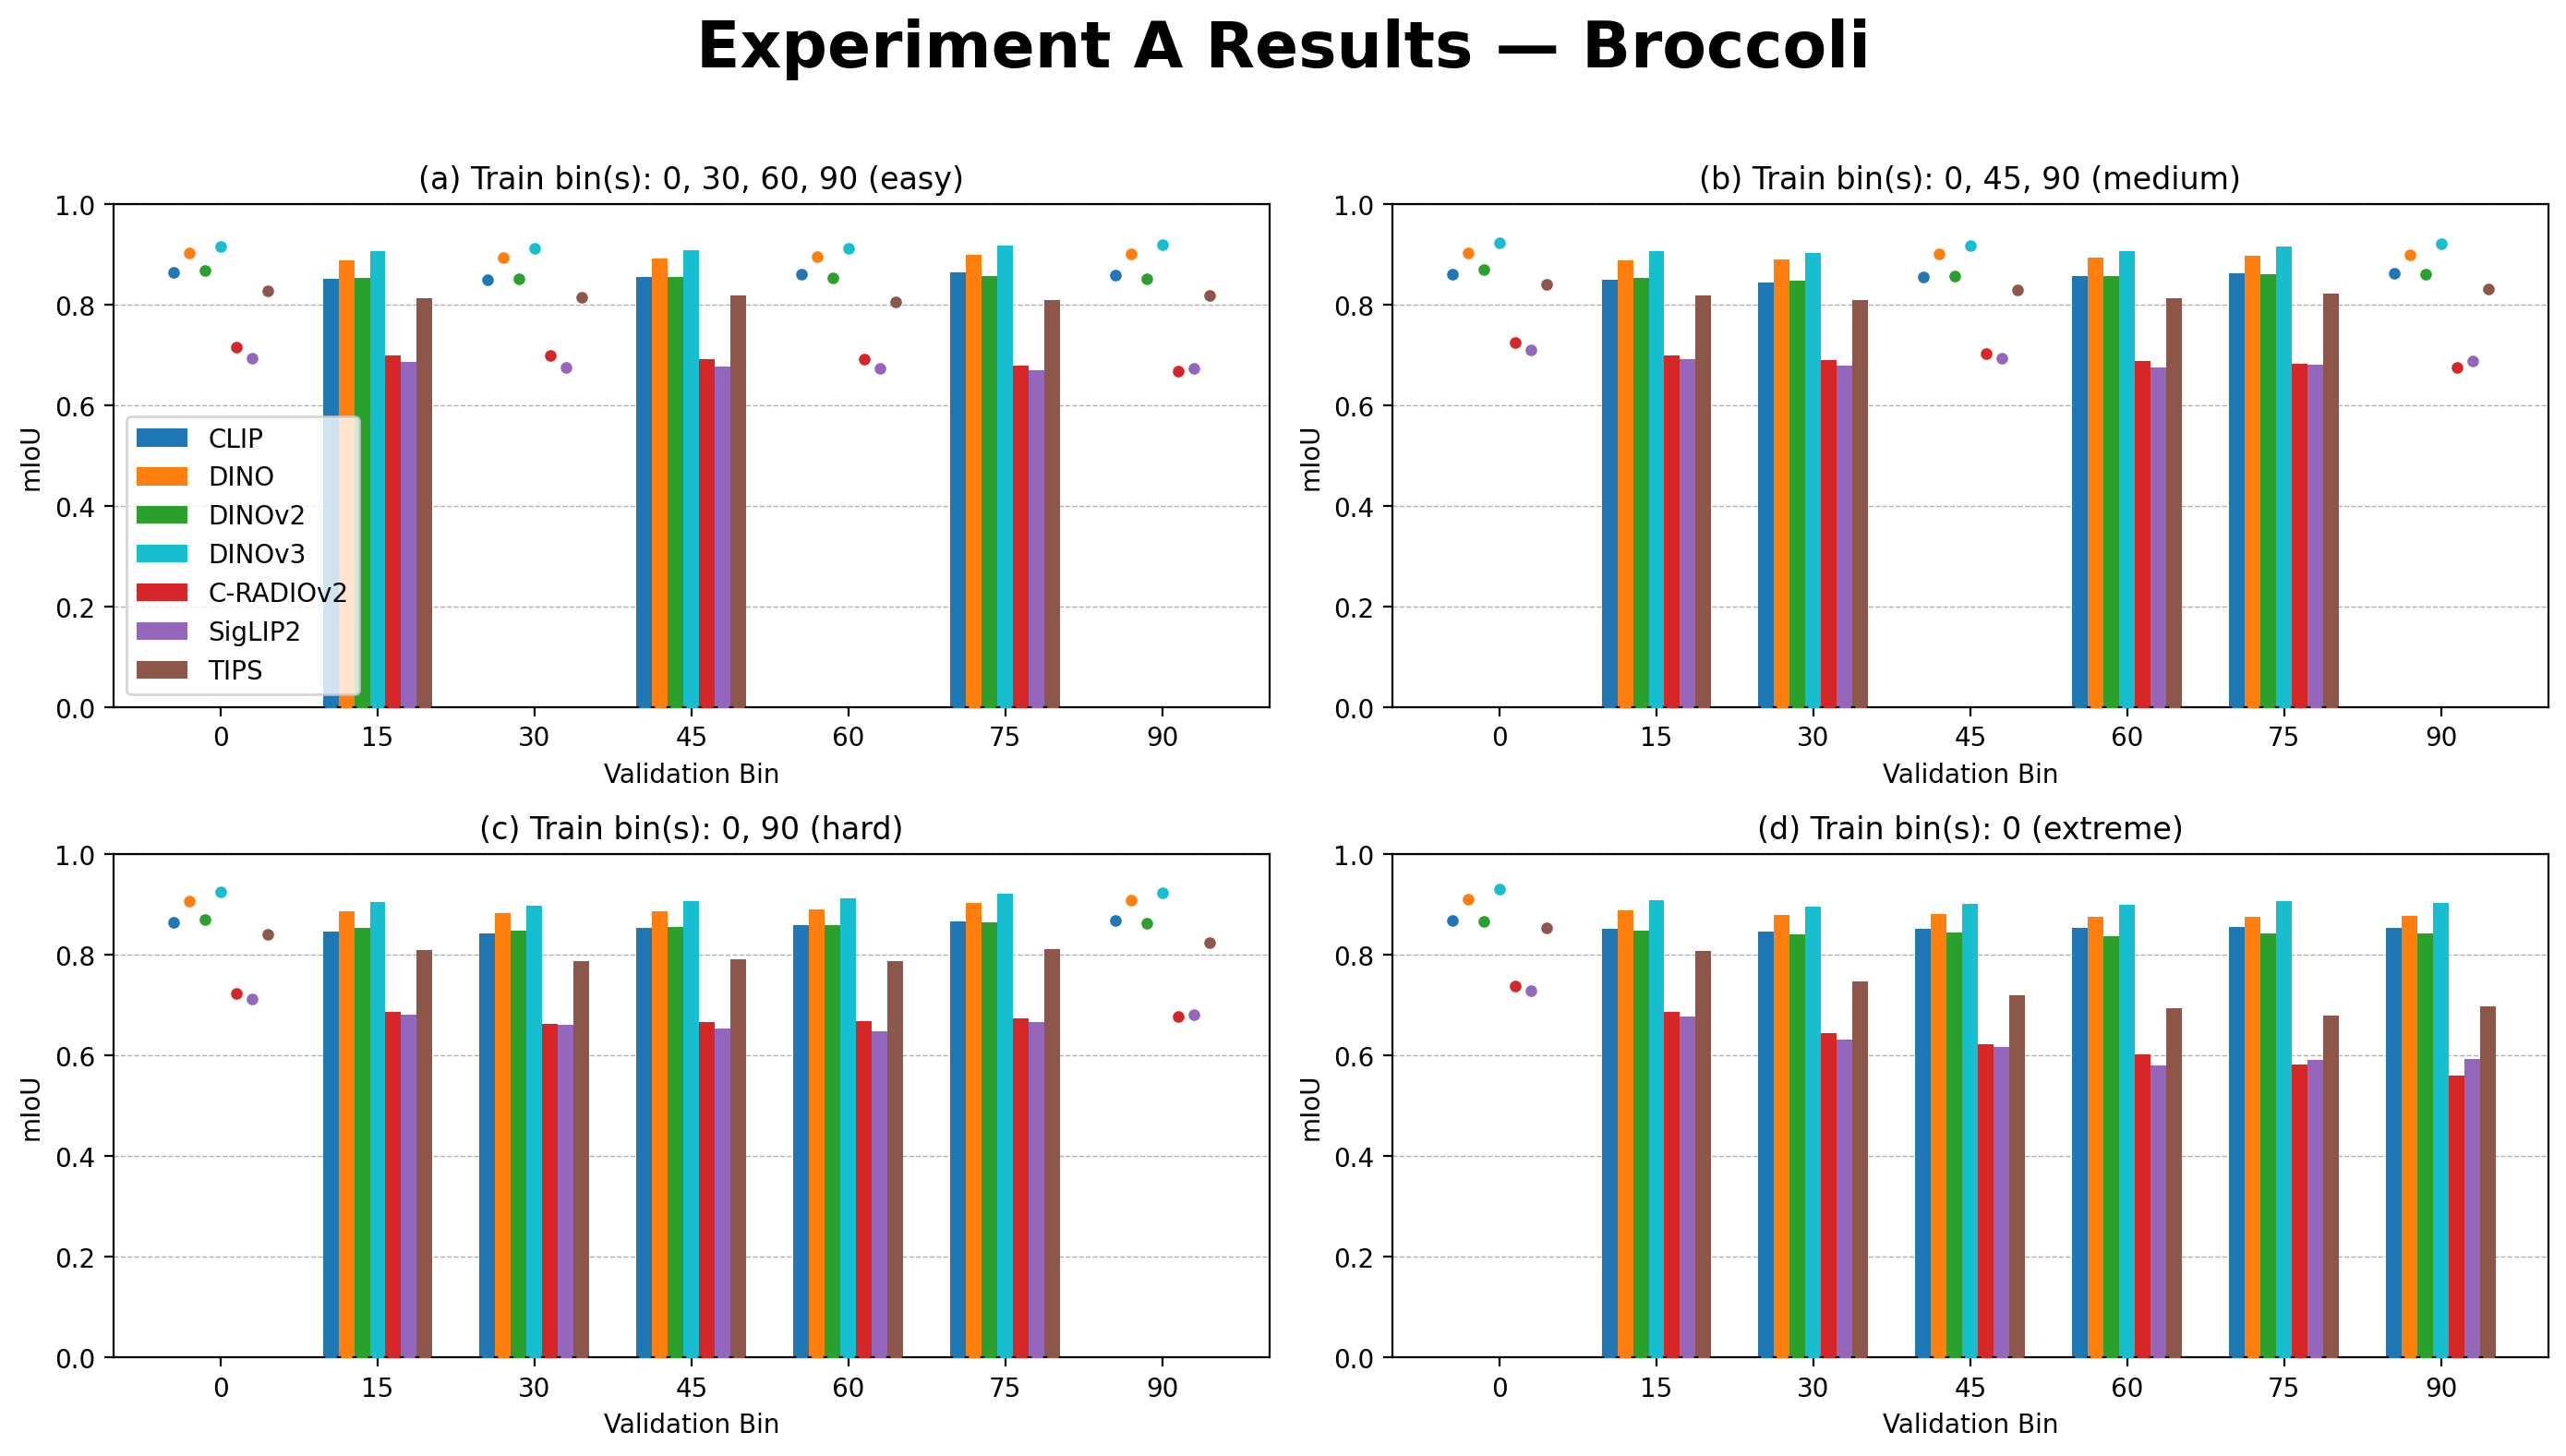

Saved figure to ../images/figures/15_durian.png


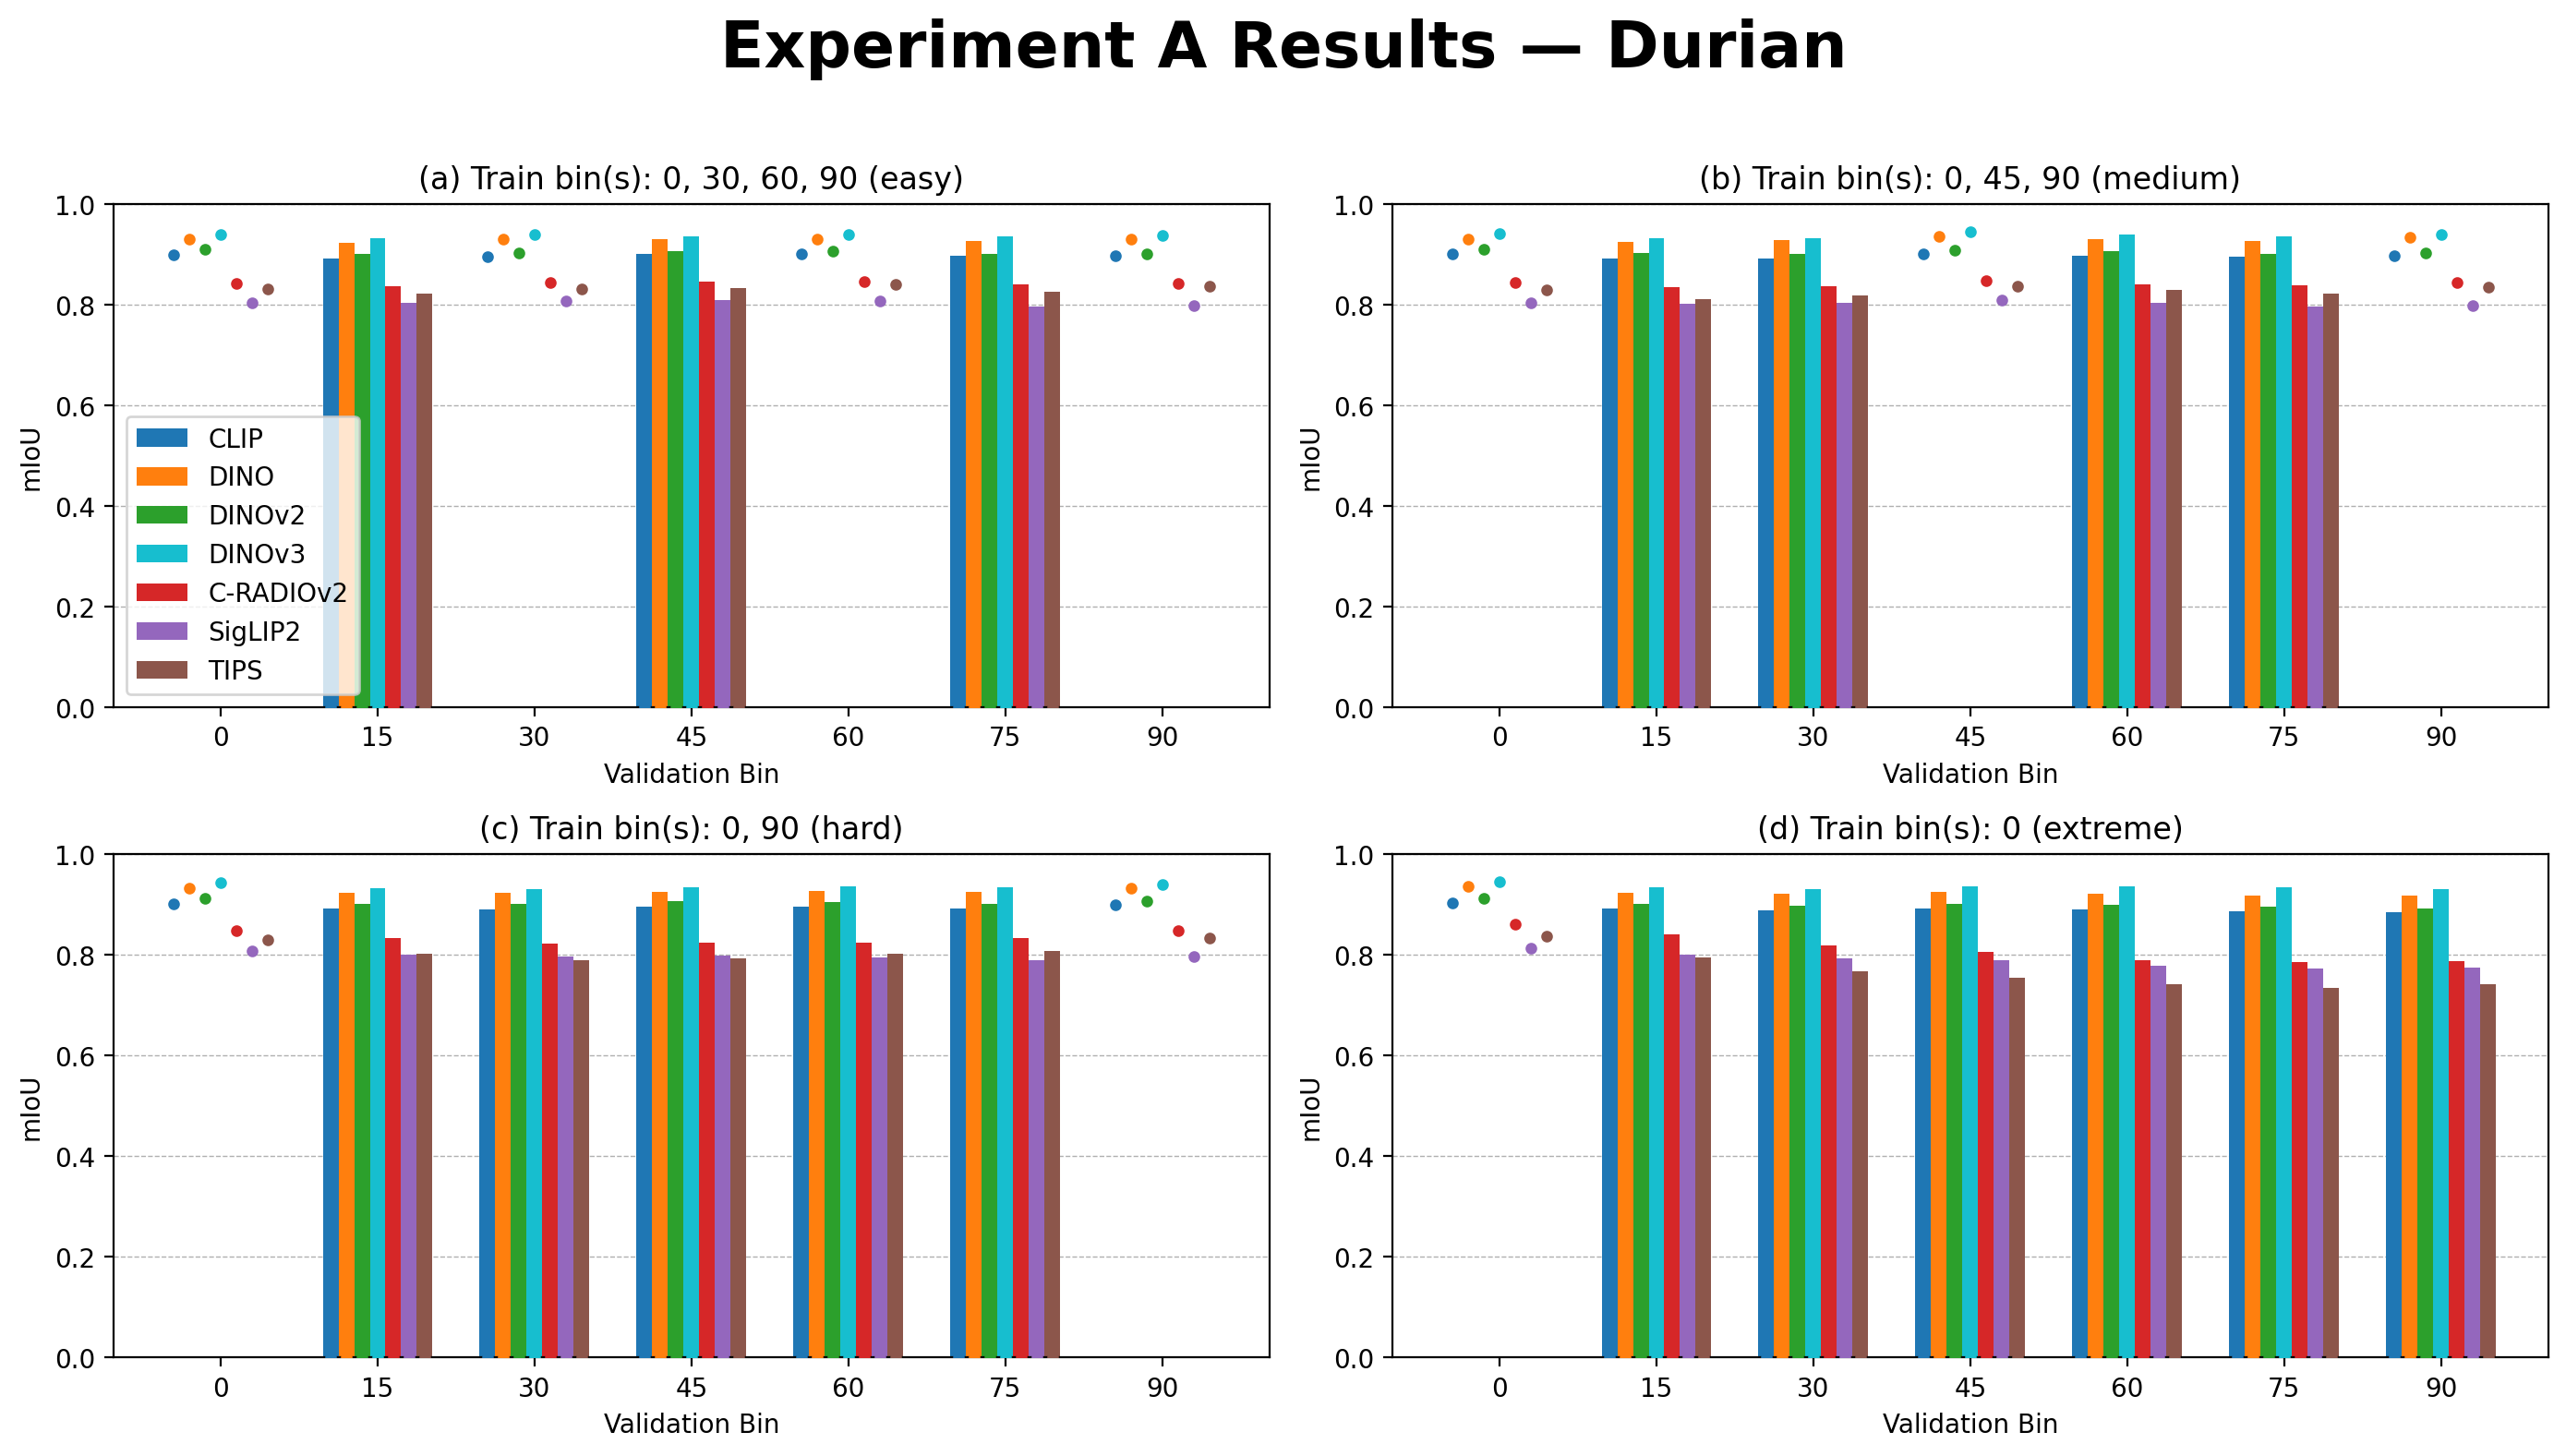

In [14]:

# Plot each class separately
for idx, (class_id, class_name) in enumerate(CLASS_TO_NAME.items()):
    save_path = f"../images/figures/{idx}_{class_name.replace(' ', '_')}.png"
    if class_id == 0:
        plot_exp_a([class_id], include_bg=True, extratitle=class_name.capitalize(), save_path=save_path)
    else:
        plot_exp_a([class_id], include_bg=False, extratitle=class_name.capitalize(), save_path=save_path)


### Comparing per class to the miou over all classes

In [15]:
DF_A = DF.copy()
# Compute baseline: mean over all classes jac0..jac15
class_cols = [f"jac{i}" for i in CLASS_TO_INDEX.values()]
DF_A["mean_all_classes"] = DF_A[class_cols].mean(axis=1)


In [16]:
rows = []

for _, row in DF_A.iterrows():

    model = row["model"]
    train_bins = row["train_bins"]
    difficulty = TRAIN_BINS_DIFFICULTY[train_bins]
    val_bin = row["val_bin"]
    all_mean = row["mean_all_classes"]

    for class_id, class_idx in CLASS_TO_INDEX.items():
        class_score = row[f"jac{class_idx}"]

        class_name = CLASS_TO_NAME[class_id]  # or CLASS_TO_NAME
        combined = f"{class_id} ({class_name})"

        rows.append({
            "model": model,
            "difficulty": difficulty,
            "train_bins": train_bins,
            "val_bin": val_bin,
            "class_id": class_id,
            "class_name": class_name,
            "class_full": combined,
            "class_mIoU": class_score,
            "all_classes_mIoU": all_mean,
            "difference": class_score - all_mean
        })

TABLE = pd.DataFrame(rows)


In [17]:
# Average difference per class (which classes underperform?)
TABLE.groupby("class_full")["difference"].mean().sort_values()

class_full
99 (coat rack)       -0.210865
46 (bed)             -0.203763
126 (sink)           -0.201696
100 (guitar stand)   -0.180580
19 (microwave)       -0.052178
113 (ceiling lamp)   -0.027508
70 (toy dragon)      -0.021856
60 (toy cow)         -0.016347
57 (toy cat)         -0.003495
8 (sofa)              0.035032
125 (toilet)          0.058827
7 (stove)             0.063920
152 (strings)         0.100662
166 (broccoli)        0.127197
196 (durian)          0.191304
0 (background)        0.341345
Name: difference, dtype: float64

In [18]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

TABLE.groupby(["model", "difficulty", "class_full"])["difference"].mean()

model                            difficulty  class_full        
C-RADIOv2-B                      easy        0 (background)        0.341179
                                             100 (guitar stand)   -0.244821
                                             113 (ceiling lamp)    0.026321
                                             125 (toilet)          0.211321
                                             126 (sink)           -0.182393
                                             152 (strings)         0.049179
                                             166 (broccoli)        0.070607
                                             19 (microwave)       -0.071250
                                             196 (durian)          0.220607
                                             46 (bed)             -0.076393
                                             57 (toy cat)         -0.049536
                                             60 (toy cow)         -0.063679
                        

In [19]:
def parse_train_bins(s):
    return set(map(int, s.split("_")))

TABLE["is_seen_bin"] = TABLE.apply(
    lambda r: r["val_bin"] in parse_train_bins(r["train_bins"]),
    axis=1
)


In [20]:
UNSEEN = TABLE[TABLE["is_seen_bin"] == False]


In [21]:
UNSEEN.groupby(["model", "difficulty", "class_full"])["difference"].mean()

model                            difficulty  class_full        
C-RADIOv2-B                      easy        0 (background)        0.349771
                                             100 (guitar stand)   -0.247229
                                             113 (ceiling lamp)    0.032104
                                             125 (toilet)          0.216437
                                             126 (sink)           -0.187229
                                             152 (strings)         0.058771
                                             166 (broccoli)        0.077771
                                             19 (microwave)       -0.077896
                                             196 (durian)          0.228771
                                             46 (bed)             -0.104563
                                             57 (toy cat)         -0.045563
                                             60 (toy cow)         -0.059562
                        

In [22]:
UNSEEN.groupby(["model", "difficulty", "class_full"])["class_mIoU"].mean()

model                            difficulty  class_full        
C-RADIOv2-B                      easy        0 (background)        0.961333
                                             100 (guitar stand)    0.364333
                                             113 (ceiling lamp)    0.643667
                                             125 (toilet)          0.828000
                                             126 (sink)            0.424333
                                             152 (strings)         0.670333
                                             166 (broccoli)        0.689333
                                             19 (microwave)        0.533667
                                             196 (durian)          0.840333
                                             46 (bed)              0.507000
                                             57 (toy cat)          0.566000
                                             60 (toy cow)          0.552000
                        

In [23]:
pd.pivot_table(
    UNSEEN,
    values="class_mIoU",
    index="difficulty",
    columns="model",
    aggfunc="mean"
)

model       C-RADIOv2-B  clip-vit-base-patch16  dino_vitb16  dinov2_vitb14  \
difficulty                                                                   
easy           0.611563               0.743563     0.755438       0.752062   
extreme        0.497354               0.698698     0.676063       0.724812   
hard           0.564975               0.726287     0.728662       0.740900   
medium         0.602531               0.739984     0.751391       0.750484   

model       dinov3-vitb16-pretrain-lvd1689m  siglip2-base-patch16-512  \
difficulty                                                              
easy                               0.814042                  0.534146   
extreme                            0.784000                  0.474813   
hard                               0.798600                  0.512000   
medium                             0.809156                  0.528891   

model       tips-b14   vggt-1b  
difficulty                      
easy        0.622271  0.184417  
extreme     0.468771  0.138479  
hard        0.565075  0.157375  
medium      0.613156  0.175531

In [24]:
pd.pivot_table(
    UNSEEN,
    values="difference",
    index="difficulty",
    columns="model",
    aggfunc="mean"
)

model        C-RADIOv2-B  clip-vit-base-patch16   dino_vitb16  dinov2_vitb14  \
difficulty                                                                     
easy       -4.394633e-17          -2.659909e-17  1.850372e-17   6.938894e-17   
extreme    -1.503427e-17           4.625929e-18  6.938894e-18  -4.625929e-17   
hard        3.747003e-17           1.942890e-17  1.110223e-17   1.526557e-17   
medium     -1.647987e-17           1.734723e-17 -6.938894e-18   4.423545e-17   

model       dinov3-vitb16-pretrain-lvd1689m  siglip2-base-patch16-512  \
difficulty                                                              
easy                           1.619075e-17              1.503427e-17   
extreme                        1.040834e-17             -1.561251e-17   
hard                           5.551115e-18              1.318390e-17   
medium                        -1.214306e-17             -3.469447e-18   

model           tips-b14       vggt-1b  
difficulty                              
easy       -3.469447e-17  1.329955e-17  
extreme    -2.949030e-17 -2.602085e-18  
hard        5.204170e-17  1.387779e-17  
medium      8.673617e-18 -2.168404e-18

## Job Statistics

In [25]:
DF_JOB = DF.copy()

job_id = str(DF_JOB['job_id'].iloc[0])
model = DF_JOB['model'].iloc[0]
prefix = PREFIXES.get(model)
if prefix is None:
    raise ValueError(f"Unknown model name: {model}")

log_path = Path(f"../logs/exp_a_b/{prefix}.job_{job_id}.log")

# Read last 15 lines after JOB STATISTICS
def tail_log_after_statistics(path, num_lines=15):
    if not path.exists():
        return f"Log file not found: {path}"
    
    with open(path, 'r') as f:
        lines = f.readlines()
        try:
            start_idx = next(i for i, line in enumerate(lines) if 'JOB STATISTICS' in line)
            return ''.join(lines[start_idx:start_idx + num_lines])
        except StopIteration:
            return "JOB STATISTICS not found in log file."

# Output result
log_tail = tail_log_after_statistics(log_path)
print(log_tail)


JOB STATISTICS
Job ID: 12071717
Cluster: snellius
User/Group: scur0542/scur0542
State: COMPLETED (exit code 0)
Nodes: 1
Cores per node: 72
CPU Utilized: 3-15:50:23
CPU Efficiency: 16.35% of 22-09:10:48 core-walltime
Job Wall-clock time: 07:27:39
Memory Utilized: 199.82 GB
Memory Efficiency: 41.63% of 480.00 GB (480.00 GB/node)



In [26]:
# Get all unique (job_id, model) pairs
unique_jobs = DF.copy()
unique_jobs = unique_jobs[['job_id', 'model']].drop_duplicates()

# Function to extract JOB STATISTICS section
def print_job_statistics(job_id, model):
    prefix = PREFIXES.get(model)
    if not prefix:
        print(f"Skipping unknown model: {model}")
        return
    
    log_path = Path(f"../logs/exp_a_b/{prefix}.job_{job_id}.log")
    print(f"\n=== JOB STATISTICS for job_id: {job_id}, model: {model} ===")
    
    if not log_path.exists():
        print(f"Log file not found: {log_path}")
        return

    with open(log_path, 'r') as f:
        lines = f.readlines()
        try:
            start_idx = next(i for i, line in enumerate(lines) if 'JOB STATISTICS' in line)
            for line in lines[start_idx:]:
                print(line, end='')  # already includes newline
        except StopIteration:
            print("'JOB STATISTICS' section not found in log.")

# Loop and print
print(f"The following JOB STATISTICS are for memory: {MEMORY}")
for _, row in unique_jobs.iterrows():
    job_id = str(row['job_id'])
    model = row['model']
    print_job_statistics(job_id, model)


The following JOB STATISTICS are for memory: 320000

=== JOB STATISTICS for job_id: 12071717, model: C-RADIOv2-B ===
JOB STATISTICS
Job ID: 12071717
Cluster: snellius
User/Group: scur0542/scur0542
State: COMPLETED (exit code 0)
Nodes: 1
Cores per node: 72
CPU Utilized: 3-15:50:23
CPU Efficiency: 16.35% of 22-09:10:48 core-walltime
Job Wall-clock time: 07:27:39
Memory Utilized: 199.82 GB
Memory Efficiency: 41.63% of 480.00 GB (480.00 GB/node)

=== JOB STATISTICS for job_id: 12071693, model: clip-vit-base-patch16 ===
JOB STATISTICS
Job ID: 12071693
Cluster: snellius
User/Group: scur0542/scur0542
State: COMPLETED (exit code 0)
Nodes: 1
Cores per node: 72
CPU Utilized: 3-15:33:05
CPU Efficiency: 16.13% of 22-14:40:48 core-walltime
Job Wall-clock time: 07:32:14
Memory Utilized: 198.14 GB
Memory Efficiency: 41.28% of 480.00 GB (480.00 GB/node)

=== JOB STATISTICS for job_id: 12071711, model: dino_vitb16 ===
JOB STATISTICS
Job ID: 12071711
Cluster: snellius
User/Group: scur0542/scur0542
State

## Table

In [27]:
df = DF.copy()

# change train_bins to a list of integers
df["train_bins"] = df["train_bins"].apply(lambda x: list(map(int, x.split("_"))))

# if val_bin is in train_bins, set val_in_trained accordingly
df["val_in_trained"] = df.apply(lambda row: row["val_bin"] in row["train_bins"], axis=1)

# set difficulty column
df["difficulty"] = df["train_bins"].apply(lambda x: TRAIN_BINS_DIFFICULTY["_".join(map(str, x))])

# filter only untrained bins
df = df[~df["val_in_trained"]].copy()

df_exp_a = pd.DataFrame(columns=["model", "easy", "medium", "hard", "extreme"])

# for each model and difficulty, calculate the mean and std of jac_mean
for model in MODELS.keys():
    model_df = df[df["model"] == model]
    model_df.loc[:, "jac_mean"] = model_df[[f"jac{i}" for i in range(1, 16)]].mean(axis=1)
    model_df.loc[:, "jac_std"] = model_df[[f"jac{i}" for i in range(1, 16)]].std(axis=1)
    
    # calculate mean and std for each difficulty
    means = model_df.groupby("difficulty")["jac_mean"].mean()
    stds = model_df.groupby("difficulty")["jac_std"].mean()

    # create a row for the model
    row = {
        "model": MODELS[model],
        "easy": f"{means.get('easy', 0):.3f} ± {stds.get('easy', 0):.3f}",
        "medium": f"{means.get('medium', 0):.3f} ± {stds.get('medium', 0):.3f}",
        "hard": f"{means.get('hard', 0):.3f} ± {stds.get('hard', 0):.3f}",
        "extreme": f"{means.get('extreme', 0):.3f} ± {stds.get('extreme', 0):.3f}"
    }
    
    df_exp_a = pd.concat([df_exp_a, pd.DataFrame([row])], ignore_index=True)

df_exp_a

model           easy         medium           hard        extreme
0       CLIP  0.729 ± 0.138  0.725 ± 0.141  0.710 ± 0.149  0.681 ± 0.156
1       DINO  0.741 ± 0.147  0.736 ± 0.150  0.712 ± 0.163  0.656 ± 0.178
2     DINOv2  0.738 ± 0.145  0.736 ± 0.146  0.726 ± 0.152  0.709 ± 0.158
3     DINOv3  0.803 ± 0.133  0.798 ± 0.136  0.787 ± 0.145  0.771 ± 0.157
4  C-RADIOv2  0.588 ± 0.136  0.579 ± 0.139  0.539 ± 0.146  0.467 ± 0.149
5    SigLIP2  0.506 ± 0.154  0.501 ± 0.156  0.483 ± 0.157  0.443 ± 0.149
6       TIPS  0.600 ± 0.161  0.590 ± 0.166  0.539 ± 0.178  0.437 ± 0.175

In [28]:
# give latex table
latex_table = df_exp_a.to_latex(index=False, escape=False, column_format='lcccc', 
                                  header=["Model", "Easy", "Medium", "Hard", "Extreme"])
print(latex_table)

\begin{tabular}{lcccc}
\toprule
Model & Easy & Medium & Hard & Extreme \\
\midrule
CLIP & 0.729 ± 0.138 & 0.725 ± 0.141 & 0.710 ± 0.149 & 0.681 ± 0.156 \\
DINO & 0.741 ± 0.147 & 0.736 ± 0.150 & 0.712 ± 0.163 & 0.656 ± 0.178 \\
DINOv2 & 0.738 ± 0.145 & 0.736 ± 0.146 & 0.726 ± 0.152 & 0.709 ± 0.158 \\
DINOv3 & 0.803 ± 0.133 & 0.798 ± 0.136 & 0.787 ± 0.145 & 0.771 ± 0.157 \\
C-RADIOv2 & 0.588 ± 0.136 & 0.579 ± 0.139 & 0.539 ± 0.146 & 0.467 ± 0.149 \\
SigLIP2 & 0.506 ± 0.154 & 0.501 ± 0.156 & 0.483 ± 0.157 & 0.443 ± 0.149 \\
TIPS & 0.600 ± 0.161 & 0.590 ± 0.166 & 0.539 ± 0.178 & 0.437 ± 0.175 \\
\bottomrule
\end{tabular}



# Experiment B

In [29]:
DF_B = DF.copy()
df_extreme = DF_B[DF_B["train_bins"] == "0"].copy() # extreme difficulty
df_extreme.head(10)

job_id                  model train_bins  val_bin  jac_mean  jac_std  \
126  12071717            C-RADIOv2-B          0        0     0.696    0.126   
127  12071717            C-RADIOv2-B          0       15     0.603    0.157   
128  12071717            C-RADIOv2-B          0       30     0.539    0.174   
129  12071717            C-RADIOv2-B          0       45     0.490    0.184   
130  12071717            C-RADIOv2-B          0       60     0.458    0.191   
131  12071717            C-RADIOv2-B          0       75     0.450    0.193   
132  12071717            C-RADIOv2-B          0       90     0.444    0.196   
133  12071693  clip-vit-base-patch16          0        0     0.788    0.108   
134  12071693  clip-vit-base-patch16          0       15     0.735    0.148   
135  12071693  clip-vit-base-patch16          0       30     0.715    0.156   

      jac0   jac1   jac2   jac3   jac4   jac5   jac6   jac7   jac8   jac9  \
126  0.967  0.700  0.672  0.714  0.696  0.642  0.638  0.610  0.544  0.444   
127  0.959  0.572  0.601  0.530  0.495  0.554  0.557  0.546  0.436  0.358   
128  0.955  0.476  0.553  0.392  0.403  0.481  0.494  0.490  0.378  0.308   
129  0.952  0.415  0.486  0.302  0.363  0.425  0.436  0.433  0.373  0.261   
130  0.951  0.394  0.480  0.251  0.351  0.389  0.389  0.391  0.314  0.237   
131  0.950  0.396  0.468  0.255  0.333  0.368  0.368  0.357  0.305  0.228   
132  0.949  0.411  0.454  0.267  0.254  0.359  0.352  0.344  0.329  0.244   
133  0.972  0.849  0.862  0.795  0.617  0.806  0.781  0.749  0.580  0.619   
134  0.968  0.822  0.814  0.711  0.455  0.767  0.746  0.714  0.497  0.539   
135  0.968  0.812  0.797  0.666  0.422  0.732  0.718  0.703  0.487  0.525   

     jac10  jac11  jac12  jac13  jac14  jac15  d_model  batch_size  \
126  0.705  0.898  0.591  0.718  0.738  0.861      768           4   
127  0.604  0.833  0.414  0.662  0.687  0.841      768           4   
128  0.544  0.758  0.337  0.588  0.644  0.819      768           4   
129  0.500  0.666  0.280  0.525  0.622  0.805      768           4   
130  0.469  0.605  0.245  0.476  0.603  0.789      768           4   
131  0.488  0.626  0.253  0.431  0.583  0.785      768           4   
132  0.489  0.638  0.248  0.418  0.561  0.788      768           4   
133  0.761  0.855  0.707  0.882  0.869  0.903      768           4   
134  0.714  0.841  0.547  0.874  0.852  0.893      768           4   
135  0.666  0.833  0.500  0.870  0.846  0.888      768           4   

     input_size  patch_size  
126         512          16  
127         512          16  
128         512          16  
129         512          16  
130         512          16  
131         512          16  
132         512          16  
133         512          16  
134         512          16  
135         512          16

In [30]:
def plot_exp_b(normalize=False, save_path: str | None = None):
    fig, ax = plt.subplots(figsize=(6, 4), dpi=200)

    if normalize:
        # plt.scatter(0, 1, color="black", marker="x", zorder=5, label="Baseline performance")
        plt.scatter(0, 1, color="black", marker="x", zorder=5, label="Baseline")
        plot_title = "Experiment B results (normalized to 0-bin performance)"
        y_label = "Normalized mIoU"
    else:
        plot_title = "Experiment B results"
        y_label = "mIoU"

    for model in MODELS.keys():
        df = df_extreme[df_extreme["model"] == model].copy()
        df["jac_mean"] = df[[f"jac{i}" for i in range(1, 16)]].mean(axis=1)
        df["jac_std"] = df[[f"jac{i}" for i in range(1, 16)]].std(axis=1)

        if not normalize:
            # plot the 0-bin performance
            df0 = df[df["val_bin"] == 0]
            x_values = df0["val_bin"]
            y_values = df0["jac_mean"]
            plt.scatter(x_values, y_values, color=COLORS[model], marker="x", s=100, zorder=5)

        # plot the other validation bins [15, ..., 90]
        if normalize:
            # get bin=0 performance
            df0 = df[df["val_bin"] == 0]
            model_0_score = df0["jac_mean"].values[0]

            df1590 = df[df["val_bin"] != 0].copy()
            df1590["jac_norm"] = df1590["jac_mean"] / model_0_score
            x_values = df1590["val_bin"]
            y_values = df1590["jac_norm"]
        else:
            df1590 = df[df["val_bin"] != 0]
            x_values = df1590["val_bin"]
            y_values = df1590["jac_mean"].values

        plt.plot(x_values, y_values, label=MODELS[model], color=COLORS[model])

    plt.xlabel("Bin")
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.xticks(XTICKS)
    plt.legend(fontsize='small')
    plt.grid(True)
    plt.ylim(0, 1.1)
    plt.tight_layout()


    # Save figure
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved figure to {save_path}")
    
    plt.show()


## Plots

Saved figure to ../images/expb_norm.png


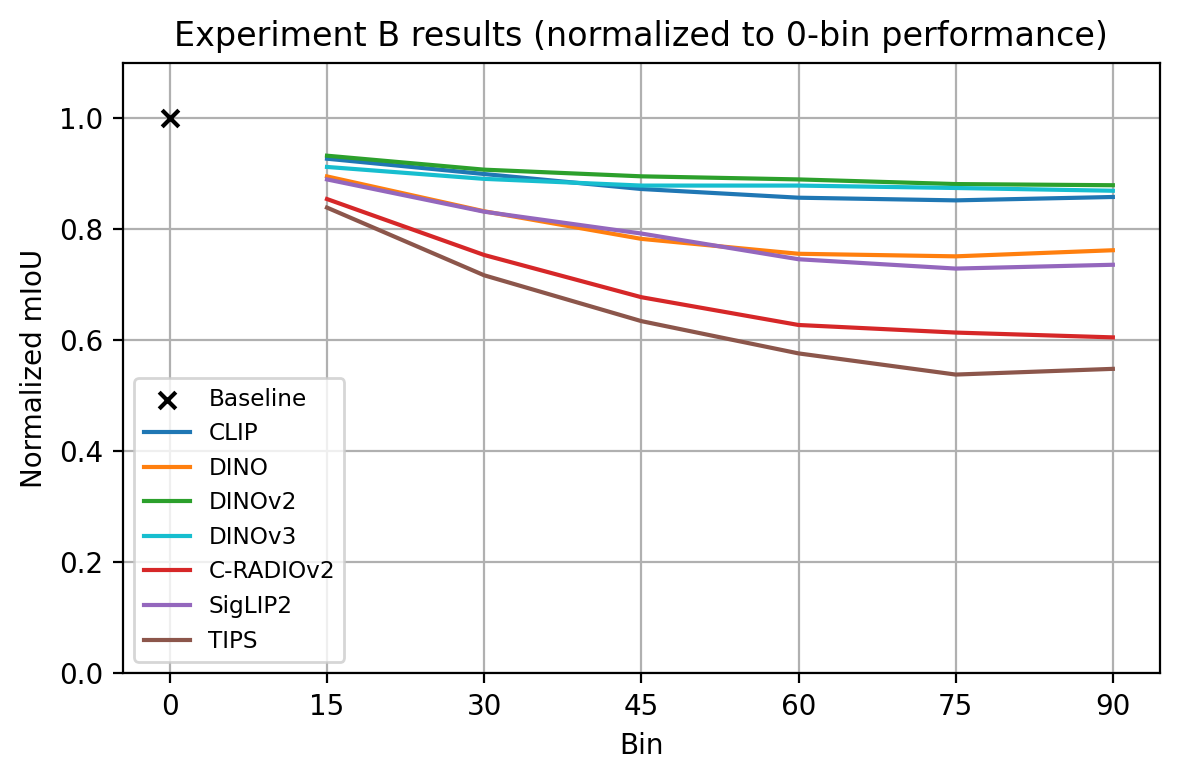

Saved figure to ../images/expb_raw.png


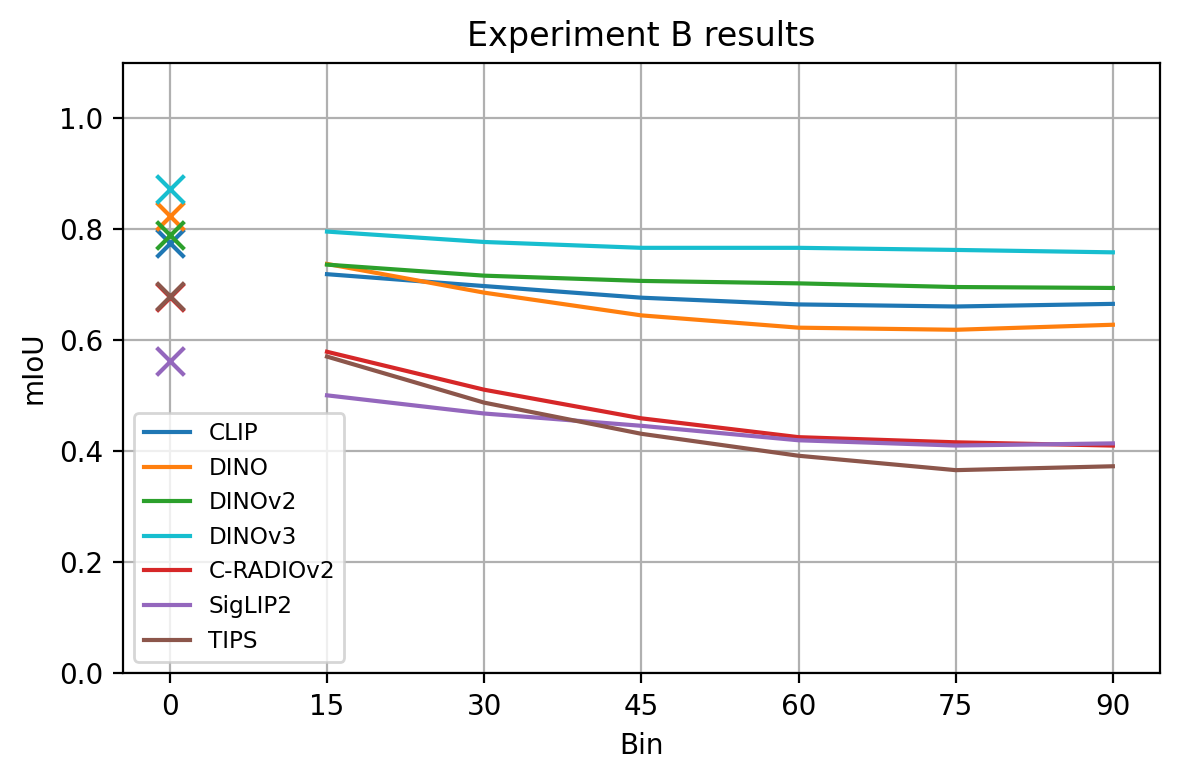

In [31]:
plot_exp_b(normalize=True, save_path="../images/expb_norm.png")
plot_exp_b(normalize=False, save_path="../images/expb_raw.png")

## Table

In [32]:
assert DF.equals(ORIGINAL_DF), "DataFrame DF has been modified!"

In [33]:
# DF.loc[:, "jac_mean"] = DF[[f"jac{i}" for i in range(1, 16)]].mean(axis=1)
# DF.loc[:, "jac_std"] = DF[[f"jac{i}" for i in range(1, 16)]].std(axis=1)

DF_BREAK = ORIGINAL_DF.copy()  # safe copy for experiment B
assert DF_BREAK.equals(ORIGINAL_DF), "DataFrame DF has been modified!"
df_extreme = DF_BREAK[DF_BREAK["train_bins"] == "0"].copy() # extreme difficulty

# Compute jac_mean for each row: raw mIoU per sample.
DF_BREAK.loc[:, "jac_mean"] = DF_BREAK[[f"jac{i}" for i in range(1, 16)]].mean(axis=1)
DF_BREAK.loc[:, "jac_std"] = DF_BREAK[[f"jac{i}" for i in range(1, 16)]].std(axis=1)
final_df = None
threshold = 0.05

for model in MODELS.keys():
    df = df_extreme[df_extreme["model"] == model].copy()
    # df = DF_BREAK[DF_BREAK["model"] == model].copy()

    # get bin=0 performance
    df0 = df[df["val_bin"] == 0]
    model_0_score = df0["jac_mean"].values[0]

    # Divide the jac_mean by the 0-bin performance (model_0_score) to get 
    # normalized jac_mean (jac_norm). This means we are using normalized mIoU, 
    # relative to the 0° bin baseline.
    df["jac_norm"] = df["jac_mean"] / model_0_score

    # jac_mean_prev is jac_mean but shifted down by one row
    df["jac_norm_prev"] = df["jac_norm"].shift(1)

    # Compute delta from jac_norm: Delta is difference between jac norm and shifted jac norm
    # In this way the deltas (drops) are in normalized space.
    # Conclusion: we are currently using normalized mIoU drops to detect breaking points.
    df["delta"] = df["jac_norm"] - df["jac_norm_prev"]
    df = df[df["val_bin"] != 0]

    # concat
    if final_df is None:
        final_df = df.copy()
    else:
        final_df = pd.concat([final_df, df], ignore_index=True)

final_df

# To find a breaking point: check the last column called delta, compare the delta with the threshold
# The first delta exceeding the treshold is the breaking point


job_id                            model train_bins  val_bin  jac_mean  \
0   12071693            clip-vit-base-patch16          0       15     0.735   
1   12071693            clip-vit-base-patch16          0       30     0.715   
2   12071693            clip-vit-base-patch16          0       45     0.695   
3   12071693            clip-vit-base-patch16          0       60     0.684   
4   12071693            clip-vit-base-patch16          0       75     0.680   
5   12071693            clip-vit-base-patch16          0       90     0.685   
6   12071711                      dino_vitb16          0       15     0.752   
7   12071711                      dino_vitb16          0       30     0.704   
8   12071711                      dino_vitb16          0       45     0.665   
9   12071711                      dino_vitb16          0       60     0.645   
10  12071711                      dino_vitb16          0       75     0.641   
11  12071711                      dino_vitb16          0       90     0.650   
12  12071713                    dinov2_vitb14          0       15     0.751   
13  12071713                    dinov2_vitb14          0       30     0.732   
14  12071713                    dinov2_vitb14          0       45     0.723   
15  12071713                    dinov2_vitb14          0       60     0.719   
16  12071713                    dinov2_vitb14          0       75     0.713   
17  12071713                    dinov2_vitb14          0       90     0.711   
18  16934109  dinov3-vitb16-pretrain-lvd1689m          0       15     0.807   
19  16934109  dinov3-vitb16-pretrain-lvd1689m          0       30     0.790   
20  16934109  dinov3-vitb16-pretrain-lvd1689m          0       45     0.780   
21  16934109  dinov3-vitb16-pretrain-lvd1689m          0       60     0.780   
22  16934109  dinov3-vitb16-pretrain-lvd1689m          0       75     0.776   
23  16934109  dinov3-vitb16-pretrain-lvd1689m          0       90     0.772   
24  12071717                      C-RADIOv2-B          0       15     0.603   
25  12071717                      C-RADIOv2-B          0       30     0.539   
26  12071717                      C-RADIOv2-B          0       45     0.490   
27  12071717                      C-RADIOv2-B          0       60     0.458   
28  12071717                      C-RADIOv2-B          0       75     0.450   
29  12071717                      C-RADIOv2-B          0       90     0.444   
30  12071718         siglip2-base-patch16-512          0       15     0.529   
31  12071718         siglip2-base-patch16-512          0       30     0.498   
32  12071718         siglip2-base-patch16-512          0       45     0.477   
33  12071718         siglip2-base-patch16-512          0       60     0.453   
34  12071718         siglip2-base-patch16-512          0       75     0.444   
35  12071718         siglip2-base-patch16-512          0       90     0.448   
36  12071719                         tips-b14          0       15     0.595   
37  12071719                         tips-b14          0       30     0.517   
38  12071719                         tips-b14          0       45     0.464   
39  12071719                         tips-b14          0       60     0.427   
40  12071719                         tips-b14          0       75     0.402   
41  12071719                         tips-b14          0       90     0.409   

    jac_std   jac0   jac1   jac2   jac3   jac4   jac5   jac6   jac7   jac8  \
0     0.148  0.968  0.822  0.814  0.711  0.455  0.767  0.746  0.714  0.497   
1     0.156  0.968  0.812  0.797  0.666  0.422  0.732  0.718  0.703  0.487   
2     0.164  0.967  0.796  0.754  0.635  0.361  0.694  0.686  0.696  0.490   
3     0.166  0.968  0.783  0.746  0.622  0.370  0.666  0.653  0.690  0.421   
4     0.169  0.968  0.778  0.760  0.622  0.361  0.650  0.615  0.669  0.408   
5     0.167  0.968  0.772  0.766  0.624  0.378  0.658  0.629  0.661  0.439   
6     0.154  0.974  0.828  0.829  0.703  0.496  0.810  0.780  